[New features baseline training](#New-features)

[New hyperparameter trainings](#New-hyperparameters)

[Adding 1 low level feature](#Adding-1-low-level-feature)

[Symmetry considerations](#Symmetry-considerations)

[Adding 2 low level features](#Adding-2-low-level-features)

[Adding 2 low level features + reframe + new hyperparameters](#Adding-2-high-level-features-+-reframe-+-new-hyperparameters)

In [1]:
import os
import sys
import inspect
import datetime
from time import time
from importlib import reload  
import pandas as pd
import numpy as np
import tables
import h5py
from joblib import load, dump
import tensorflow as tf
from keras.models import model_from_json
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import json
import pyarrow
import ROOT

Welcome to JupyROOT 6.22/06


In [2]:
sys.path.append('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning')

In [3]:
import HpTrainingFrame
from HpMLWeightTransformer import MultiSBWeightsScaler, WeightsMultiplier
from HpMLMTL import HpMTLBackgroundAugmenter, HpMTLBackgroundRandomizer
from HpMLUtils import FeatureDivider,variance
from HpMLFeatureNormalisation import WeightedStandardScaler
import HpKerasUtils
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint 
from sklearn.metrics import roc_auc_score, roc_curve

In [7]:
reload(HpTrainingFrame)

<module 'HpTrainingFrame' from '/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/HpTrainingFrame.py'>

# Functions definition

In this section two functions will be defined, one for preparing the data for training and another one for the training itself.

In [4]:
def label_discr (row):
    ''' Function to filter hpdiscriminant value by mass'''
    if(row.hpmass<0): 
        return row['HpDiscriminant_'+str(-int(row.hpmass))]
    else: 
        return row['HpDiscriminant_'+str(int(row.hpmass))]

def PrepareMassParametrised(df, feature_names, hpmass='multi', region="INC_ge6jge4b", steps_names=['msb','scl','rnd','fd','wss'], onediscr=True, exclude_columns=['nJets','nBTags_70'], reframelep_phi=False, reframelep_eta=False):
    """Prepares data for training. It can be selected which modifications will be done to the data:
        msb: MultiSBWeightsScaler
        scl: WeightsMultiplayer
        aug: HpMTLBackgroundAugmenter
        rnd: HpMTLBackgroundRandomizer
        fd: FeatureDivider
        wss: WeightStandardScaler
        Returns 9 data frames corresponding to train, test and data evaluation"""
    
    #WeightsMultiplier scale for multiple mass NN
    scales={
      200:16.,
      225:8.,
      250:8.,
      275:8.,
      300:16./3.,
      350:4.,
      400:8./3.,
      500:2.,
      600:2.,
      700:2.,
      800:2.,
      900:2.,
      1000:4./3.,
      1200:1.,
      1400:1.,
      1600:1.2,
      1800:1.5,
      2000:4.,
    }
    
    #Some transformations if we want to simplify the training by symmetry considerations
    if reframelep_phi:
        for i in range(0,6):
            df["jet_phi"+str(i+1)] = df["jet_phi"+str(i+1)]-df["lepton_phi"]
            df.loc[(df["jet_phi"+str(i+1)]>np.pi),"jet_phi"+str(i+1)] -= 2*np.pi
            df.loc[(df["jet_phi"+str(i+1)]< -np.pi),"jet_phi"+str(i+1)] += 2*np.pi

        df["met_phi"]=df["met_phi"]-df["lepton_phi"]
        df.loc[(df["met_phi"]>np.pi),"met_phi"] -= 2*np.pi
        df.loc[(df["met_phi"]< -np.pi),"met_phi"] += 2*np.pi
    
        feature_names.remove("lepton_phi")

    if reframelep_eta:
        for i in range(0,6):
            df.loc[(df.lepton_eta<0),"jet_eta"+str(i+1)] *= -1
        df.loc[(df.lepton_eta<0),"lepton_eta"] *= -1
    
    discr = ['HpDiscriminant_200','HpDiscriminant_225','HpDiscriminant_250','HpDiscriminant_275','HpDiscriminant_300','HpDiscriminant_350','HpDiscriminant_400','HpDiscriminant_500','HpDiscriminant_600','HpDiscriminant_700','HpDiscriminant_800','HpDiscriminant_900','HpDiscriminant_1000','HpDiscriminant_1200','HpDiscriminant_1400','HpDiscriminant_1600','HpDiscriminant_1800','HpDiscriminant_2000']
    
    if onediscr==True:
        htf = HpTrainingFrame.HpTrainingFrame(df,feature_names + discr)
    else:
        htf = HpTrainingFrame.HpTrainingFrame(df,feature_names)
    msb = MultiSBWeightsScaler(backgroundclass=-1)
    scl = WeightsMultiplier(scales=scales,backgroundclass=-1)
    aug = HpMTLBackgroundAugmenter(backgroundclass=-1)
    rnd = HpMTLBackgroundRandomizer(backgroundclass=-1)
    fd = FeatureDivider("hpmass",excludecolumns = exclude_columns)
    wss = WeightedStandardScaler()
        
    steps=[(msb,"msb"),(scl,"scl"),(aug,"aug"),(rnd,"rnd"),(fd,"fd"),(wss,"wss")]
        
    #Divide data in three data frames, one for data, second for labels and third for weights
    X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=hpmass,region=region,addMass=True)
    y_train = X_train.hpmass.copy()
    y_test = X_test.hpmass.copy()
      
    #Processing data and preparing it for training. Only chosen modifications will be done
    for hp_class, class_name in steps:
        if class_name in steps_names:

            hp_class.fit(X_train,X_train.hpmass, sample_weight=w_train)
            X_train, y_train, w_train = hp_class.transform(X_train,y_train, sample_weight=w_train)
            X_test, y_test, w_test = hp_class.transform(X_test,y_test, sample_weight=w_test)
            
            if class_name=='rnd' and onediscr==True:
                #Remove the discriminant
                for imass in list(X_train.hpmass.unique()):
                    X_train.loc[X_train.hpmass == imass,'HpDiscriminant'] = X_train[X_train.hpmass == imass]['HpDiscriminant_'+str(imass)]
                    X_test.loc[X_test.hpmass == imass,'HpDiscriminant'] = X_test[X_test.hpmass == imass]['HpDiscriminant_'+str(imass)]
#                X_train['HpDiscriminant'] = X_train.apply(lambda row: label_discr(row), axis=1)
#                X_test['HpDiscriminant'] = X_test.apply(lambda row: label_discr(row), axis=1)
                
                X_train = X_train.drop(columns=discr)
                X_test = X_test.drop(columns=discr)            
                #Move the mass column to the last
                cols = list(X_train.columns)
                cols[-2:] = cols[:-3:-1]
                X_train = X_train[cols]
                X_test = X_test[cols]

            #Printing background and signal integral. Just to clarify how weights change in every process
            print(class_name + ":")
            print("Background integral:",w_train.values[y_train<0].sum(),"\nSignal integral:",w_train.values[y_train>0].sum(),'\n')
            
                
    y_train=(y_train>0)
    y_test=(y_test>0)
    
    if 'wss' in steps_names: return [(X_train, y_train, w_train),(X_test, y_test, w_test),(wss.mean_,wss.scale_)]
    else: return [(X_train, y_train, w_train),(X_test, y_test, w_test),(None,None)]

In [5]:
def getCallbacks(model):
    """ Standard callbacks for Keras Early stopping and checkpoint"""
    return [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

#ModelCheckpoint(filepath='model_nn_'+str(model.configuration)+"_dropout"+str(model.dropout)+"_l2threshold"+str(model.l2threshold)+
#".hdf5",monitor='val_loss',save_best_only=True)


def training(training_data,test_data,configuration,dropout,epochs,patience,batch_size,trainlabel,region):
    """Training function"""
    
    #Keeping track of when the training started
    training_start = int(time())
    start_hour = datetime.datetime.now().strftime("%H:%M:%S")
    
    #Standard feedforward model
    modelNN = HpKerasUtils.HpFeedForwardModel(configuration,dropout=dropout, verbose=True, input_dim=X_train.shape[1])
    resultNN = modelNN.train(training_data, test_data,
                             patience=patience , epochs=epochs, callbacks=getCallbacks(modelNN), batch_size=batch_size)
    
    #Keeping track of when the training finished. Getting the training time
    training_finish = int(time())
    finish_hour = datetime.datetime.now().strftime("%H:%M:%S")
    dif_time = training_finish-training_start
    print('Start hour:'+start_hour+'\n'+'Finish hour:'+finish_hour+'\n'+'Training time:'+str(datetime.timedelta(seconds=dif_time)))
    
    #Saving raw NN model
    arch_file=open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_arch_'+ region +'_'+ trainlabel +'.h5','w') #save architecture for analysis framework
    arch_file.write(modelNN.model.to_json())
    arch_file.close()
    modelNN.model.save_weights('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_weights_'+ region +'_'+ trainlabel +'.h5') #Save weights for analysis framework
    
    #Printing training results and plotting binary accuracy and loss
    print(resultNN)
    modelNN.plotTrainingValidation()
    
    return modelNN

In [29]:
def ROC_Score_plot(modelNN,X,y,w,path,reg,plotlabel,do_ROC=True,do_Score=True,hpmass=None):
    """Function that plots ROC curve and NN socore for the test data
       on Matplotlib"""
    
    #Getting the data we want to plot
    y_pred = modelNN.predict(X.values).ravel()
    roc_auc = roc_auc_score(y,y_pred,sample_weight=w)
    false_pr, true_pr, thresholds = roc_curve(y, y_pred, sample_weight = w)
    
    if do_ROC==True:
        #Plotting ROC
        plt.figure(figsize=(6.4,4.8),linewidth=0)

        plt.plot(false_pr,true_pr, ls='-', c="blue", linewidth=1.3, label="ROC (area = {:.5f})".format(roc_auc))
        plt.plot([0.,1.],[0.,1.], ls='--', c="gray", linewidth=1.3, label="Luck")

        plt.xlabel("False Positive Rate", ha="right",x=1, fontsize=10.3, labelpad=10)
        plt.ylabel("True Positive Rate",ha= "right",y=1, fontsize=11, labelpad=10)

        plt.minorticks_on()
        plt.tick_params(axis="both", which="major", width=.6, length=7.5, pad=4)
        plt.tick_params(axis="both", which="minor", width=.6, length=4, pad=4)

        plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=11))
        plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=11))

        plt.xlim(-.05,1.05)
        plt.ylim(-.05, 1.05)

        plt.legend(loc="best", frameon=True, prop=fm.FontProperties(fname=fpath,size=11))
        
        if hpmass==None: plt.savefig(path + '/roc_curve_' + reg + '_' + plotlabel +'.png',dpi=300,bbox_inches='tight')
        else: plt.savefig(path + '/roc_curve_' + reg + '_' + str(hpmass) + '_' + plotlabel +'.png',dpi=300,bbox_inches='tight')
        plt.show
    
    if do_Score==True:
        #Plotting Score
        plt.figure(figsize=(6.4,4.8),linewidth=0)

        plt.hist(y_pred[y<0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w[y<0.5], fc=(0.,0.,1.,0.18), ec="blue", linewidth=1.3, density=True, label="Background")
        plt.hist(y_pred[y>0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w[y>0.5], fc=(1.,0.,0.,0.18), ec="red", linewidth=1.3, density=True, label="H$^+$ {} GeV".format(hpmass)\
                 if hpmass!= None else 'Signal')

        plt.xlabel("Mass Parameterised NN Score", ha="right",x=1, fontsize=10.3, labelpad=10)

        plt.minorticks_on()
        plt.tick_params(axis="both", which="major", width=.6, length=7.5, pad=4)
        plt.tick_params(axis="both", which="minor", width=.6, length=4, pad=4)

        plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=11))
        plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=11))

        plt.xlim(-.05,1.05)
        plt.ylim(0, plt.gca().get_ylim()[1]*1.15 )

        plt.legend(loc="best", frameon=False, prop=fm.FontProperties(fname=fpath,size=11))
        
        # Print AUC at the corner
        ax = plt.gca()
        plt.text(0.15,0.93,'AUC = {:.5f}'.format(roc_auc), horizontalalignment='center', verticalalignment='center',\
                 transform = ax.transAxes,fontproperties=fm.FontProperties(fname=fpath,size=11))

        if hpmass==None: plt.savefig(path + '/NN_Score_' + reg + '_' + plotlabel + '.png',dpi=300,bbox_inches='tight')
        else: plt.savefig(path + '/NN_Score_' + reg + '_' + str(hpmass) + '_' + plotlabel + '.png',dpi=300,bbox_inches='tight')
        plt.show
        
    return roc_auc

        
def AUCvsHpmass(rocs,mass,reg,path,plotlabel):
    plt.figure(figsize=(6.4,4.8),linewidth=0)

    plt.plot(np.arange(1,len(mass)+1,1),rocs, ls='-', c="blue", marker='o', linewidth=1.3)
    plt.plot([0.,19],[1.,1.], ls='--', c="gray", linewidth=1.3)

    plt.xlabel("H$^+$ mass [GeV]", ha="right",x=1, fontsize=11, labelpad=8)
    plt.ylabel("AUC",ha= "right",y=1, fontsize=11, labelpad=8)

    plt.minorticks_on()
    plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=11))
    
    plt.gca().set_xticks(np.arange(1,len(mass)+1,1))
    plt.gca().set_xticklabels(np.array(mass).astype(int).astype(str), rotation=-45,fontproperties=fm.FontProperties(fname=fpath,size=11))
    plt.gca().xaxis.set_tick_params(which='minor', bottom=False, top=False)
    
#    plt.tick_params(axis="both", which="major", width=.6, length=7.5, pad=4)
#    plt.tick_params(axis="y", which="minor", width=.6, length=4, pad=4)
    
    plt.xlim(0,19)
    plt.ylim(0.6, 1.02)

    plt.savefig(path + '/aucvsmass_' + reg + '_' + plotlabel +'.png',dpi=300,bbox_inches='tight')
    plt.show

def relativeAUC(aucs,auc_file_name,reg,path,plotlabel):
    
    with open(auc_file_name,'r') as inputFile:
        data = json.load(inputFile)
        mass = data['Hp mass']
        old_auc = np.array(data['AUC'])
        
    plt.figure(figsize=(6.4,4.8),linewidth=0)

    plt.plot(np.arange(1,len(mass)+1,1),-(aucs-old_auc)/old_auc, c="blue", marker='o', ls='None')

    plt.xlabel("H$^+$ mass [GeV]", ha="right",x=1, fontsize=11, labelpad=8)
    plt.ylabel("Relative AUC difference",ha= "right",y=1, fontsize=11, labelpad=8)

    plt.minorticks_on()
    plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=11))
    
    plt.gca().set_xticks(np.arange(1,len(mass)+1,1))
    plt.gca().set_xticklabels(np.array(mass).astype(int).astype(str), rotation=-45,fontproperties=fm.FontProperties(fname=fpath,size=11))
    plt.gca().xaxis.set_tick_params(which='minor', bottom=False, top=False)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    plt.xlim(0,19)
#    plt.ylim(-0.1e-3, 4.5e-3)

    plt.savefig(path + '/relativeauc_' + reg + '_' + plotlabel +'.png',dpi=300,bbox_inches='tight')
    plt.show

## Data frame analysis

In [9]:
def filter_data(df,features,tolerance,do_xcheck=True):
    '''Filters the outliers of the data. Two methods are used: getting the 
    data beyond 10 sigmas and comparing the order between two consecutive 
    points of the distribution. In addition, it also filters 0 weight, nJets<0,
    nBTags<0 and Discriminant>1.1 events.
    
    Tolerance: desired maximum order difference between the data.
    do_xcheck: if true, only the common outlaiers of more than one column will 
            be filtered.
    
    Returns the filtered dataframe frame, a dictionary with the filtered outlaiers.
    '''   
    
    #Gets the standard deviation and the mean of every feature
    df_std = df.std(numeric_only=True)
    df_mean = df.mean(numeric_only=True)
    
    #Creates empty dictionaries for the data filtered
    filtered_sigma = {}
    filtered_orders = {}
    common_filtered = {}

    filter_count = 0 #number of events filtered
    
    for column in features:
        common_filtered[column] = []
    
    #Pre-outlaiers filter 
    #common_filtered['weight'] = list(df[df.weight==0].to_numpy())
    df = df[df.weight!=0]
    
    common_filtered['nBTags_70'] = list(df[df['nBTags_70']<0].to_numpy())
    df = df[df['nBTags_70']>0]
    filter_count += len(df[df['nBTags_70']<0].index)
    
    common_filtered['nJets'] = list(df[df['nJets']<0].to_numpy())
    df = df[df['nJets']>0]
    filter_count += len(df[df['nJets']<0].index)
    
    discriminant = ['HpDiscriminant_200','HpDiscriminant_225','HpDiscriminant_250','HpDiscriminant_275','HpDiscriminant_300','HpDiscriminant_350','HpDiscriminant_400','HpDiscriminant_500','HpDiscriminant_600','HpDiscriminant_700','HpDiscriminant_800','HpDiscriminant_900','HpDiscriminant_1000','HpDiscriminant_1200','HpDiscriminant_1400','HpDiscriminant_1600','HpDiscriminant_1800','HpDiscriminant_2000']
    for discr in discriminant:
        common_filtered[discr] = list(df[df[discr]>1.1][discr].to_numpy())
        common_filtered[discr] = list(df[df[discr]<0][discr].to_numpy())
        filter_count += len(df[df[discr]>1.1].index) + len(df[df[discr]<0].index)
        df = df[df[discr]<1.1]
        df = df[df[discr]>0]
        
    
    #Outlaiers filter
    for column in features:        
        #Gets the data to filter from order differences method
        filtered_orders[column] = []
        sorted_np = np.sort(df[column].to_numpy())
        
        #Minimum values
        if sorted_np[1]!=0:
            order_dif_low = sorted_np[0]/sorted_np[1]
        else:
            order_dif_low = sorted_np[0]
            
        i=1
        while order_dif_low > tolerance:
            filtered_orders[column].append(sorted_np[i-1]) 
            if sorted_np[i+1]!=0:
                order_dif_low = sorted_np[i]/sorted_np[i+1]
            else:
                order_dif_low = sorted_np[i]
            i += 1
        
        #Maximum values
        if sorted_np[-2]!=0:
            order_dif_high = sorted_np[-1]/sorted_np[-2]
        else:
            order_dif_high = sorted_np[-1]
        
        i=2
        while order_dif_high > tolerance:
            filtered_orders[column].append(sorted_np[-(i-1)])
            if sorted_np[-(i+1)]!=0:
                order_dif_high = sorted_np[-i]/sorted_np[-(i+1)]
            else:
                order_dif_high= sorted_np[-i] 
            i += 1
        
        #Gets the data to filter from sigmas method only when we desire to compare both methods
        if filtered_orders[column]!=0:
            filtered_sigma[column] = list(np.sort(df[column][(df[column]<(df_mean[column]-10*df_std[column]))|(df[column]>(df_mean[column]+10*df_std[column]))].to_numpy()))

        #Filtered outlaiers are put in a common list
        for value in filtered_orders[column]:
            if value in filtered_sigma[column]: 
                common_filtered[column].append(value)
        
        #Finally, the data series is filtered        
        if do_xcheck==False:
            for value in common_filtered[column]:
                df = df[df[column]!=value]
                filter_count +=1
        else:
            for second_column in features[i+1:]:
                for value in common_filtered[column]:
                    for second_value in common_filtered[second_column]:
                        if df[(df[column]==value)&(df[second_column]==second_value)].empty: 
                            common_filtered[column].remove(value)
                        else:
                            filter_count += 1
                        df = df[(df[column]!=value)&(df[second_column]!=second_value)]
                        
    print('Number of events filtered: ',filter_count)
            
    return (df,common_filtered)

In [10]:
df_new = pd.read_feather("/nfs/at3/scratch/salvador/HplusML/HDFWriter/pandas_4vec/pandas_INC_ge6jgeq4b.feather")
df_new = df_new[(df_new.process!='Hp1001')&(df_new.process!='ttlight_aMCNloP8')&(df_new.process!='tH_new')&(df_new.weight!=0)&(df_new.hpmass!=2500)&(df_new.hpmass!=3000)]
df_new.head()

level_0  index         el_pt        mu_pt  HpNNv3_1200  \
0        0      0            []  [34785.008]     0.022604   
1        1      1    [98540.18]           []     0.001236   
2        2      2            []  [100766.29]     0.031392   
3        3      3  [122791.266]           []     0.000961   
4        4      4            []   [54694.83]     0.002731   

   HpDiscriminant_1400  HpNNv3_225  nBTags_70  HpDiscriminant_350  HpNNv3_400  \
0             0.019111    0.442654          4            0.502510    0.515259   
1             0.015989    0.571737          4            0.517781    0.681101   
2             0.035684    0.279882          4            0.010351    0.111386   
3             0.006317    0.603158          4            0.400757    0.264559   
4             0.017893    0.353594          4            0.333904    0.101683   

   ...    Mbb_MaxM_70  nJets  HpDiscriminant_300    weight  ReWeighting  \
0  ...  231522.750000      7            0.583631  0.062751     1.017244   
1  ...  200162.296875      6            0.545408  0.136305     0.996082   
2  ...  333937.500000      6            0.013306  0.108638     1.010369   
3  ...  186417.437500      6            0.549379  0.112889     1.029358   
4  ...  130885.703125      6            0.438466  0.122123     1.118524   

   process             group        region  hpmass   year  
0  ttlight  t#bar{t} + light  INC_ge6jge4b      -1  mc16a  
1  ttlight  t#bar{t} + light  INC_ge6jge4b      -1  mc16a  
2  ttlight  t#bar{t} + light  INC_ge6jge4b      -1  mc16a  
3  ttlight  t#bar{t} + light  INC_ge6jge4b      -1  mc16a  
4  ttlight  t#bar{t} + light  INC_ge6jge4b      -1  mc16a  

[5 rows x 75 columns]

In [11]:
feature_names = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_e1', 'jet_mv2c101', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_e2', 'jet_mv2c102', 'jet_pt3', 'jet_eta3', 'jet_phi3', 'jet_e3', 'jet_mv2c103', 'jet_pt4', 'jet_eta4', 'jet_phi4', 'jet_e4', 'jet_mv2c104', 'jet_pt5', 'jet_eta5', 'jet_phi5', 'jet_e5', 'jet_mv2c105', 'jet_pt6', 'jet_eta6', 'jet_phi6', 'jet_e6', 'jet_mv2c106','lepton_pt','lepton_phi','lepton_eta','lepton_e']
def vecM(row,feature,number):
    '''Calculates invariant mass from pt, phi, eta and e.
    
        feature: jet or lepton.
        number: if jet, number of jet.'''
    
    vec4 = ROOT.TLorentzVector()
    if number!=0: vec4.SetPtEtaPhiE(row[feature+'_pt'+str(number)],row[feature+'_eta'+str(number)],row[feature+'_phi'+str(number)],row[feature+'_e'+str(number)])
    if number==0: vec4.SetPtEtaPhiE(row[feature+'_pt'],row[feature+'_eta'],row[feature+'_phi'],row[feature+'_e'])
    return vec4.M()


#Combine electron and mu columns in lepton_
columns_suffix= ['pt','eta','phi','e']
for s in columns_suffix:
    df_new['el_'+s]=pd.DataFrame(df_new['el_'+s].tolist(), index= df_new.index)
    df_new['mu_'+s]=pd.DataFrame(df_new['mu_'+s].tolist(), index= df_new.index)
    df_new.loc[np.isnan(df_new['el_'+s])==False,'lepton_'+s]=df_new[np.isnan(df_new['el_'+s])==False]['el_'+s]
    df_new.loc[np.isnan(df_new['mu_'+s])==False,'lepton_'+s]=df_new[np.isnan(df_new['mu_'+s])==False]['mu_'+s]
df_new = df_new.drop(columns = ['el_pt','el_phi','el_eta','el_e','mu_pt','mu_phi','mu_eta','mu_e'])

#Load vector columns 
htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
df_new = htf.load_vec_features() 

#New column with invariant mass for every jet and lepton
for i in range(6):
    df_new['jet_m'+str(i+1)] = df_new.apply(lambda row: vecM(row,'jet',i+1), axis=1) #invariant mass for jets
df_new['lepton_m'] = df_new.apply(lambda row: vecM(row,'lepton',0), axis=1)
    
df_filtered, filtered_data =filter_data(df_new,feature_names,1e4,do_xcheck=False) 

Number of events filtered:  1


In [14]:
filtered_data

{'jet_pt1': [],
 'jet_eta1': [],
 'jet_phi1': [],
 'jet_e1': [],
 'jet_mv2c101': [],
 'jet_pt2': [],
 'jet_eta2': [],
 'jet_phi2': [],
 'jet_e2': [],
 'jet_mv2c102': [],
 'jet_pt3': [],
 'jet_eta3': [],
 'jet_phi3': [],
 'jet_e3': [],
 'jet_mv2c103': [],
 'jet_pt4': [],
 'jet_eta4': [],
 'jet_phi4': [],
 'jet_e4': [],
 'jet_mv2c104': [],
 'jet_pt5': [],
 'jet_eta5': [],
 'jet_phi5': [],
 'jet_e5': [],
 'jet_mv2c105': [],
 'jet_pt6': [],
 'jet_eta6': [],
 'jet_phi6': [],
 'jet_e6': [],
 'jet_mv2c106': [],
 'lepton_pt': [],
 'lepton_phi': [],
 'lepton_eta': [],
 'lepton_e': [],
 'nBTags_70': [],
 'nJets': [],
 'HpDiscriminant_200': [-999.0],
 'HpDiscriminant_225': [],
 'HpDiscriminant_250': [],
 'HpDiscriminant_275': [],
 'HpDiscriminant_300': [],
 'HpDiscriminant_350': [],
 'HpDiscriminant_400': [],
 'HpDiscriminant_500': [],
 'HpDiscriminant_600': [],
 'HpDiscriminant_700': [],
 'HpDiscriminant_800': [],
 'HpDiscriminant_900': [],
 'HpDiscriminant_1000': [],
 'HpDiscriminant_1200': [],

In [15]:
df_filtered.head()

level_0  index  HpNNv3_1200  HpDiscriminant_1400  HpNNv3_225  nBTags_70  \
0        0      0     0.022604             0.019111    0.442654          4   
1        1      1     0.001236             0.015989    0.571737          4   
2        2      2     0.031392             0.035684    0.279882          4   
3        3      3     0.000961             0.006317    0.603158          4   
4        4      4     0.002731             0.017893    0.353594          4   

   HpDiscriminant_350  HpNNv3_400  HpDiscriminant_200  HpDiscriminant_500  \
0            0.502510    0.515259            0.472551            0.254219   
1            0.517781    0.681101            0.128087            0.282137   
2            0.010351    0.111386            0.278053            0.047153   
3            0.400757    0.264559            0.721875            0.115128   
4            0.333904    0.101683            0.499657            0.123763   

   ...  lepton_eta  lepton_phi       lepton_e        jet_m1        jet_m2  \
0  ...    0.669141   -0.088083   42867.562500  18140.148919  20860.233545   
1  ...   -0.523227    0.964102  112339.234375  12288.839309  11735.261720   
2  ...   -0.254648   -0.898907  104051.156250  15715.931886  16021.526487   
3  ...   -0.687250   -0.924499  152948.687500  13178.877529   7545.152129   
4  ...    1.476694   -2.278240  125985.125000   6790.175330   5928.259890   

         jet_m3       jet_m4       jet_m5       jet_m6    lepton_m  
0   6127.694692  6548.349369  7971.537841  6024.672517  105.868169  
1  10308.409101  9761.144444  7912.794591  6276.713823   -8.020303  
2  11801.006099  8980.803890  9524.219024  3670.700673  109.062688  
3  10919.403042  4704.550079  4352.133340  4827.399084   27.947684  
4   5253.443751  4426.523190  5429.424090  4850.143454  106.202761  

[5 rows x 103 columns]

In [16]:
df_filtered.columns

Index(['level_0', 'index', 'HpNNv3_1200', 'HpDiscriminant_1400', 'HpNNv3_225',
       'nBTags_70', 'HpDiscriminant_350', 'HpNNv3_400', 'HpDiscriminant_200',
       'HpDiscriminant_500',
       ...
       'lepton_eta', 'lepton_phi', 'lepton_e', 'jet_m1', 'jet_m2', 'jet_m3',
       'jet_m4', 'jet_m5', 'jet_m6', 'lepton_m'],
      dtype='object', length=103)

In [17]:
df_filtered.process.unique()

array(['ttlight', 'ttc', 'ttb', 'ttW', 'ttZ', 'st_wchan', 'st_tchan',
       'othertop', 'bosonicBkg', 'ttH', 'tH', 'tWH', 'Hp200', 'Hp225',
       'Hp250', 'Hp275', 'Hp300', 'Hp350', 'Hp400', 'Hp500', 'Hp600',
       'Hp700', 'Hp800', 'Hp900', 'Hp1000', 'Hp1200', 'Hp1400', 'Hp1600',
       'Hp1800', 'Hp2000'], dtype=object)

In [18]:
df_filtered = df_filtered.drop(columns = ['level_0'])
df_filtered.reset_index(inplace=True)
df_filtered.to_feather('/nfs/pic.es/user/s/srodrigu/Jupyter/pandas_files/pandas_INC_ge6jgeq4b.feather')

In [19]:
df_new = pd.read_feather('/nfs/pic.es/user/s/srodrigu/Jupyter/pandas_files/pandas_INC_ge6jgeq4b.feather')
df_new.head()

level_0  index  HpNNv3_1200  HpDiscriminant_1400  HpNNv3_225  nBTags_70  \
0        0      0     0.022604             0.019111    0.442654          4   
1        1      1     0.001236             0.015989    0.571737          4   
2        2      2     0.031392             0.035684    0.279882          4   
3        3      3     0.000961             0.006317    0.603158          4   
4        4      4     0.002731             0.017893    0.353594          4   

   HpDiscriminant_350  HpNNv3_400  HpDiscriminant_200  HpDiscriminant_500  \
0            0.502510    0.515259            0.472551            0.254219   
1            0.517781    0.681101            0.128087            0.282137   
2            0.010351    0.111386            0.278053            0.047153   
3            0.400757    0.264559            0.721875            0.115128   
4            0.333904    0.101683            0.499657            0.123763   

   ...  lepton_eta  lepton_phi       lepton_e        jet_m1        jet_m2  \
0  ...    0.669141   -0.088083   42867.562500  18140.148919  20860.233545   
1  ...   -0.523227    0.964102  112339.234375  12288.839309  11735.261720   
2  ...   -0.254648   -0.898907  104051.156250  15715.931886  16021.526487   
3  ...   -0.687250   -0.924499  152948.687500  13178.877529   7545.152129   
4  ...    1.476694   -2.278240  125985.125000   6790.175330   5928.259890   

         jet_m3       jet_m4       jet_m5       jet_m6    lepton_m  
0   6127.694692  6548.349369  7971.537841  6024.672517  105.868169  
1  10308.409101  9761.144444  7912.794591  6276.713823   -8.020303  
2  11801.006099  8980.803890  9524.219024  3670.700673  109.062688  
3  10919.403042  4704.550079  4352.133340  4827.399084   27.947684  
4   5253.443751  4426.523190  5429.424090  4850.143454  106.202761  

[5 rows x 103 columns]

# General plots

In [9]:
fpath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/arial.ttf")
fbipath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/ArialBoldItalic.ttf")
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.linewidth']= 0.85
region = "INC_ge6jge4b"

In [6]:
with open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_actual_training.json','r') as inputFile:
    data = json.load(inputFile)
    auc_mass = data['Hp mass']
    auc_auc1 = data['AUC']
        
with open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_highlvl_nodiscr.json','r') as inputFile:
    data = json.load(inputFile)
    auc_auc2 = data['AUC']
with open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_new_training.json','r') as inputFile:
    data = json.load(inputFile)
    auc_auc3 = data['AUC']
with open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_new_training_reframe.json','r') as inputFile:
    data = json.load(inputFile)
    auc_auc4 = data['AUC']
with open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_lowlvl_features_HTjets.json','r') as inputFile:
    data = json.load(inputFile)
    auc_auc5 = data['AUC']

<function matplotlib.pyplot.show(close=None, block=None)>

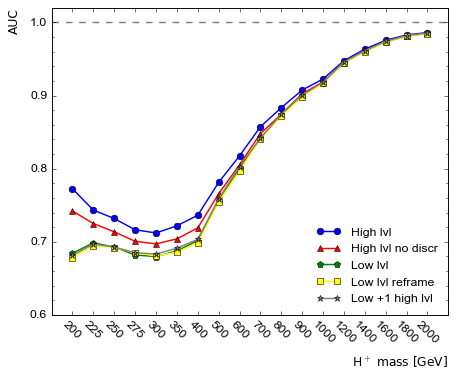

In [14]:
plt.figure(figsize=(6.4,4.8),linewidth=0)

plt.plot(np.arange(1,len(auc_mass)+1,1),auc_auc1, ls='-', c="blue", marker='o', linewidth=1.3, label='High lvl')
plt.plot(np.arange(1,len(auc_mass)+1,1),auc_auc2, ls='-', c="red", marker='^', linewidth=1.3, label='High lvl no discr' )
plt.plot(np.arange(1,len(auc_mass)+1,1),auc_auc3, ls='-', c="green", marker='p', linewidth=1.3, label='Low lvl')
plt.plot(np.arange(1,len(auc_mass)+1,1),auc_auc4, ls='-', c="yellow", marker='s', linewidth=1.3, label='Low lvl reframe')
plt.plot(np.arange(1,len(auc_mass)+1,1),auc_auc5, ls='-', c="gray", marker='*', linewidth=1.3, label='Low +1 high lvl')
plt.plot([0.,19],[1.,1.], ls='--', c="gray", linewidth=1.3)

plt.xlabel("H$^+$ mass [GeV]", ha="right",x=1, fontsize=11, labelpad=8)
plt.ylabel("AUC",ha= "right",y=1, fontsize=11, labelpad=8)

plt.minorticks_on()
plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=11))
    
plt.gca().set_xticks(np.arange(1,len(auc_mass)+1,1))
plt.gca().set_xticklabels(np.array(auc_mass).astype(int).astype(str), rotation=-45,fontproperties=fm.FontProperties(fname=fpath,size=11))
plt.gca().xaxis.set_tick_params(which='minor', bottom=False, top=False)
    
plt.xlim(0,19)
plt.ylim(0.6, 1.02)

plt.legend(loc="best", frameon=False, prop=fm.FontProperties(fname=fpath,size=11))

plt.savefig('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training' + '/aucvsmass_' + region + '_' + 'full_plot' +'.png',dpi=600,bbox_inches='tight')
plt.show

# Runner

## New features

In [7]:
fpath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/arial.ttf")
fbipath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/ArialBoldItalic.ttf")
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.linewidth']= 0.85

feature_names = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_m1', 'jet_mv2c101', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_m2', 'jet_mv2c102', 'jet_pt3', 'jet_eta3', 'jet_phi3', 'jet_m3', 'jet_mv2c103', 'jet_pt4', 'jet_eta4', 'jet_phi4', 'jet_m4', 'jet_mv2c104', 'jet_pt5', 'jet_eta5', 'jet_phi5', 'jet_m5', 'jet_mv2c105', 'jet_pt6', 'jet_eta6', 'jet_phi6', 'jet_m6', 'jet_mv2c106','lepton_pt','lepton_phi','lepton_eta','met_met','met_phi']
steps = ['msb','scl','rnd','wss']
region = "INC_ge6jge4b"
NNlayers = [64,64]
batchsize = 50
dropout = 0.1
epochs = 300
patience = 5

In [8]:
df_new = pd.read_feather('/nfs/pic.es/user/s/srodrigu/Jupyter/pandas_files/pandas_INC_ge6jgeq4b.feather')

In [9]:
data = PrepareMassParametrised(df_new, feature_names, steps_names=steps, onediscr=False)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit = data[2]

msb:
Background integral: 0.5000000000000001 
Signal integral: 0.5 

scl:
Background integral: 0.5000000000000001 
Signal integral: 0.5000000000000001 

-1 1942133    2.113674e-07
1636581    2.093343e-07
1839581    1.470414e-07
1602098    4.447223e-08
1591364    4.025891e-08
               ...     
773654     6.444582e-07
1650185    1.893742e-07
1401201    5.034874e-08
1591320    3.677423e-08
1014802    7.224909e-07
Name: weight, Length: 973134, dtype: float64 0.5000000000000001
200 1950775    0.000022
1949967    0.000028
1950451    0.000015
1952146    0.000027
1951592    0.000034
             ...   
1951660    0.000024
1951692    0.000021
1948311    0.000021
1950101    0.000023
1949062    0.000021
Name: weight, Length: 2100, dtype: float64 0.04405286343612335
225 1959401    0.000004
1953820    0.000004
1957932    0.000007
1952456    0.000006
1956420    0.000006
             ...   
1954155    0.000005
1956217    0.000004
1956965    0.000005
1958919    0.000006
1958085    0.000006
Name:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2368      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,593
Trainable params: 6,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
21740/21740 [==============================] - 154s 7ms/step - loss: 4.6331e-07 - binary_accuracy: 0.6909 - 

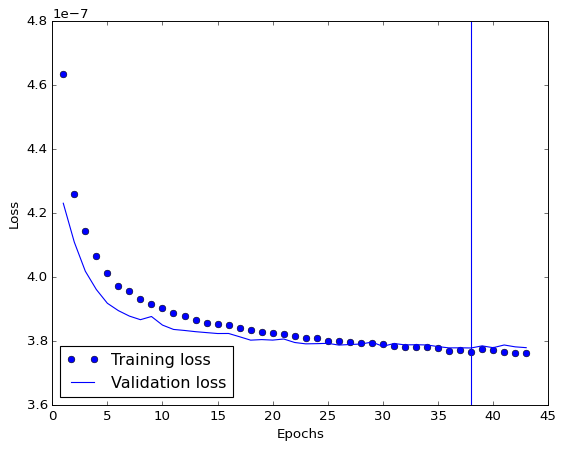

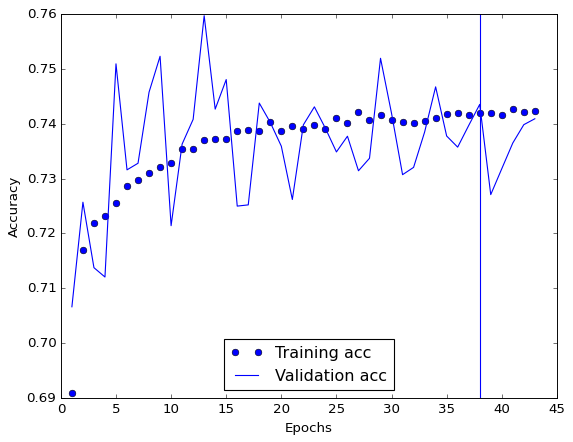

2021-04-18 19:03:42.575881: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-04-18 19:03:42.626307: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:60:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-04-18 19:03:42.627336: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-04-18 19:03:42.631258: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-18 19:03:42.634469: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-04-18 19:03:42.635766: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

In [10]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'4vec_features_baseline',region)

0.8842607291876509

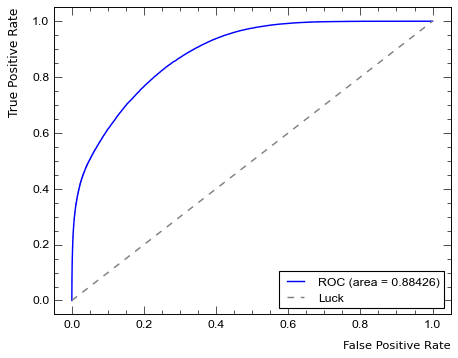

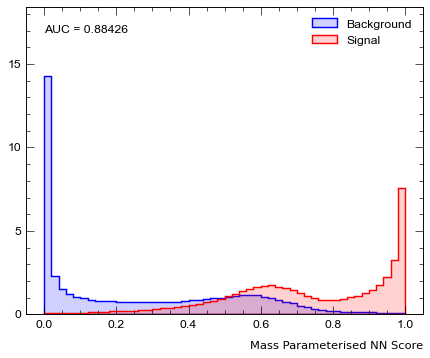

In [15]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'4vec_features')

In [16]:
#Load the NN
json_file = open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_arch_'+ region +'_'+ '4vec_features_baseline'+'.h5')
loaded_model_json = json_file.read()
json_file.close()

modelNN = model_from_json(loaded_model_json)
modelNN.load_weights('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_weights_'+ region +'_'+ '4vec_features_baseline'+'.h5')

(977067, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(978810, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980083, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980617, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(981324, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980383, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980821, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980204, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(981081,

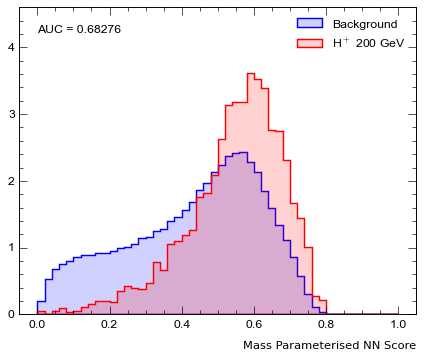

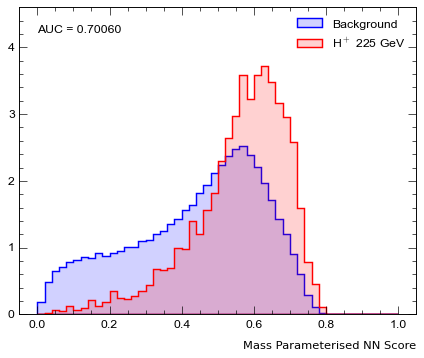

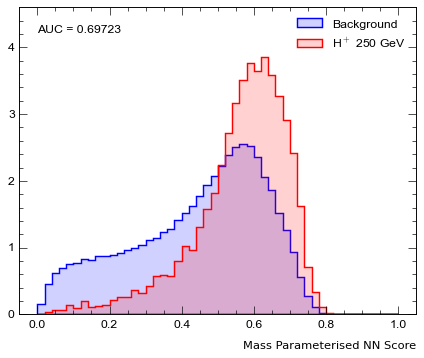

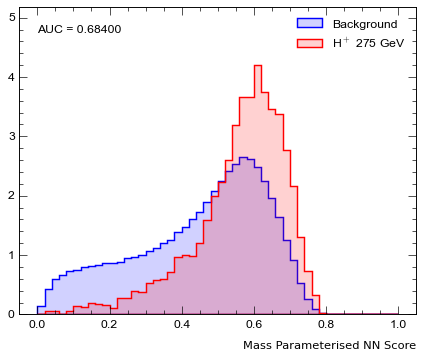

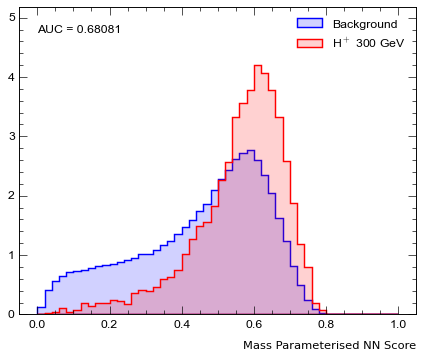

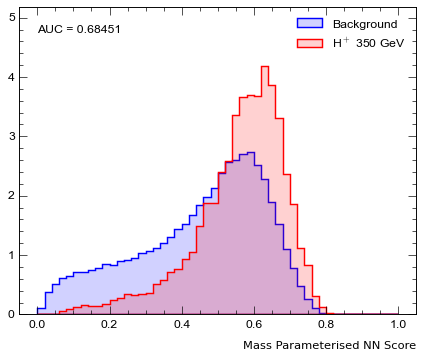

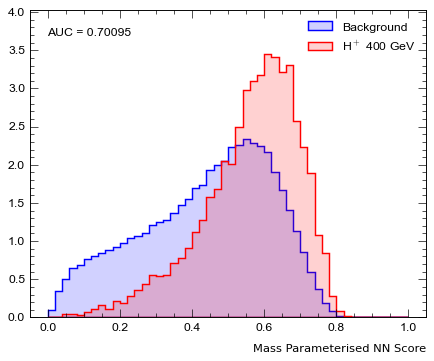

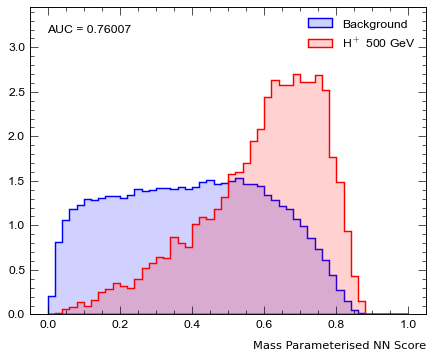

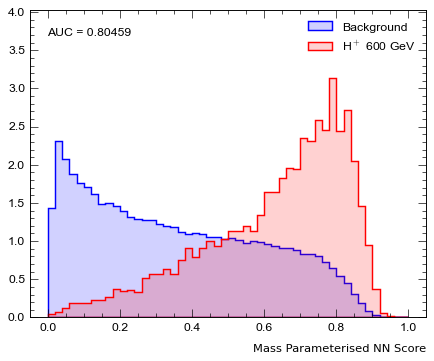

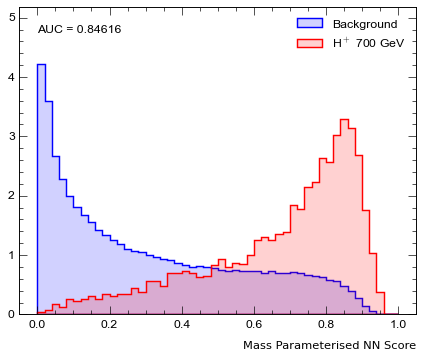

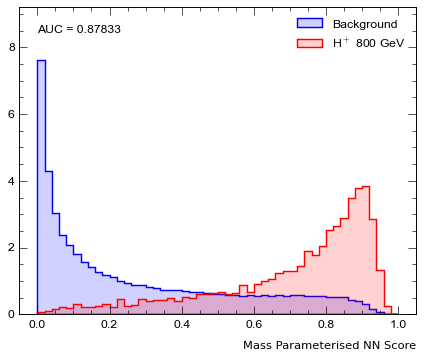

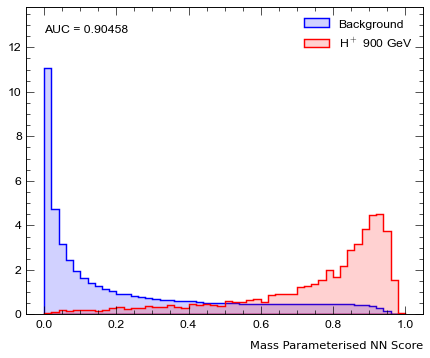

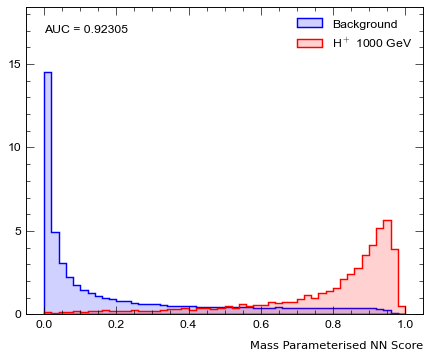

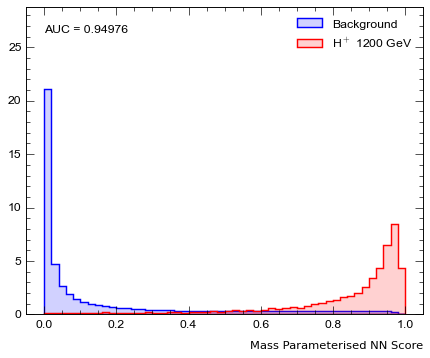

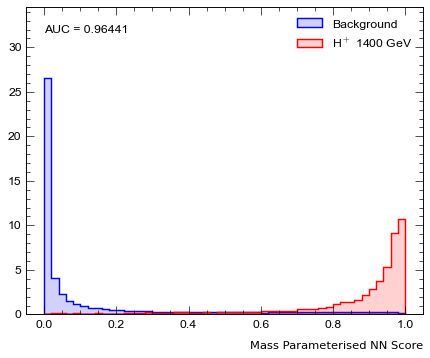

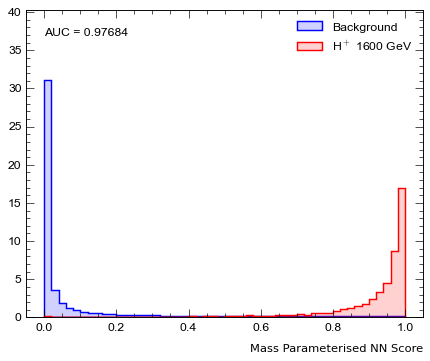

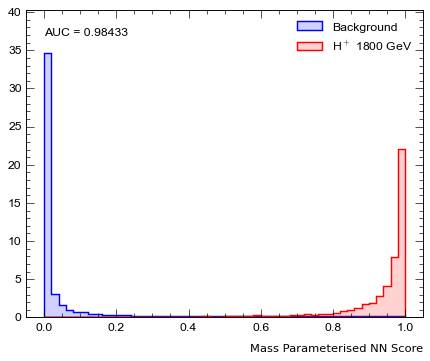

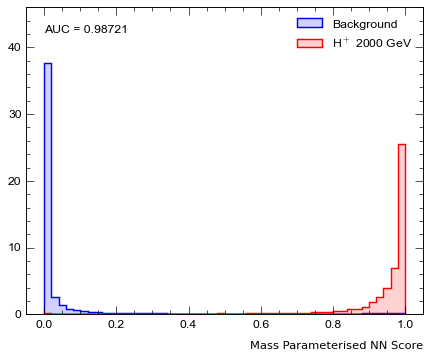

In [16]:
auc_everymass=[]

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'4vec_features',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

auc_everymass = np.array(auc_everymass)
auc_mass = auc_everymass[:,0]
auc_auc = auc_everymass[:,1]

with open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_new_training.json','w') as outputFile:
    json.dump({'Hp mass':list(auc_mass), 'AUC':list(auc_auc)}, outputFile, sort_keys=True)

(977067, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(978810, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980083, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980617, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(981324, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980383, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980821, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980204, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(981081,

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

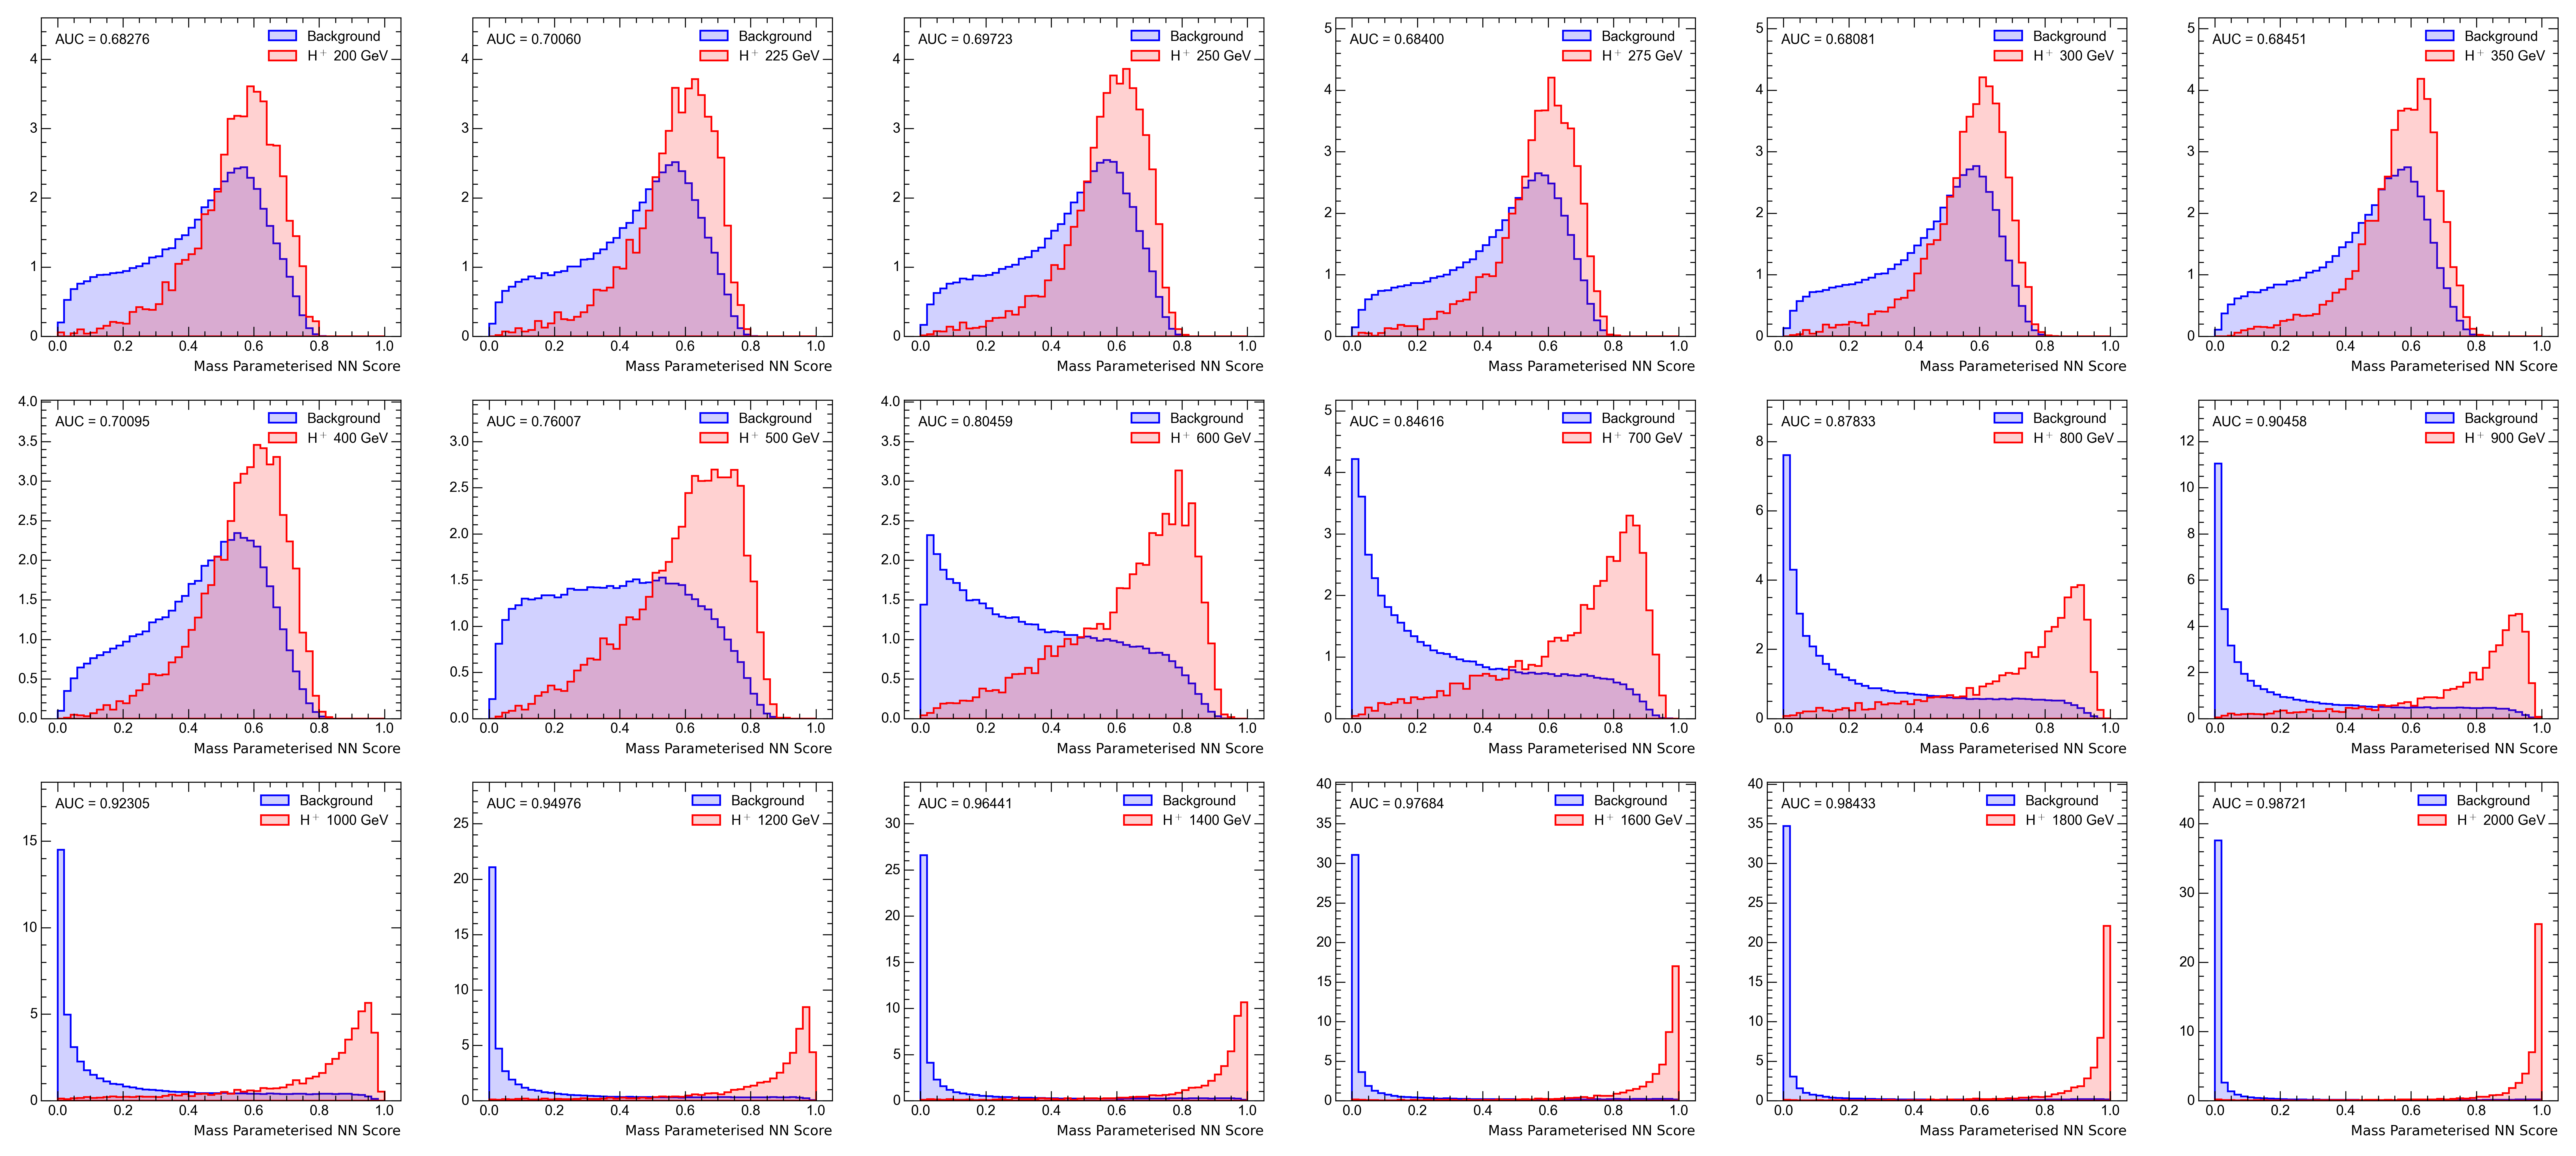

In [17]:
i=1
path = '/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training'
plt.rcParams["axes.linewidth"]= 0.4
plt.subplots_adjust(right=0.98,left=0.02,top=0.8, bottom=0.1, wspace=0, hspace=0.3)
plt.figure(figsize=(18,7.5),linewidth=0,dpi=600)

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:        
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        #Getting the data we want to plot
        y_pred = modelNN.model.predict(X_test.values).ravel()
        roc_auc = roc_auc_score(y_test,y_pred,sample_weight=w_test)
        false_pr, true_pr, thresholds = roc_curve(y_test, y_pred, sample_weight = w_test)
        
        #Plotting Score
        plt.subplot(3,6,i)

        plt.hist(y_pred[y_test<0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w_test[y_test<0.5], fc=(0.,0.,1.,0.18), ec="blue", linewidth=.7, density=True, label="Background")
        plt.hist(y_pred[y_test>0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w_test[y_test>0.5], fc=(1.,0.,0.,0.18), ec="red", linewidth=.7, density=True, label="H$^+$ {} GeV".format(mass))

        plt.xlabel("Mass Parameterised NN Score", ha="right",x=1, fontsize=5.5, labelpad=2.8)

        plt.minorticks_on()
        plt.tick_params(axis="both", which="major", width=.4, length=3.8, pad=1.5)
        plt.tick_params(axis="both", which="minor", width=.4, length=2, pad=1.5)

        plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=5.6))
        plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=5.6))

        plt.xlim(-.05,1.05)
        plt.ylim(0, plt.gca().get_ylim()[1]*1.15 )

        plt.legend(loc="best", frameon=False, prop=fm.FontProperties(fname=fpath,size=5.5))
        
        # Print AUC at the corner
        ax = plt.gca()
        plt.text(0.17,0.93,'AUC = {:.5f}'.format(roc_auc), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes,fontproperties=fm.FontProperties(fname=fpath,size=5.5))
        
        i+=1
        
plt.savefig(path + '/NN_Score_multiplot_' + region + '_' + '4vecfeatures_baseline' + '.png',dpi=600,bbox_inches='tight',orientation='landscape')
plt.show

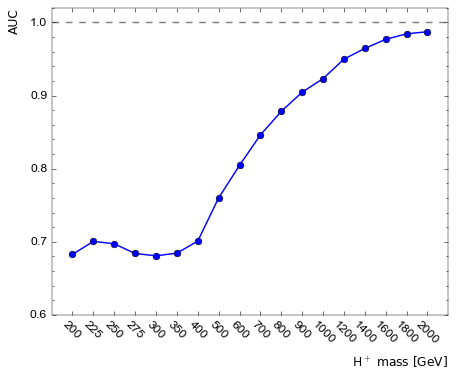

In [18]:
AUCvsHpmass(auc_auc,auc_mass,region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','4vec_features')

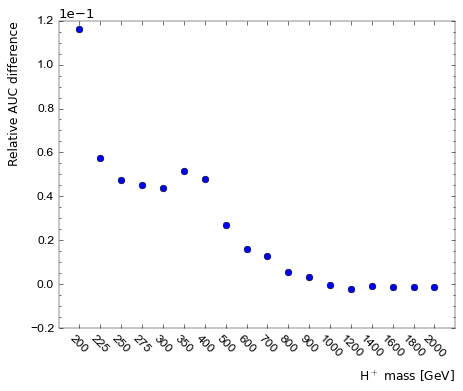

In [19]:
relativeAUC(auc_everymass[:,1],'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_actual_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','4vec_features_realtive')

In [26]:
print(auc_everymass)

[[2.00000000e+02 6.81751877e-01]
 [2.25000000e+02 7.00969242e-01]
 [2.50000000e+02 6.92961800e-01]
 [2.75000000e+02 6.81515074e-01]
 [3.00000000e+02 6.79562512e-01]
 [3.50000000e+02 6.86123362e-01]
 [4.00000000e+02 6.99988335e-01]
 [5.00000000e+02 7.57355923e-01]
 [6.00000000e+02 8.01365008e-01]
 [7.00000000e+02 8.41711005e-01]
 [8.00000000e+02 8.74519871e-01]
 [9.00000000e+02 9.00338460e-01]
 [1.00000000e+03 9.18521763e-01]
 [1.20000000e+03 9.45851222e-01]
 [1.40000000e+03 9.61171710e-01]
 [1.60000000e+03 9.73999179e-01]
 [1.80000000e+03 9.81655798e-01]
 [2.00000000e+03 9.85221269e-01]]


## New hyperparameters

In [46]:
fpath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/arial.ttf")
fbipath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/ArialBoldItalic.ttf")
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.linewidth']= 0.85

feature_names = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_e1', 'jet_mv2c101', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_e2', 'jet_mv2c102', 'jet_pt3', 'jet_eta3', 'jet_phi3', 'jet_e3', 'jet_mv2c103', 'jet_pt4', 'jet_eta4', 'jet_phi4', 'jet_e4', 'jet_mv2c104', 'jet_pt5', 'jet_eta5', 'jet_phi5', 'jet_e5', 'jet_mv2c105', 'jet_pt6', 'jet_eta6', 'jet_phi6', 'jet_e6', 'jet_mv2c106','lepton_pt','lepton_phi','lepton_eta','lepton_e']
steps = ['msb','scl','rnd','wss']
region = "INC_ge6jge4b"
NNlayers = [128,128,128]
batchsize = 1024
dropout = 0.1
epochs = 300
patience = 5

In [4]:
df_new = pd.read_hdf("/nfs/at3/scratch/salvador/HplusML/HDFWriter/pandas_4vec/pandas_INC_ge6jgeq4b.h5")
df_new = df_new[(df_new.process!='Hp1001')&(df_new.process!='ttlight_aMCNloP8')&(df_new.process!='tH_new')&(df_new.weight!=0)&(df_new.hpmass!=2500)&(df_new.hpmass!=3000)]
df_new.head()

index  dRlepbb_MindR_70                                            jet_eta  \
0      0          1.632954  [-0.61083865, -0.38421518, 1.0957781, 0.209408...   
1      1          2.318960  [-0.6561383, -0.13251838, -0.52890044, -0.1273...   
2      2          0.870068  [2.381791, -1.3918624, 1.8041257, -1.0344955, ...   
3      3          3.142407  [0.9403318, 1.4658026, -0.07202754, 0.48571306...   
4      4          2.089809  [1.0356635, 2.0446057, -2.070395, 0.088136375,...   

   HpDiscriminant_275  HpNNv3_350  HpNNv3_600  HpDiscriminant_225  \
0            0.628027    0.464503    0.458725            0.473889   
1            0.677458    0.695016    0.305937            0.316257   
2            0.016884    0.098823    0.099795            0.092083   
3            0.621517    0.356497    0.042438            0.664618   
4            0.432156    0.172446    0.021674            0.574934   

          mu_eta   Muu_MindR_70    Mbb_MaxM_70  ...  Centrality_all  \
0   [0.66914076]  168296.703125  231522.750000  ...        0.739273   
1             []   57218.773438  200162.296875  ...        0.852112   
2  [-0.25464767]  110607.484375  333937.500000  ...        0.362028   
3             []   65231.687500  186417.437500  ...        0.654665   
4    [1.4766937]  448008.250000  130885.703125  ...        0.388816   

   HpNNv3_250    weight ReWeighting  process             group        region  \
0    0.436460  0.062751    1.017244  ttlight  t#bar{t} + light  INC_ge6jge4b   
1    0.681223  0.136305    0.996082  ttlight  t#bar{t} + light  INC_ge6jge4b   
2    0.191971  0.108638    1.010369  ttlight  t#bar{t} + light  INC_ge6jge4b   
3    0.563828  0.112889    1.029358  ttlight  t#bar{t} + light  INC_ge6jge4b   
4    0.330892  0.122123    1.118524  ttlight  t#bar{t} + light  INC_ge6jge4b   

   tagWeightBin_MV2c10_Continuous hpmass   year  
0              [1, 4, 5, 4, 2, 4]     -1  mc16a  
1              [5, 5, 4, 4, 1, 1]     -1  mc16a  
2              [5, 1, 4, 1, 5, 4]     -1  mc16a  
3              [5, 1, 4, 5, 4, 1]     -1  mc16a  
4              [5, 1, 1, 5, 4, 5]     -1  mc16a  

[5 rows x 77 columns]

In [5]:
columns_suffix= ['pt','eta','phi','e']

for s in columns_suffix:
    df_new['el_'+s]=pd.DataFrame(df_new['el_'+s].tolist(), index= df_new.index)
    df_new['mu_'+s]=pd.DataFrame(df_new['mu_'+s].tolist(), index= df_new.index)
    df_new.loc[np.isnan(df_new['el_'+s])==False,'lepton_'+s]=df_new[np.isnan(df_new['el_'+s])==False]['el_'+s]
    df_new.loc[np.isnan(df_new['mu_'+s])==False,'lepton_'+s]=df_new[np.isnan(df_new['mu_'+s])==False]['mu_'+s]

In [6]:
#There are some events with more than 6 components on jet_e, we cut the extra components
def jet_e_components(row):    
    ''' Function to get only the first 6 components of jet_e lists'''
    if len(row.jet_e)>6: 
        return row['jet_e'][:6]
    else: 
        return row['jet_e']
    
df_new['jet_e'] = df_new.apply (lambda row: jet_e_components(row), axis=1)

In [13]:
data = PrepareMassParametrised(df_new, feature_names, steps_names=steps)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit = data[2]

msb:
Background integral: 0.5 
Signal integral: 0.5 

scl:
Background integral: 0.5 
Signal integral: 0.5 

-1 1134182    3.564395e-08
63564      1.238117e-06
1376655    4.716239e-08
1116034    1.178930e-11
85513      6.783175e-07
               ...     
773653     6.509096e-07
1650183    1.653604e-07
1401201    1.947045e-08
1591320    5.042264e-08
1014801    5.554679e-07
Name: weight, Length: 973135, dtype: float64 0.5
200 1949727    0.000015
1952077    0.000011
1948948    0.000018
1949156    0.000019
1950513    0.000021
             ...   
1951659    0.000016
1951691    0.000028
1948311    0.000017
1950098    0.000018
1949061    0.000018
Name: weight, Length: 2100, dtype: float64 0.04405286343612336
225 1957651    3.388339e-06
1957494    7.660917e-06
1958522    4.776432e-06
1957951    7.743244e-06
1955832    5.695298e-06
               ...     
1954153    4.811665e-06
1956217    5.900147e-06
1956961    6.349497e-06
1958917    4.241294e-06
1958085    5.291226e-09
Name: weight, Length:

In [14]:
del df_new

In [ ]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'new_hyperpar',region)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4608      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [ ]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'new_hyperpar')

In [ ]:
auc_everymass=[]

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names + ['HpDiscriminant_'+str(mass)])
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'new_hyperpar',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

auc_everymass = np.array(auc_everymass)
auc_mass = auc_everymass[:,0]
auc_auc = auc_everymass[:,1]

with open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_new_training_new_hyperpar.json','w') as outputFile:
    json.dump({'Hp mass':list(auc_mass), 'AUC':list(auc_auc)}, outputFile, sort_keys=True)

In [ ]:
AUCvsHpmass(auc_auc,auc_mass,region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','new_hyperpar')

In [ ]:
relativeAUC(np.array(auc_auc),'auc_actual_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','new_hyperpar_relative')

In [ ]:
relativeAUC(np.array(auc_auc),'auc_new_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','new_hyperpar_4vec_comparison')

In [ ]:
print(auc_everymass)

Now we will try an intermediate NN

In [7]:
fpath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/arial.ttf")
fbipath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/ArialBoldItalic.ttf")
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.linewidth']= 0.85

feature_names = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_m1', 'jet_mv2c101', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_m2', 'jet_mv2c102', 'jet_pt3', 'jet_eta3', 'jet_phi3', 'jet_m3', 'jet_mv2c103', 'jet_pt4', 'jet_eta4', 'jet_phi4', 'jet_m4', 'jet_mv2c104', 'jet_pt5', 'jet_eta5', 'jet_phi5', 'jet_m5', 'jet_mv2c105', 'jet_pt6', 'jet_eta6', 'jet_phi6', 'jet_m6', 'jet_mv2c106','lepton_pt','lepton_phi','lepton_eta','met_met','met_phi']
steps = ['msb','scl','rnd','wss']
region = "INC_ge6jge4b"
NNlayers = [128,128,128]
batchsize = 512
dropout = 0.1
epochs = 300
patience = 5

In [13]:
df_new = pd.read_feather('/nfs/pic.es/user/s/srodrigu/Jupyter/pandas_files/pandas_INC_ge6jgeq4b.feather')

In [9]:
data = PrepareMassParametrised(df_new, feature_names, steps_names=steps, onediscr=False)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit = data[2]
del(df_new)

msb:
Background integral: 0.5000000000000001 
Signal integral: 0.5 

scl:
Background integral: 0.5000000000000001 
Signal integral: 0.5000000000000001 

-1 1942133    2.113674e-07
1636581    2.093343e-07
1839581    1.470414e-07
1602098    4.447223e-08
1591364    4.025891e-08
               ...     
773654     6.444582e-07
1650185    1.893742e-07
1401201    5.034874e-08
1591320    3.677423e-08
1014802    7.224909e-07
Name: weight, Length: 973134, dtype: float64 0.5000000000000001
200 1950775    0.000022
1949967    0.000028
1950451    0.000015
1952146    0.000027
1951592    0.000034
             ...   
1951660    0.000024
1951692    0.000021
1948311    0.000021
1950101    0.000023
1949062    0.000021
Name: weight, Length: 2100, dtype: float64 0.04405286343612335
225 1959401    0.000004
1953820    0.000004
1957932    0.000007
1952456    0.000006
1956420    0.000006
             ...   
1954155    0.000005
1956217    0.000004
1956965    0.000005
1958919    0.000006
1958085    0.000006
Name:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4736      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

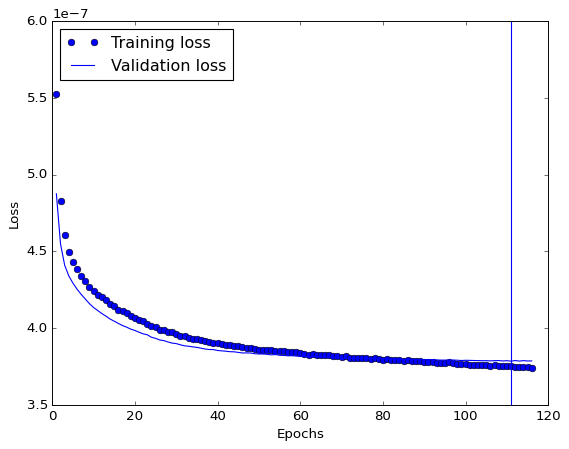

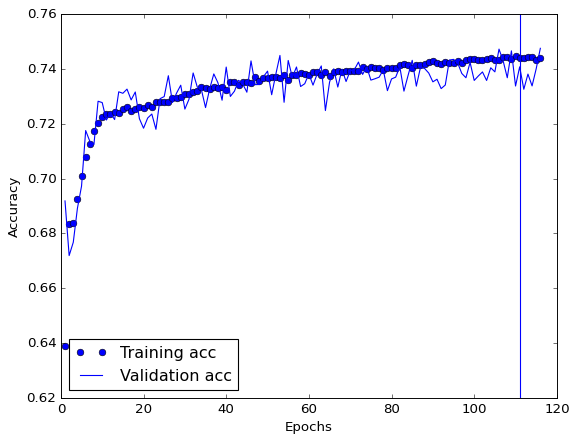

2021-04-19 17:34:50.652763: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-04-19 17:34:50.728646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-04-19 17:34:50.729736: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-04-19 17:34:50.733846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-19 17:34:50.737289: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-04-19 17:34:50.738183: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

In [10]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'new_hyperpar',region)

In [23]:
#Load the NN
json_file = open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_arch_'+ region +'_'+ 'new_hyperpar'+'.h5')
loaded_model_json = json_file.read()
json_file.close()

modelNN = model_from_json(loaded_model_json)
modelNN.load_weights('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_weights_'+ region +'_'+ 'new_hyperpar'+'.h5')

0.8837344722778183

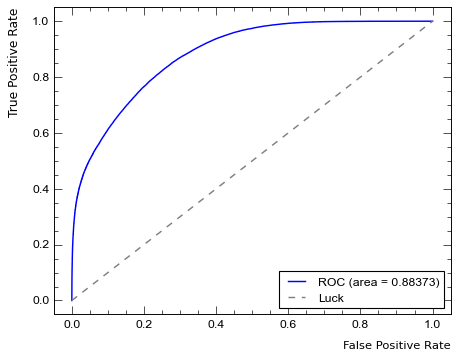

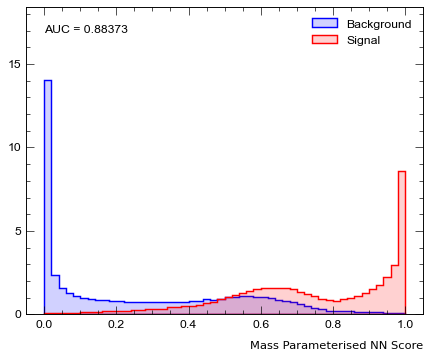

In [11]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'new_hyperpar_512')

(977067, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(978810, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980083, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980617, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(981324, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980383, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980821, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980204, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(981081,

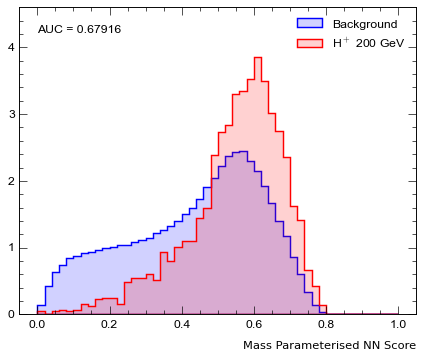

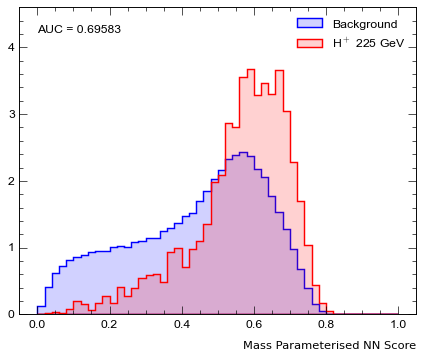

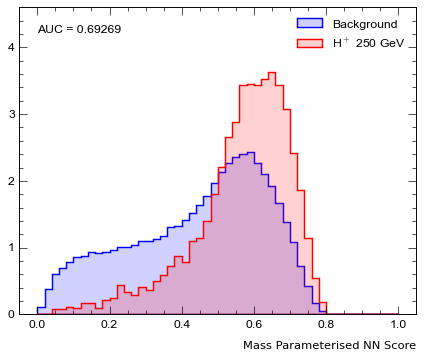

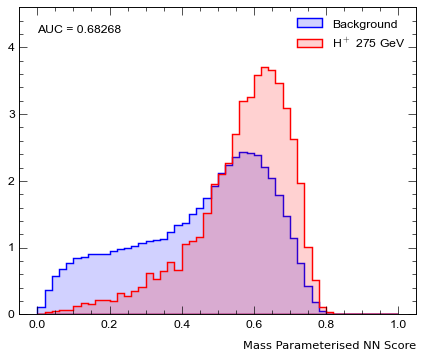

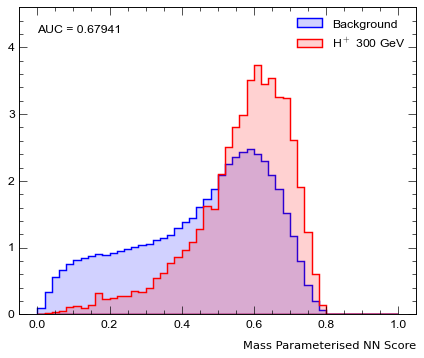

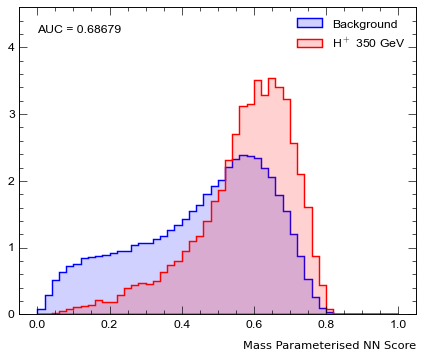

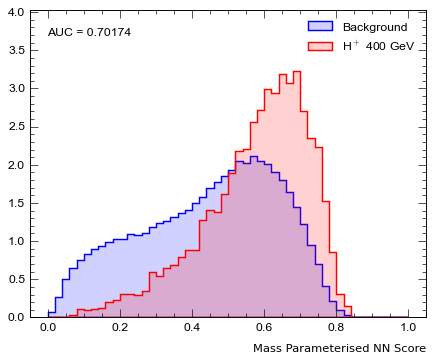

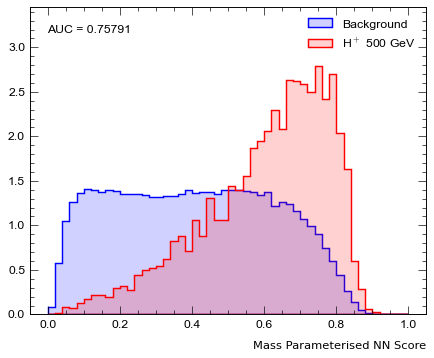

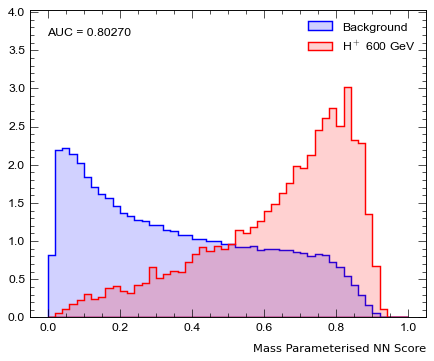

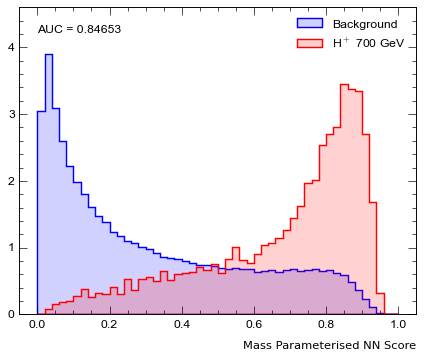

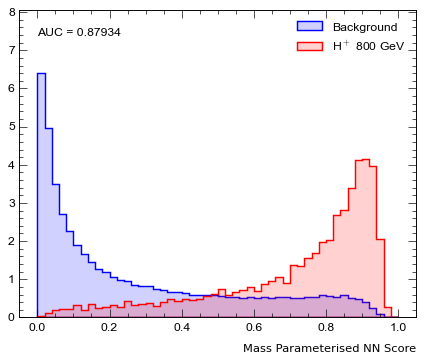

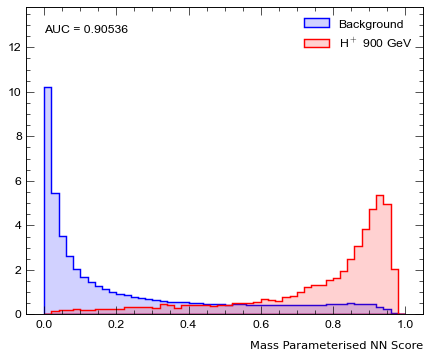

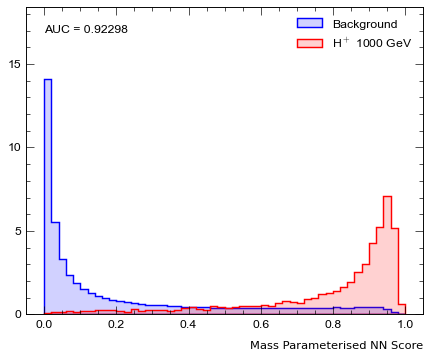

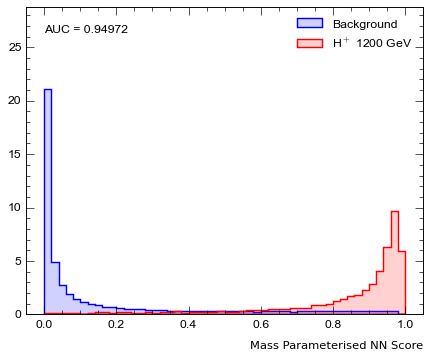

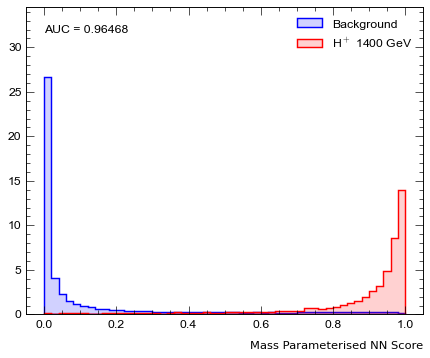

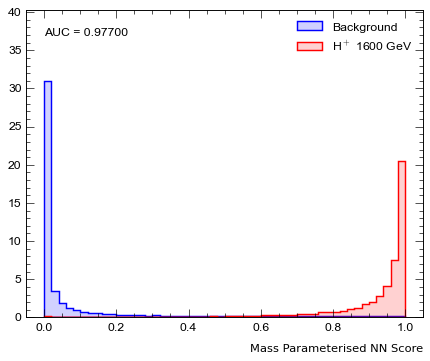

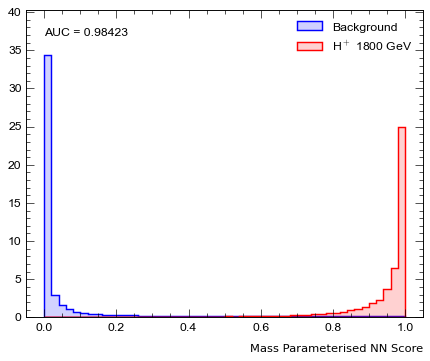

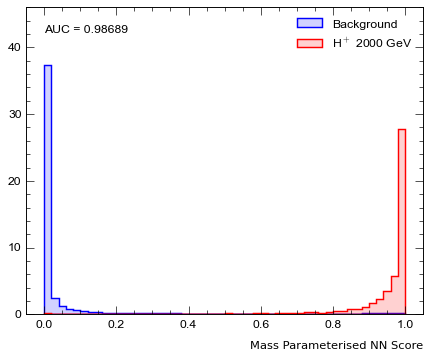

In [14]:
auc_everymass=[]

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'new_hyperpar_512',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

auc_everymass = np.array(auc_everymass)
auc_mass = auc_everymass[:,0]
auc_auc = auc_everymass[:,1]

with open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_new_training_new_hyperpar_512.json','w') as outputFile:
    json.dump({'Hp mass':list(auc_mass), 'AUC':list(auc_auc)}, outputFile, sort_keys=True)

(977067, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(978810, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980083, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980617, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(981324, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980383, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980821, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980204, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(981081,

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

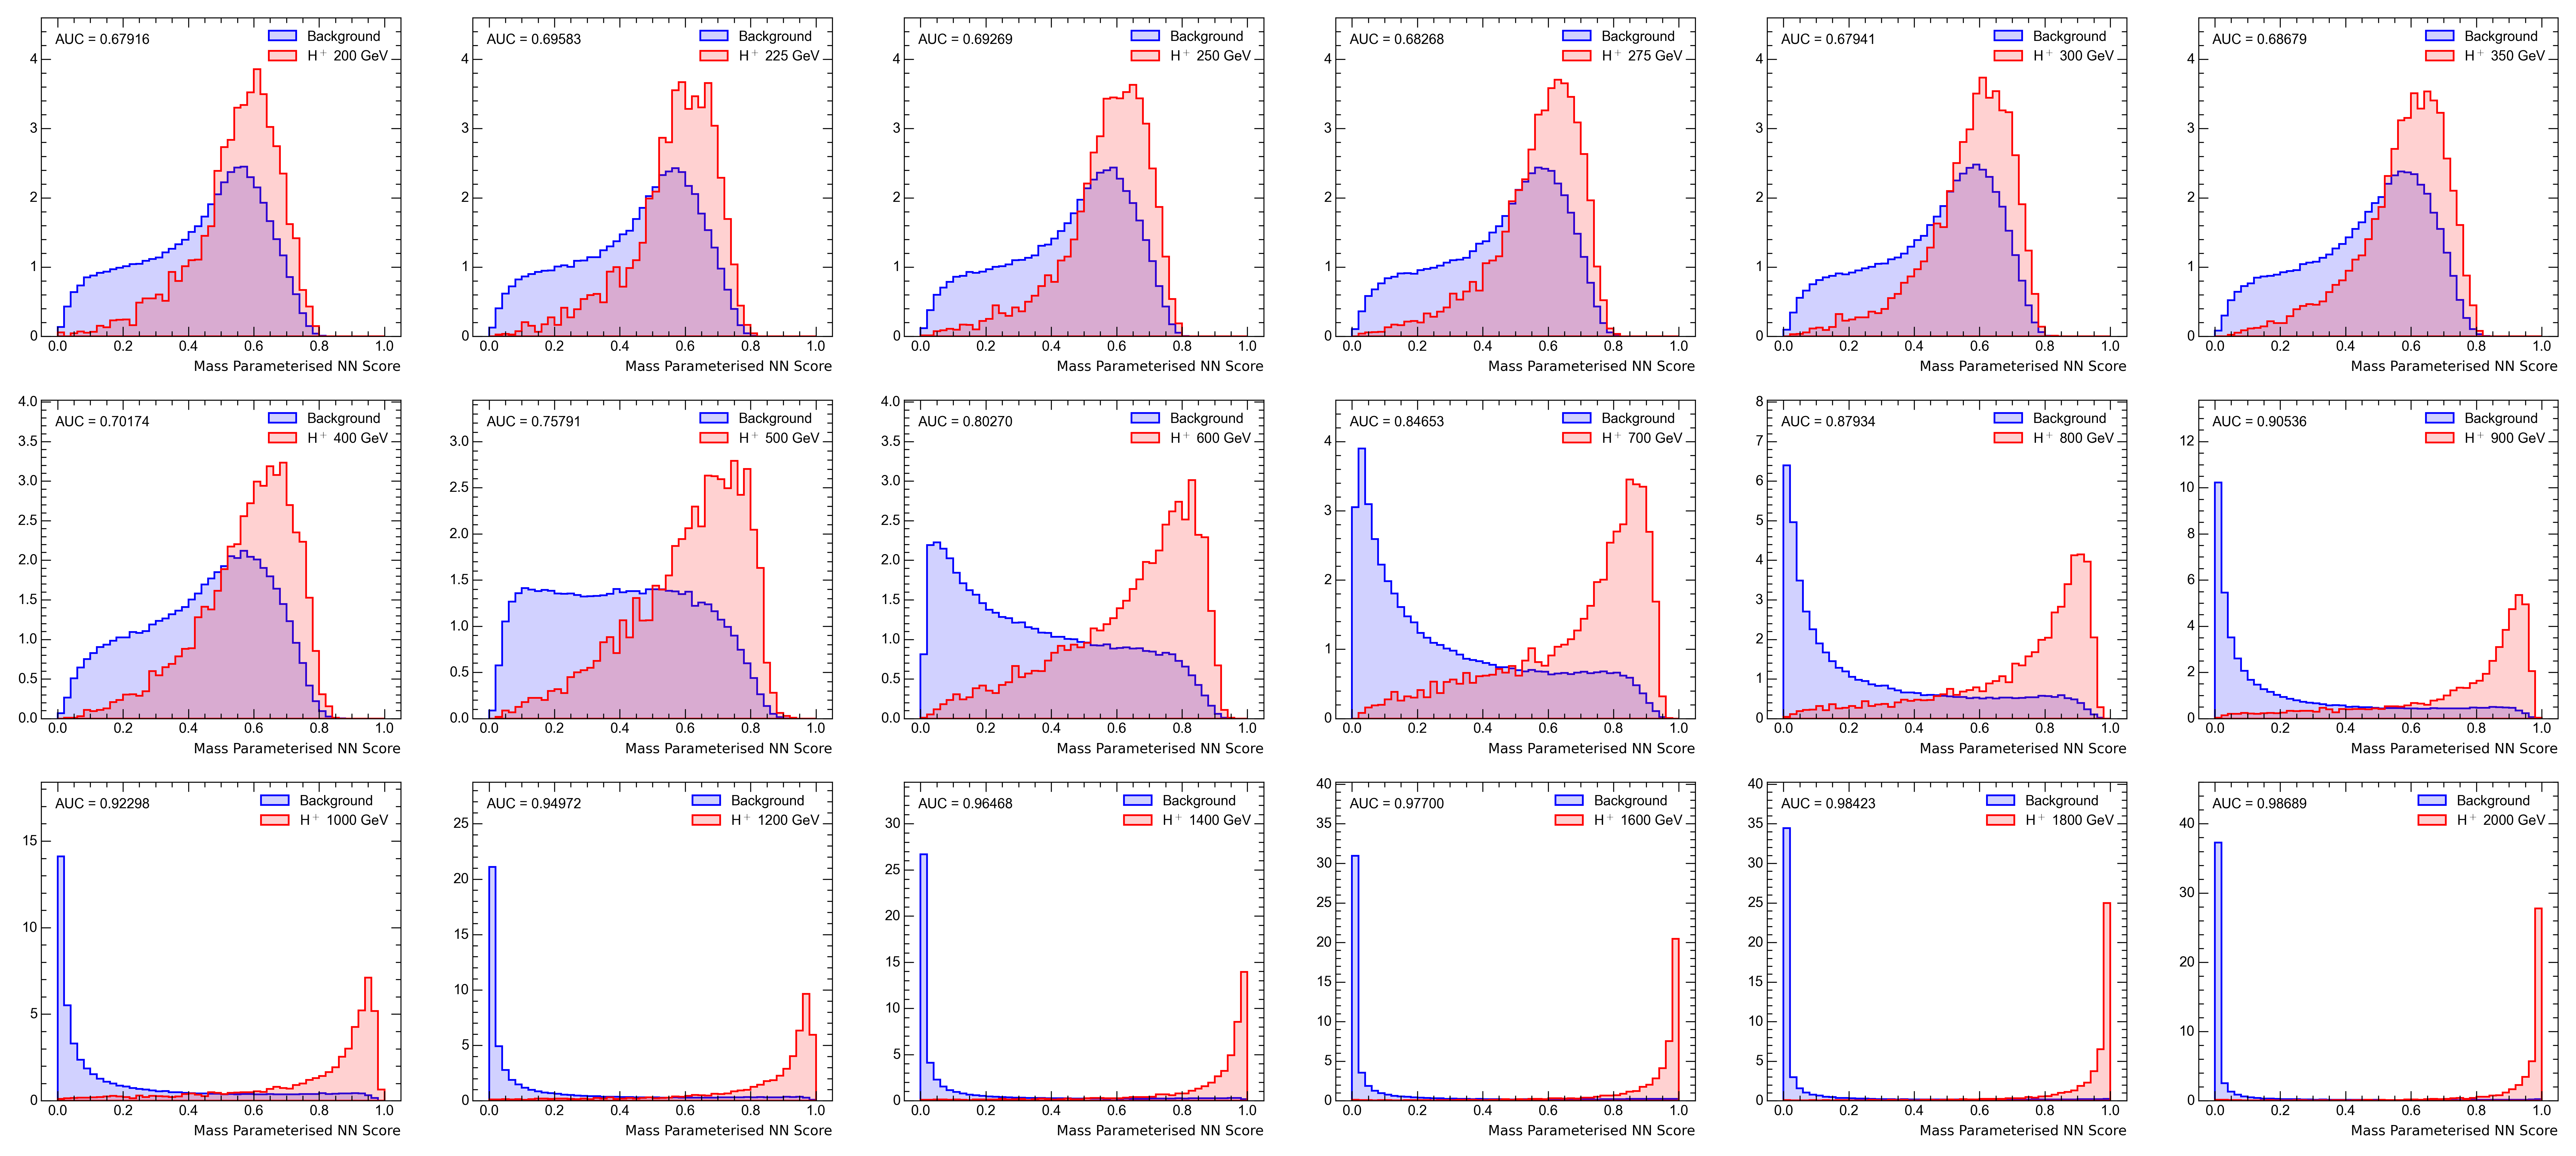

In [15]:
i=1
path = '/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training'
plt.rcParams["axes.linewidth"]= 0.4
plt.subplots_adjust(right=0.98,left=0.02,top=0.8, bottom=0.1, wspace=0, hspace=0.3)
plt.figure(figsize=(18,7.5),linewidth=0,dpi=600)

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:        
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        #Getting the data we want to plot
        y_pred = modelNN.model.predict(X_test.values).ravel()
        roc_auc = roc_auc_score(y_test,y_pred,sample_weight=w_test)
        false_pr, true_pr, thresholds = roc_curve(y_test, y_pred, sample_weight = w_test)
        
        #Plotting Score
        plt.subplot(3,6,i)

        plt.hist(y_pred[y_test<0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w_test[y_test<0.5], fc=(0.,0.,1.,0.18), ec="blue", linewidth=.7, density=True, label="Background")
        plt.hist(y_pred[y_test>0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w_test[y_test>0.5], fc=(1.,0.,0.,0.18), ec="red", linewidth=.7, density=True, label="H$^+$ {} GeV".format(mass))

        plt.xlabel("Mass Parameterised NN Score", ha="right",x=1, fontsize=5.5, labelpad=2.8)

        plt.minorticks_on()
        plt.tick_params(axis="both", which="major", width=.4, length=3.8, pad=1.5)
        plt.tick_params(axis="both", which="minor", width=.4, length=2, pad=1.5)

        plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=5.6))
        plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=5.6))

        plt.xlim(-.05,1.05)
        plt.ylim(0, plt.gca().get_ylim()[1]*1.15 )

        plt.legend(loc="best", frameon=False, prop=fm.FontProperties(fname=fpath,size=5.5))
        
        # Print AUC at the corner
        ax = plt.gca()
        plt.text(0.17,0.93,'AUC = {:.5f}'.format(roc_auc), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes,fontproperties=fm.FontProperties(fname=fpath,size=5.5))
        
        i+=1
        
plt.savefig(path + '/NN_Score_multiplot_' + region + '_' + '512_batchsize' + '.png',dpi=600,bbox_inches='tight',orientation='landscape')
plt.show

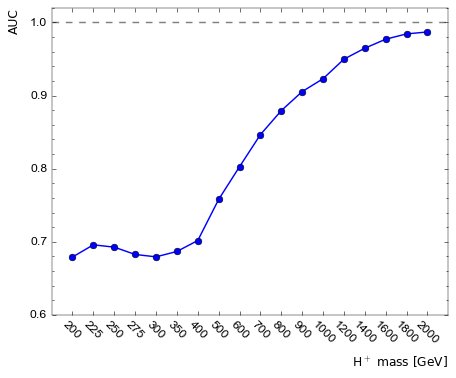

In [16]:
AUCvsHpmass(auc_auc,auc_mass,region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','new_hyperpar_512')

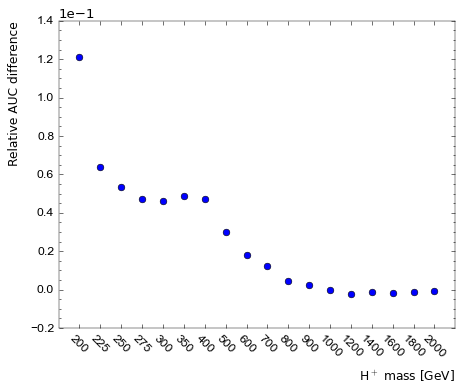

In [17]:
relativeAUC(np.array(auc_auc),'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_actual_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','new_hyperpar_relative_512')

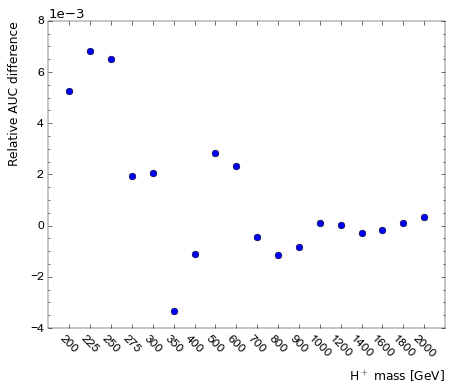

In [18]:
relativeAUC(np.array(auc_auc),'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_new_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','new_hyperpar_4vec_comparison_512')

In [20]:
print(auc_everymass)

[[2.00000000e+02 6.79161490e-01]
 [2.25000000e+02 6.95833887e-01]
 [2.50000000e+02 6.92690238e-01]
 [2.75000000e+02 6.82683149e-01]
 [3.00000000e+02 6.79414980e-01]
 [3.50000000e+02 6.86787851e-01]
 [4.00000000e+02 7.01735033e-01]
 [5.00000000e+02 7.57912388e-01]
 [6.00000000e+02 8.02702860e-01]
 [7.00000000e+02 8.46529156e-01]
 [8.00000000e+02 8.79341441e-01]
 [9.00000000e+02 9.05355995e-01]
 [1.00000000e+03 9.22978100e-01]
 [1.20000000e+03 9.49724699e-01]
 [1.40000000e+03 9.64682634e-01]
 [1.60000000e+03 9.77000882e-01]
 [1.80000000e+03 9.84231616e-01]
 [2.00000000e+03 9.86886036e-01]]


## Adding 1 low level feature

At this point we want to include some high level features and see how this affects to the training.

In [7]:
fpath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/arial.ttf")
fbipath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/ArialBoldItalic.ttf")
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.linewidth']= 0.85

feature_names = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_m1', 'jet_mv2c101', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_m2', 'jet_mv2c102', 'jet_pt3', 'jet_eta3', 'jet_phi3', 'jet_m3', 'jet_mv2c103', 'jet_pt4', 'jet_eta4', 'jet_phi4', 'jet_m4', 'jet_mv2c104', 'jet_pt5', 'jet_eta5', 'jet_phi5', 'jet_m5', 'jet_mv2c105', 'jet_pt6', 'jet_eta6', 'jet_phi6', 'jet_m6', 'jet_mv2c106','lepton_pt','lepton_phi','lepton_eta','met_met','met_phi','HT_jets']
exclude_columns = feature_names[:-1]
steps = ['msb','scl','rnd','fd','wss']
region = "INC_ge6jge4b"
NNlayers = [64,64]
batchsize = 50
dropout = 0.1
epochs = 300
patience = 5

In [8]:
df_new = pd.read_feather('/nfs/pic.es/user/s/srodrigu/Jupyter/pandas_files/pandas_INC_ge6jgeq4b.feather')

In [9]:
data = PrepareMassParametrised(df_new, feature_names, steps_names=steps, exclude_columns=exclude_columns, onediscr=False)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit = data[2]

msb:
Background integral: 0.5000000000000001 
Signal integral: 0.5 

scl:
Background integral: 0.5000000000000001 
Signal integral: 0.5000000000000001 

-1 1942133    2.113674e-07
1636581    2.093343e-07
1839581    1.470414e-07
1602098    4.447223e-08
1591364    4.025891e-08
               ...     
773654     6.444582e-07
1650185    1.893742e-07
1401201    5.034874e-08
1591320    3.677423e-08
1014802    7.224909e-07
Name: weight, Length: 973134, dtype: float64 0.5000000000000001
200 1950775    0.000022
1949967    0.000028
1950451    0.000015
1952146    0.000027
1951592    0.000034
             ...   
1951660    0.000024
1951692    0.000021
1948311    0.000021
1950101    0.000023
1949062    0.000021
Name: weight, Length: 2100, dtype: float64 0.04405286343612335
225 1959401    0.000004
1953820    0.000004
1957932    0.000007
1952456    0.000006
1956420    0.000006
             ...   
1954155    0.000005
1956217    0.000004
1956965    0.000005
1958919    0.000006
1958085    0.000006
Name:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2496      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,721
Trainable params: 6,721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
21740/21740 [==============================] - 109s 5ms/step - loss: 4.4676e-07 - binary_accuracy: 0.7030 - 

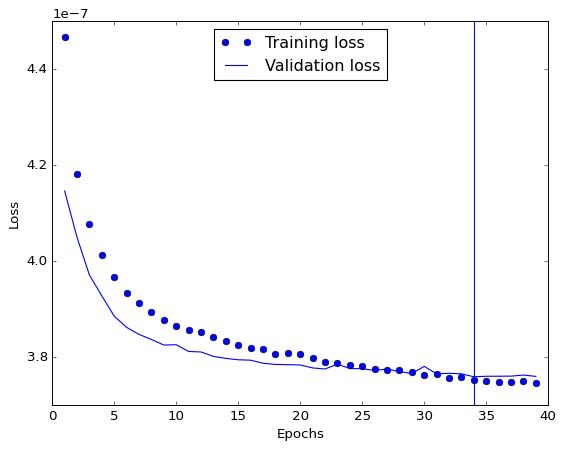

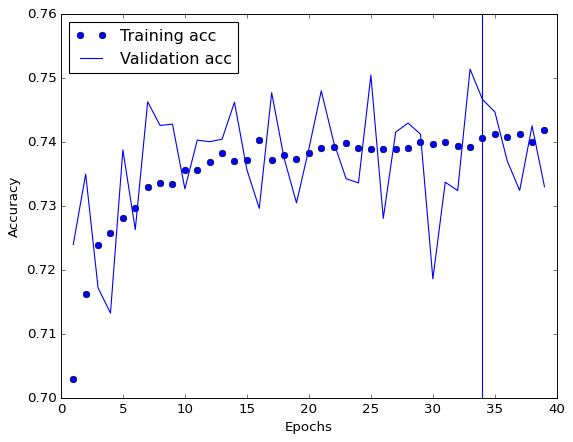

2021-04-19 09:10:02.978353: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-04-19 09:10:03.030168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-04-19 09:10:03.031012: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-04-19 09:10:03.057744: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-19 09:10:03.075323: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-04-19 09:10:03.079725: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

In [10]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'low_features_HTjets',region)

In [7]:
#Load the NN
json_file = open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_arch_'+ region +'_'+ 'low_features_HTjets'+'.h5')
loaded_model_json = json_file.read()
json_file.close()

modelNN = model_from_json(loaded_model_json)
modelNN.load_weights('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_weights_'+ region +'_'+ 'low_features_HTjets'+'.h5')

0.8855417673219754

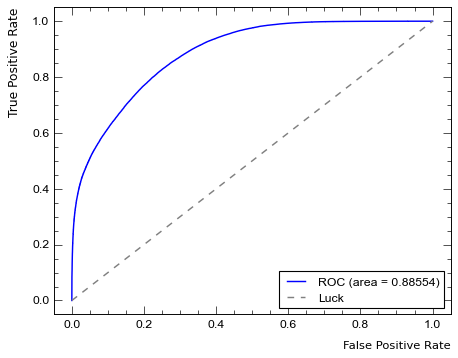

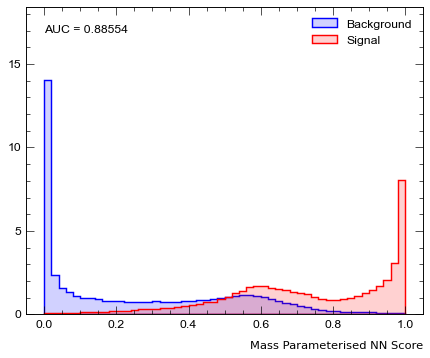

In [11]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'lowlvl_features_HTjets')

(977067, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(978810, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(980083, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(980617, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(981324, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(980383, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(980821, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(980204, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 

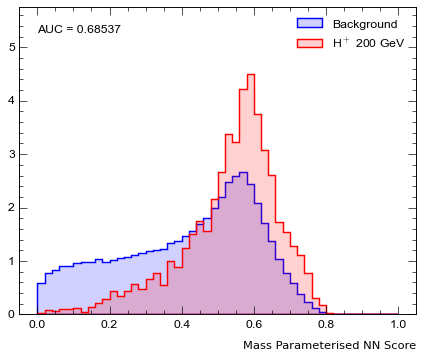

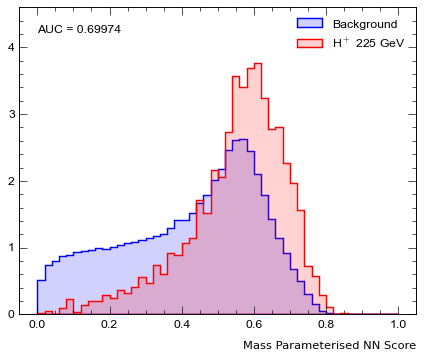

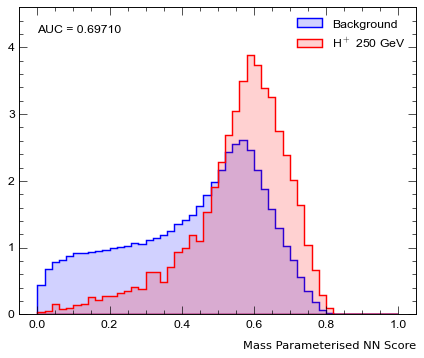

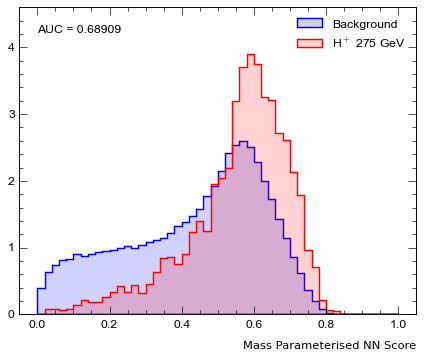

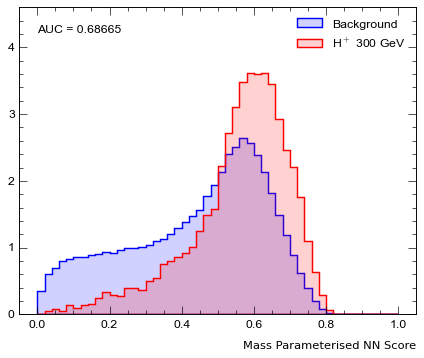

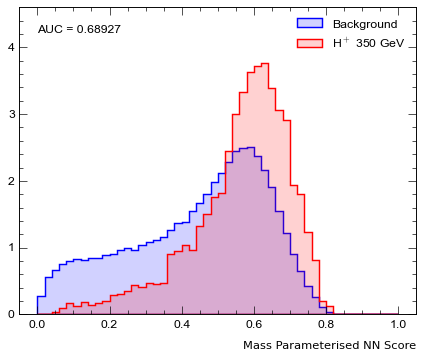

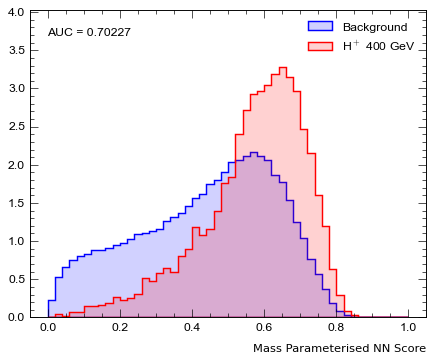

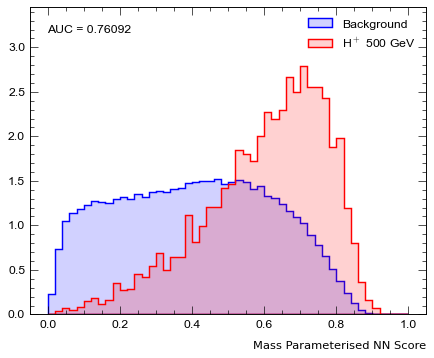

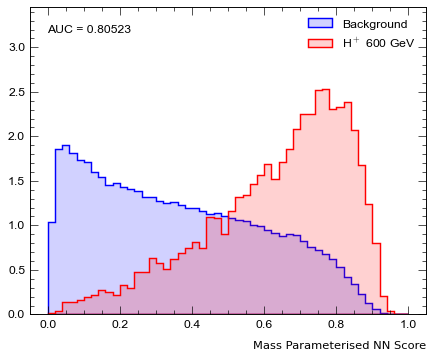

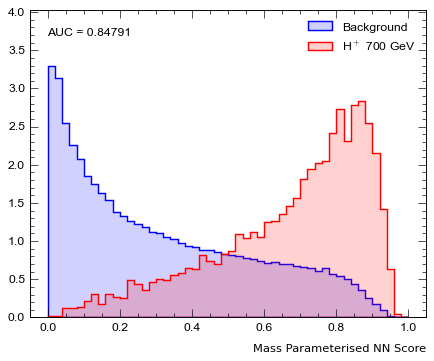

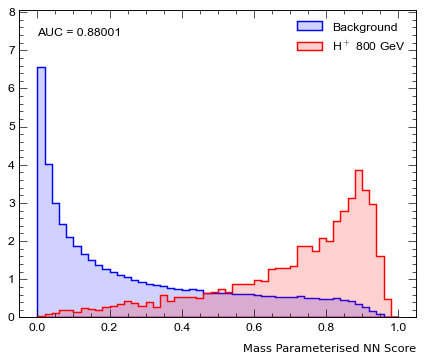

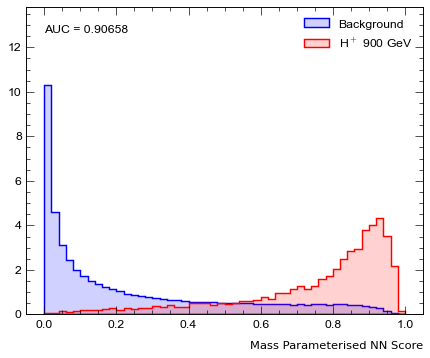

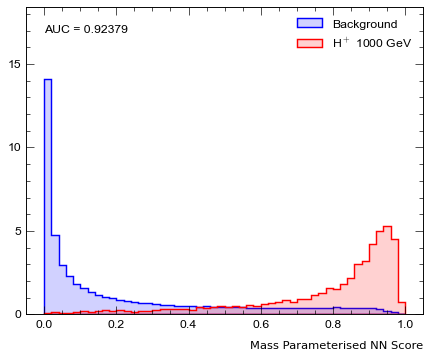

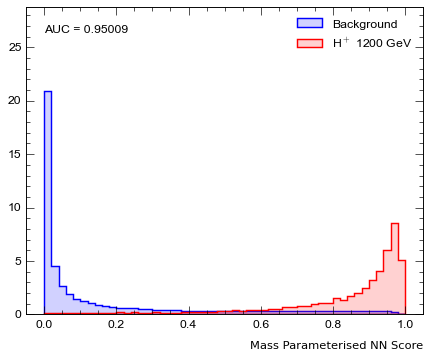

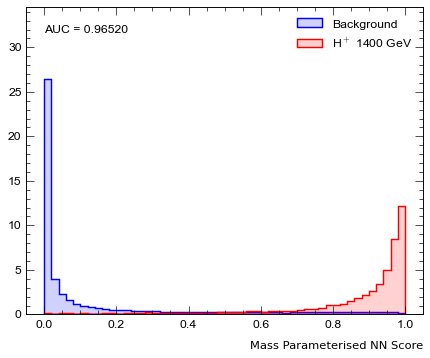

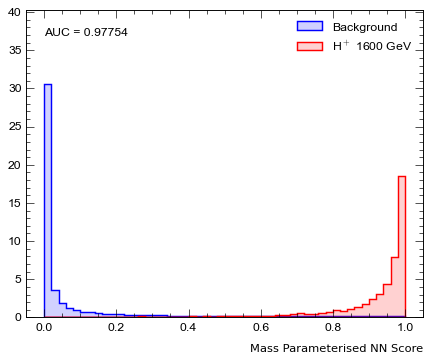

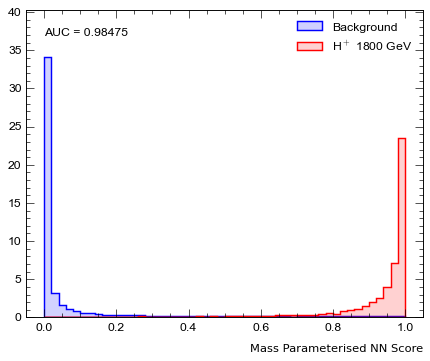

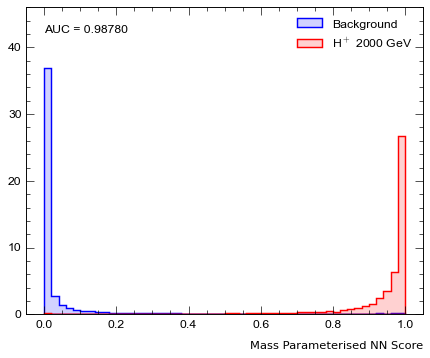

In [12]:
auc_everymass=[]

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
        fd = FeatureDivider("hpmass", excludecolumns=exclude_columns)
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass
        
        X_test, y_test, w_test = fd.transform(X_test,y_test, sample_weight=w_test)
        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'lowlvl_features_HTjets',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

auc_everymass = np.array(auc_everymass)
auc_mass = auc_everymass[:,0]
auc_auc = auc_everymass[:,1]

with open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_lowlvl_features_HTjets.json','w') as outputFile:
    json.dump({'Hp mass':list(auc_mass), 'AUC':list(auc_auc)}, outputFile, sort_keys=True)

(977067, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(978810, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(980083, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(980617, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(981324, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(980383, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(980821, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
(980204, 38) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

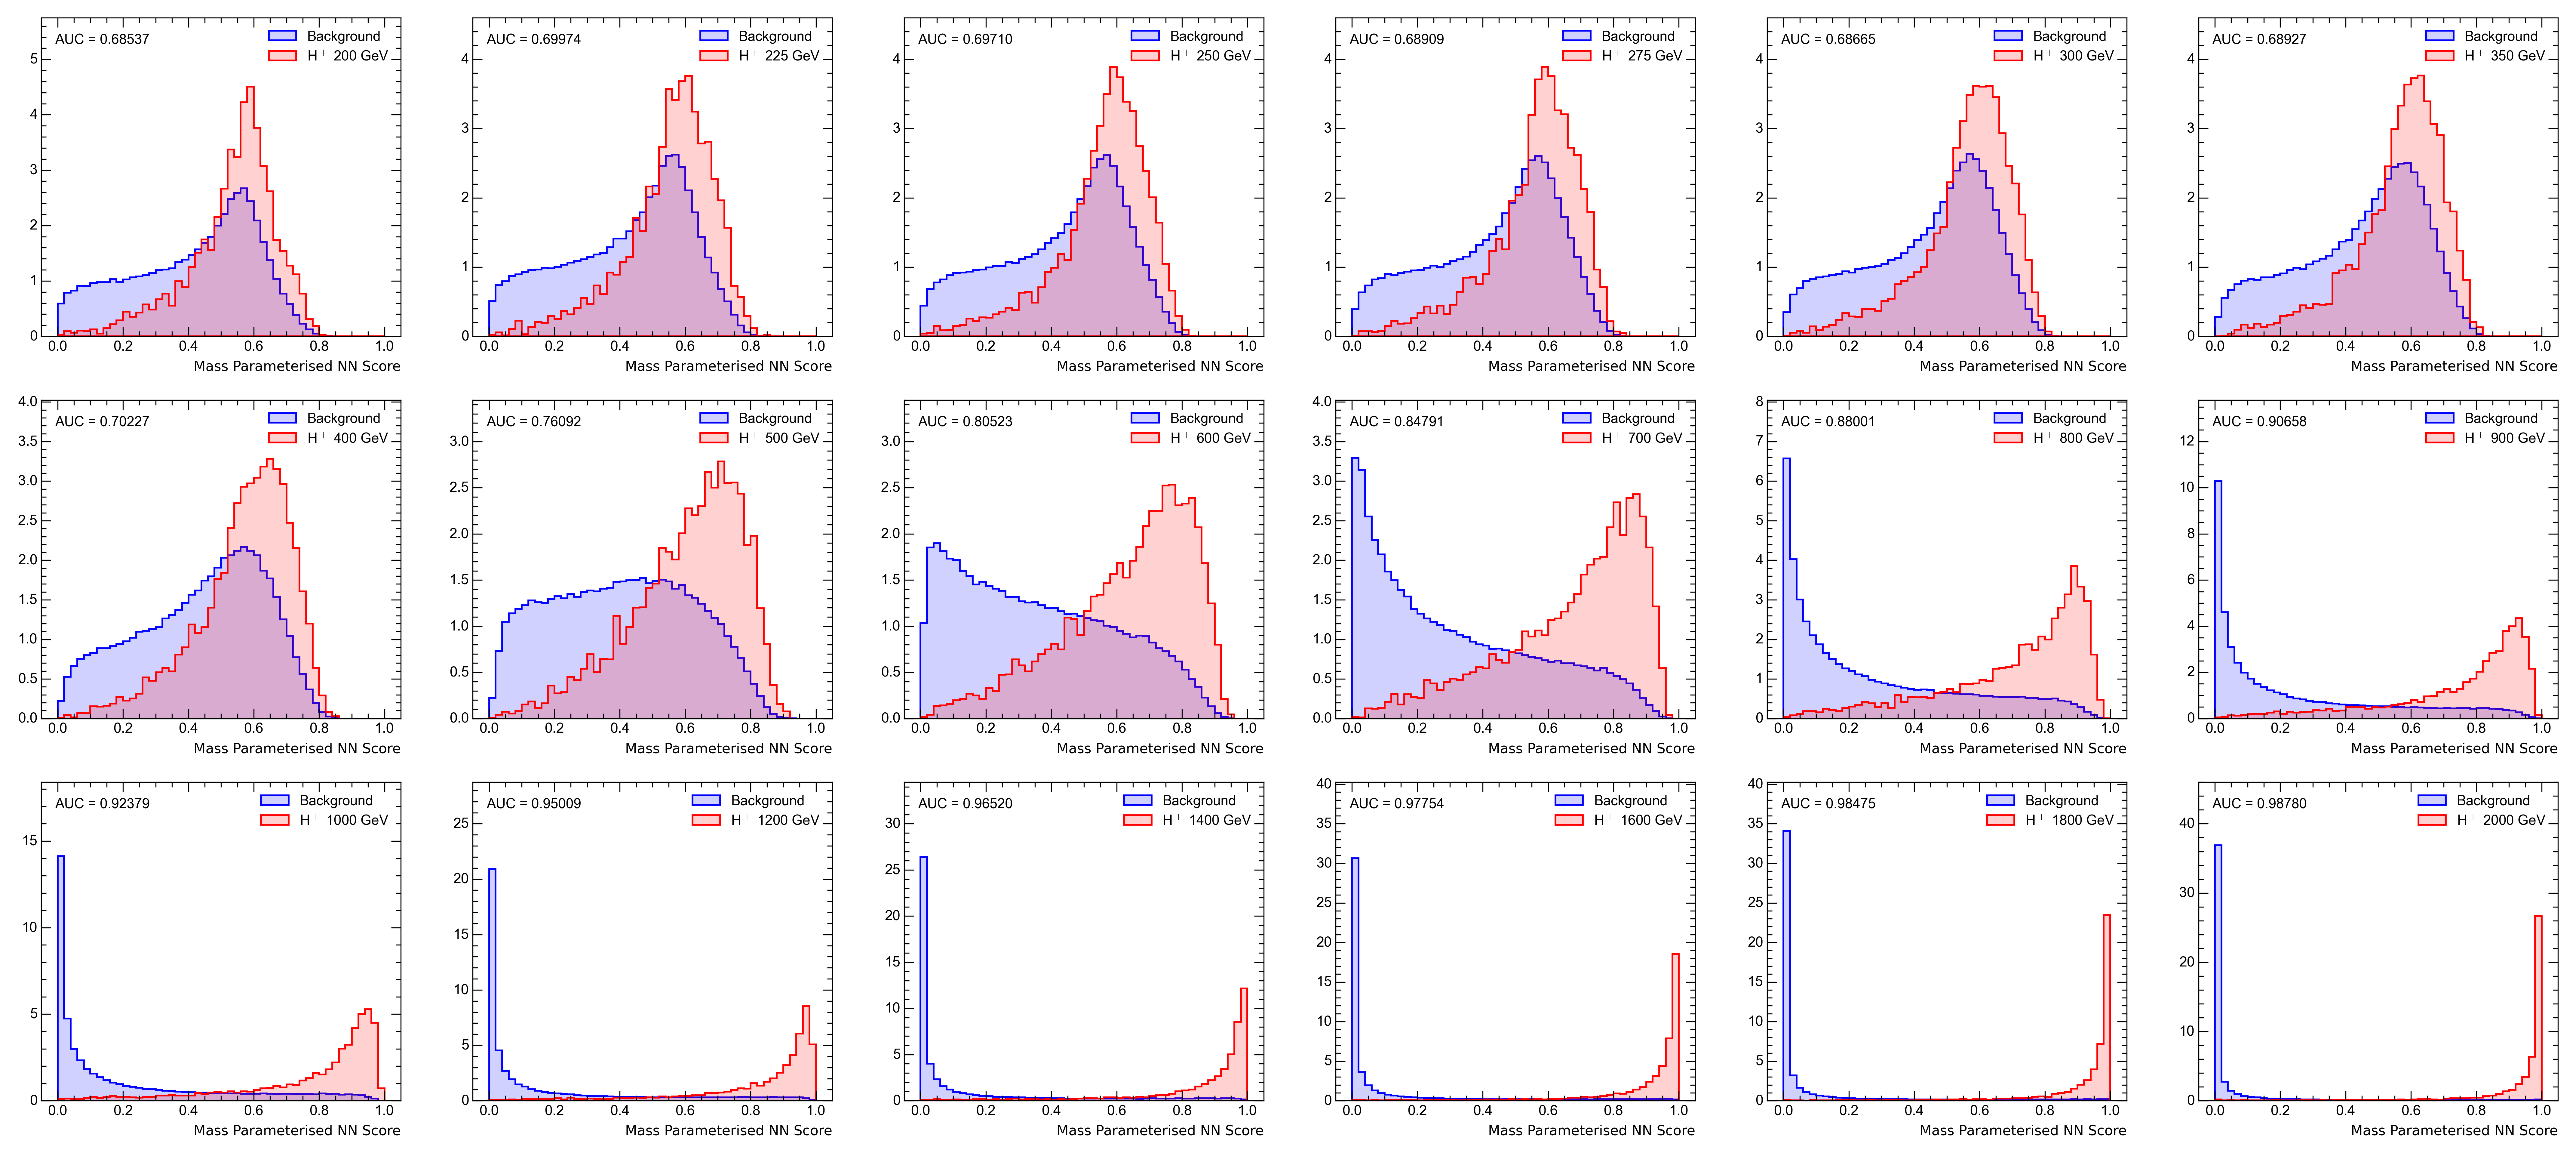

In [13]:
i=1
path = '/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training'
plt.rcParams["axes.linewidth"]= 0.4
plt.subplots_adjust(right=0.98,left=0.02,top=0.8, bottom=0.1, wspace=0, hspace=0.3)
plt.figure(figsize=(18,7.5),linewidth=0,dpi=600)

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:        
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
        fd = FeatureDivider("hpmass", excludecolumns=exclude_columns)
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = fd.transform(X_test,y_test, sample_weight=w_test)
        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        #Getting the data we want to plot
        y_pred = modelNN.model.predict(X_test.values).ravel()
        roc_auc = roc_auc_score(y_test,y_pred,sample_weight=w_test)
        false_pr, true_pr, thresholds = roc_curve(y_test, y_pred, sample_weight = w_test)
        
        #Plotting Score
        plt.subplot(3,6,i)

        plt.hist(y_pred[y_test<0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w_test[y_test<0.5], fc=(0.,0.,1.,0.18), ec="blue", linewidth=.7, density=True, label="Background")
        plt.hist(y_pred[y_test>0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w_test[y_test>0.5], fc=(1.,0.,0.,0.18), ec="red", linewidth=.7, density=True, label="H$^+$ {} GeV".format(mass))

        plt.xlabel("Mass Parameterised NN Score", ha="right",x=1, fontsize=5.5, labelpad=2.8)

        plt.minorticks_on()
        plt.tick_params(axis="both", which="major", width=.4, length=3.8, pad=1.5)
        plt.tick_params(axis="both", which="minor", width=.4, length=2, pad=1.5)

        plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=5.6))
        plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=5.6))

        plt.xlim(-.05,1.05)
        plt.ylim(0, plt.gca().get_ylim()[1]*1.15 )

        plt.legend(loc="best", frameon=False, prop=fm.FontProperties(fname=fpath,size=5.5))
        
        # Print AUC at the corner
        ax = plt.gca()
        plt.text(0.17,0.93,'AUC = {:.5f}'.format(roc_auc), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes,fontproperties=fm.FontProperties(fname=fpath,size=5.5))
        
        i+=1
        
plt.savefig(path + '/NN_Score_multiplot_' + region + '_' + 'low_and_highlvl' + '.png',dpi=600,bbox_inches='tight',orientation='landscape')
plt.show

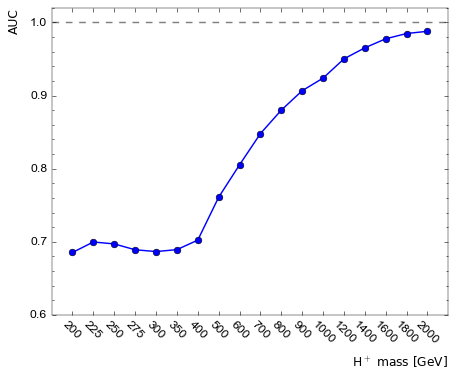

In [14]:
AUCvsHpmass(auc_auc,auc_mass,region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','lowlvl_features_HTjets')

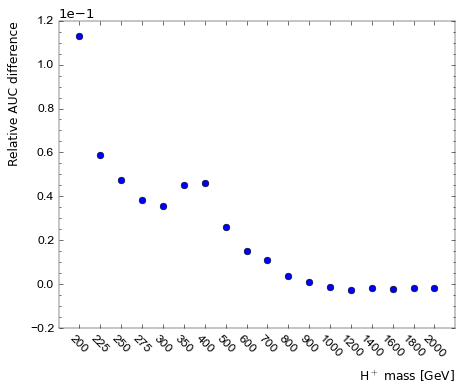

In [15]:
relativeAUC(auc_everymass[:,1],'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_actual_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','lowlvl_features_HTjets_realtive')

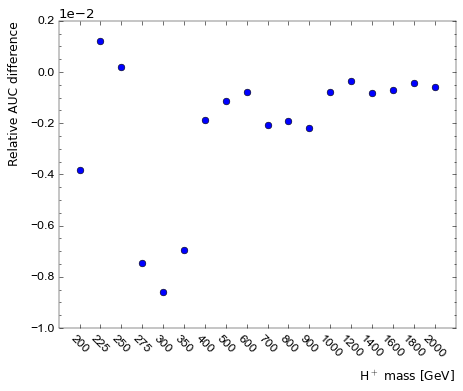

In [16]:
relativeAUC(np.array(auc_auc),'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_new_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','HT_jets_4vec_comparison')

## Symmetry considerations

Now we will apply some transformations to _phi_ and _eta_ variables in order to take into account the symmetries of the CERN collider so de NN doesn't has to.

In [7]:
fpath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/arial.ttf")
fbipath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/ArialBoldItalic.ttf")
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.linewidth']= 0.85

feature_names = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_m1', 'jet_mv2c101', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_m2', 'jet_mv2c102', 'jet_pt3', 'jet_eta3', 'jet_phi3', 'jet_m3', 'jet_mv2c103', 'jet_pt4', 'jet_eta4', 'jet_phi4', 'jet_m4', 'jet_mv2c104', 'jet_pt5', 'jet_eta5', 'jet_phi5', 'jet_m5', 'jet_mv2c105', 'jet_pt6', 'jet_eta6', 'jet_phi6', 'jet_m6', 'jet_mv2c106','lepton_pt','lepton_phi','lepton_eta','met_met','met_phi']
steps = ['msb','scl','rnd','wss']
region = "INC_ge6jge4b"
NNlayers = [64,64]
batchsize = 50
dropout = 0.1
epochs = 300
patience = 5

In [8]:
df_new = pd.read_feather('/nfs/pic.es/user/s/srodrigu/Jupyter/pandas_files/pandas_INC_ge6jgeq4b.feather')

In [9]:
data = PrepareMassParametrised(df_new, feature_names, steps_names=steps, reframelep_phi=True, reframelep_eta=True, onediscr=False)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit = data[2]

msb:
Background integral: 0.5000000000000001 
Signal integral: 0.5 

scl:
Background integral: 0.5000000000000001 
Signal integral: 0.5000000000000001 

-1 1942133    2.113674e-07
1636581    2.093343e-07
1839581    1.470414e-07
1602098    4.447223e-08
1591364    4.025891e-08
               ...     
773654     6.444582e-07
1650185    1.893742e-07
1401201    5.034874e-08
1591320    3.677423e-08
1014802    7.224909e-07
Name: weight, Length: 973134, dtype: float64 0.5000000000000001
200 1950775    0.000022
1949967    0.000028
1950451    0.000015
1952146    0.000027
1951592    0.000034
             ...   
1951660    0.000024
1951692    0.000021
1948311    0.000021
1950101    0.000023
1949062    0.000021
Name: weight, Length: 2100, dtype: float64 0.04405286343612335
225 1959401    0.000004
1953820    0.000004
1957932    0.000007
1952456    0.000006
1956420    0.000006
             ...   
1954155    0.000005
1956217    0.000004
1956965    0.000005
1958919    0.000006
1958085    0.000006
Name:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2304      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
21740/21740 [==============================] - 158s 7ms/step - loss: 4.5974e-07 - binary_accuracy: 0.6855 - 

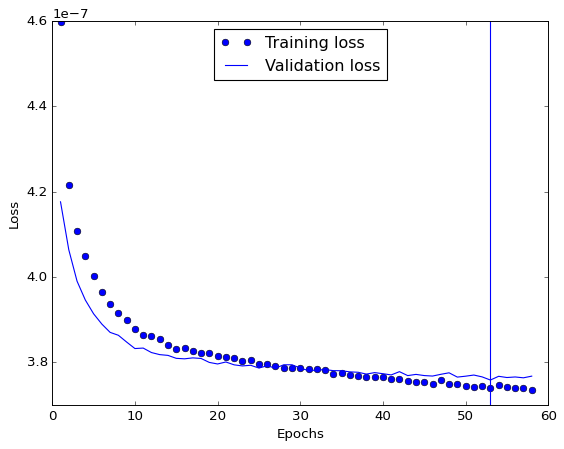

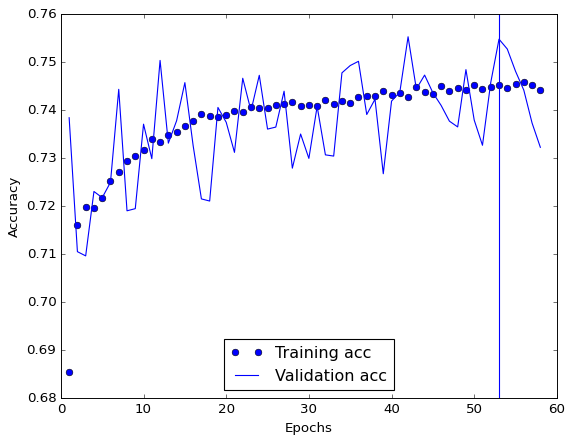

2021-04-19 13:13:48.509387: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-04-19 13:13:48.581687: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-04-19 13:13:48.583008: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-04-19 13:13:48.692555: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-19 13:13:48.902812: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-04-19 13:13:48.936664: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

In [10]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'reframe',region)

0.8860398625933948

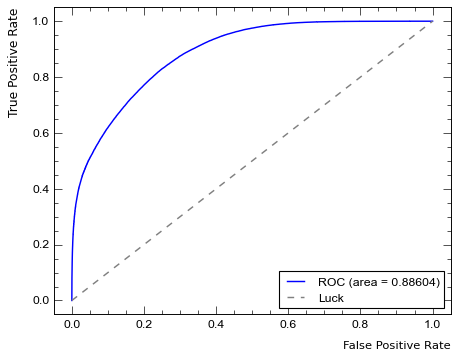

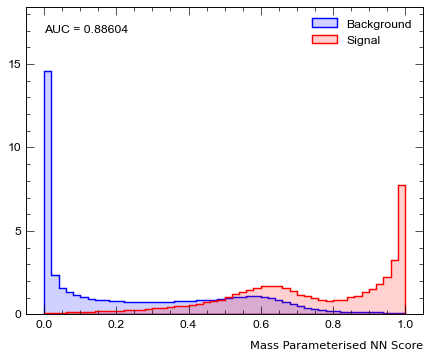

In [11]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'reframe')

In [10]:
#Load the NN
json_file = open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_arch_'+ region +'_'+ 'reframe'+'.h5')
loaded_model_json = json_file.read()
json_file.close()

modelNN = model_from_json(loaded_model_json)
modelNN.load_weights('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_weights_'+ region +'_'+ 'reframe'+'.h5')

(977067, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(978810, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(980083, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(980617, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(981324, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(980383, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(980821, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(980204, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(981081, 35) [ 0  1  2  3  4  5 

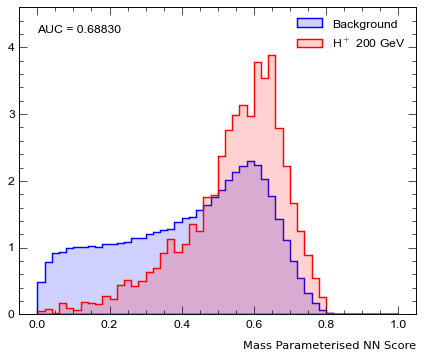

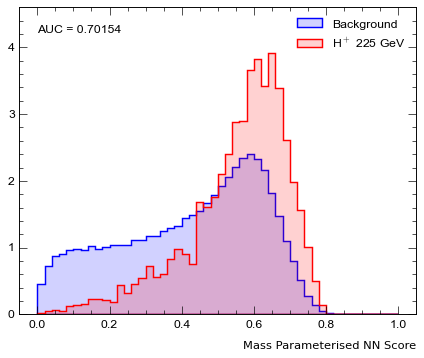

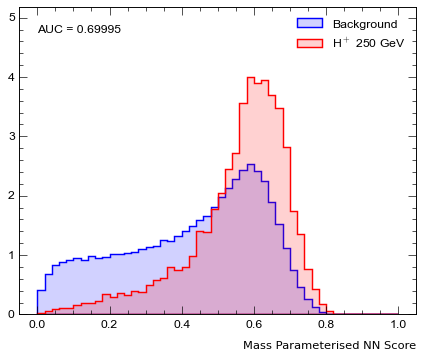

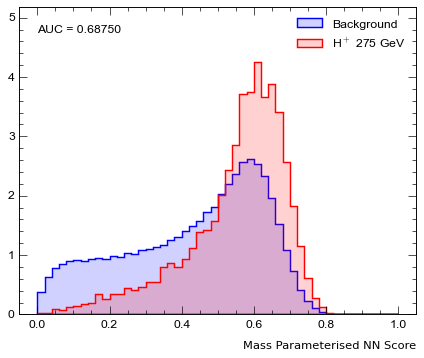

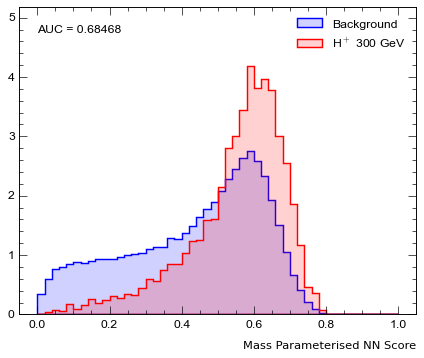

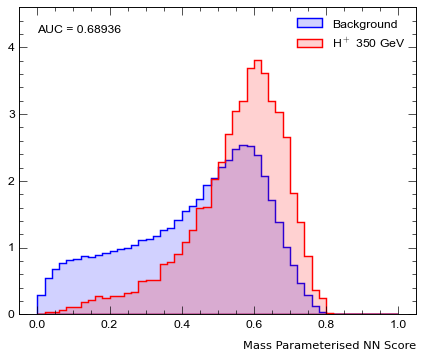

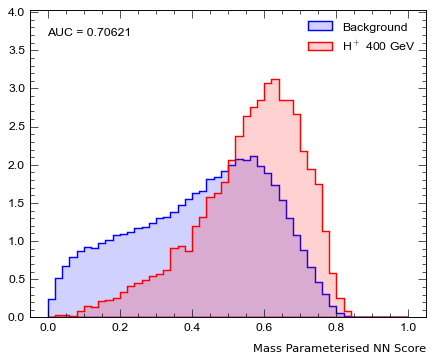

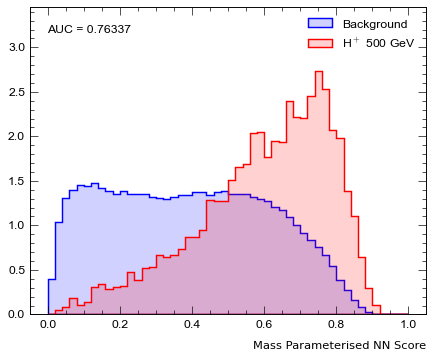

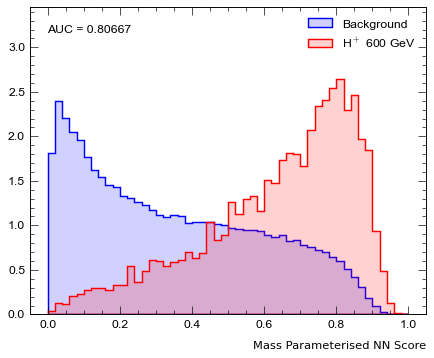

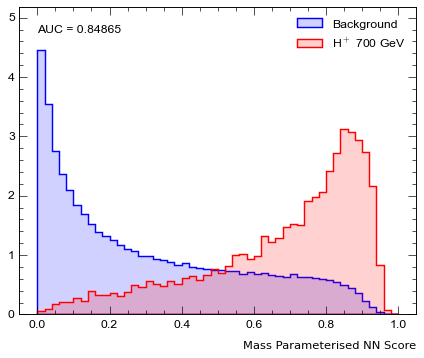

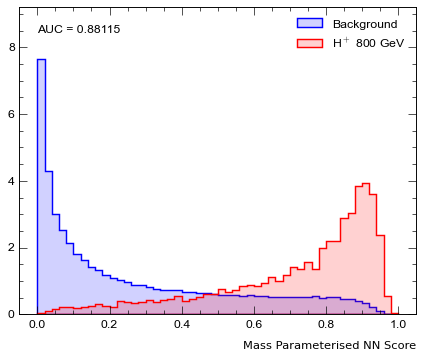

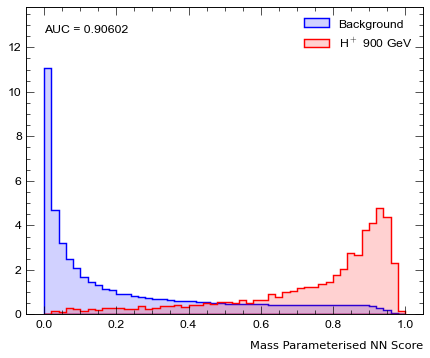

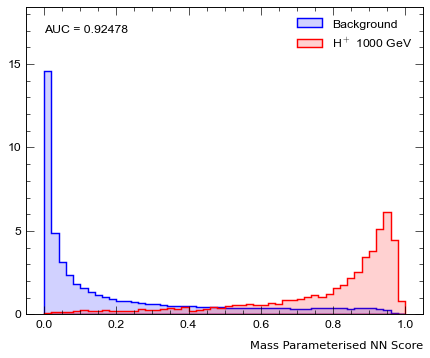

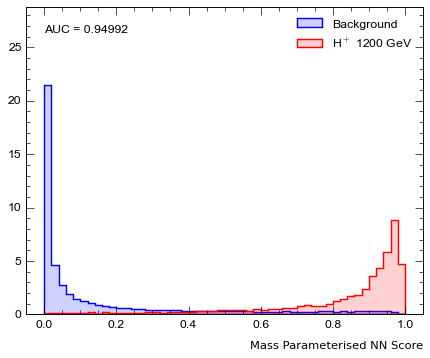

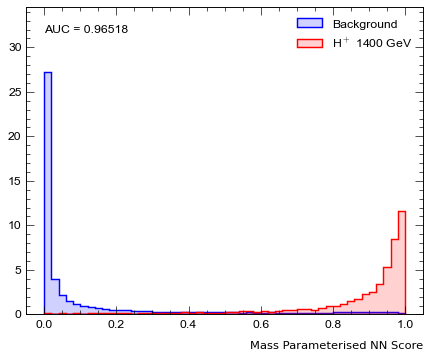

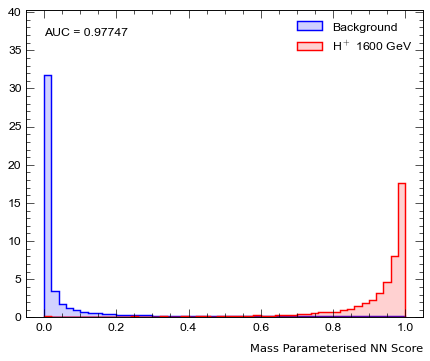

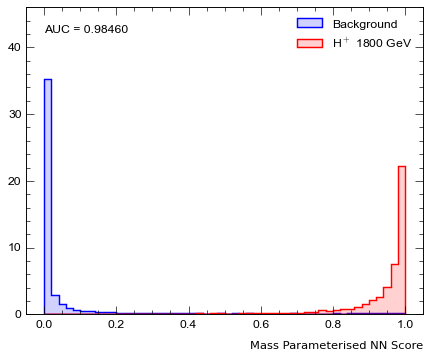

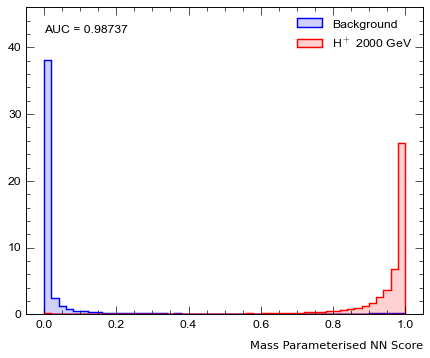

In [12]:
auc_everymass=[]

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'reframe',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

auc_everymass = np.array(auc_everymass)
auc_mass = auc_everymass[:,0]
auc_auc = auc_everymass[:,1]

with open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_new_training_reframe.json','w') as outputFile:
    json.dump({'Hp mass':list(auc_mass), 'AUC':list(auc_auc)}, outputFile, sort_keys=True)

(977067, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(978810, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(980083, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(980617, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(981324, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(980383, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(980821, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(980204, 35) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(981081, 35) [ 0  1  2  3  4  5 

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

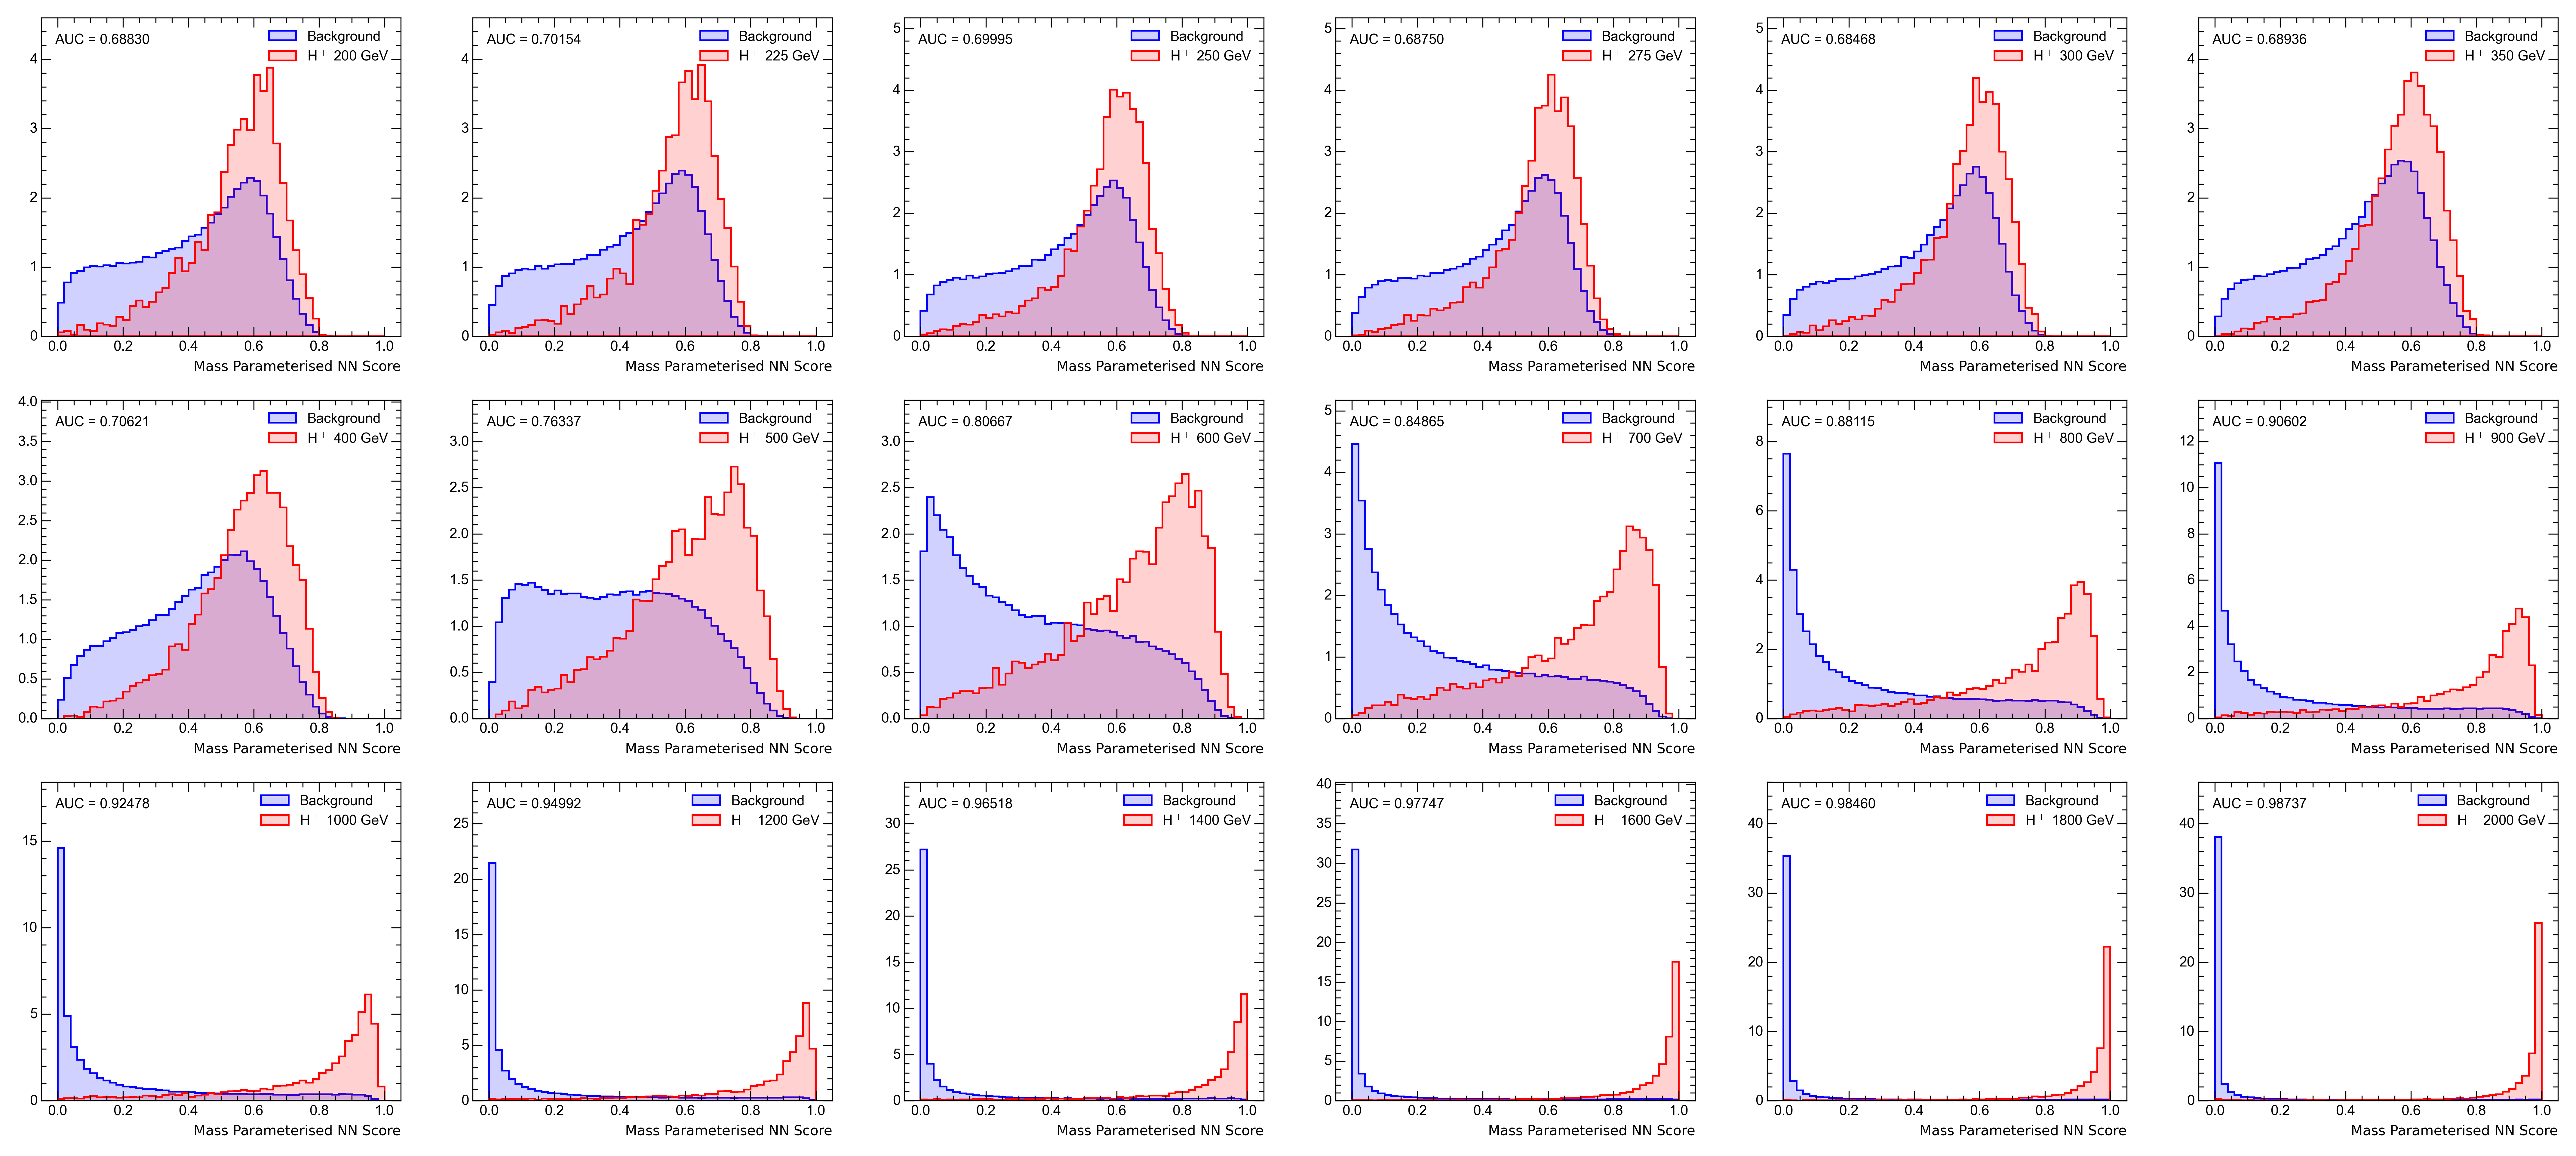

In [13]:
i=1
path = '/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training'
plt.rcParams["axes.linewidth"]= 0.4
plt.subplots_adjust(right=0.98,left=0.02,top=0.8, bottom=0.1, wspace=0, hspace=0.3)
plt.figure(figsize=(18,7.5),linewidth=0,dpi=600)

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:        
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        #Getting the data we want to plot
        y_pred = modelNN.model.predict(X_test.values).ravel()
        roc_auc = roc_auc_score(y_test,y_pred,sample_weight=w_test)
        false_pr, true_pr, thresholds = roc_curve(y_test, y_pred, sample_weight = w_test)
        
        #Plotting Score
        plt.subplot(3,6,i)

        plt.hist(y_pred[y_test<0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w_test[y_test<0.5], fc=(0.,0.,1.,0.18), ec="blue", linewidth=.7, density=True, label="Background")
        plt.hist(y_pred[y_test>0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w_test[y_test>0.5], fc=(1.,0.,0.,0.18), ec="red", linewidth=.7, density=True, label="H$^+$ {} GeV".format(mass))

        plt.xlabel("Mass Parameterised NN Score", ha="right",x=1, fontsize=5.5, labelpad=2.8)

        plt.minorticks_on()
        plt.tick_params(axis="both", which="major", width=.4, length=3.8, pad=1.5)
        plt.tick_params(axis="both", which="minor", width=.4, length=2, pad=1.5)

        plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=5.6))
        plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=5.6))

        plt.xlim(-.05,1.05)
        plt.ylim(0, plt.gca().get_ylim()[1]*1.15 )

        plt.legend(loc="best", frameon=False, prop=fm.FontProperties(fname=fpath,size=5.5))
        
        # Print AUC at the corner
        ax = plt.gca()
        plt.text(0.17,0.93,'AUC = {:.5f}'.format(roc_auc), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes,fontproperties=fm.FontProperties(fname=fpath,size=5.5))
        
        i+=1
        
plt.savefig(path + '/NN_Score_multiplot_' + region + '_' + 'reframe' + '.png',dpi=600,bbox_inches='tight',orientation='landscape')
plt.show

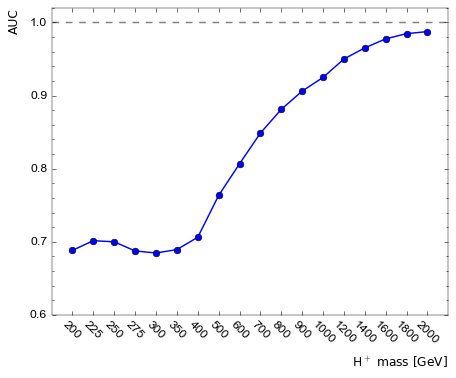

In [14]:
AUCvsHpmass(auc_auc,auc_mass,region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','reframe')

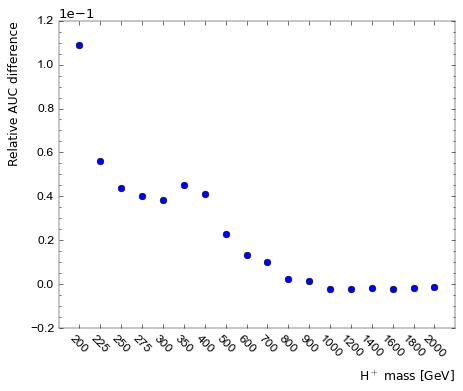

In [15]:
relativeAUC(auc_everymass[:,1],'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_actual_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','reframe_realtive')

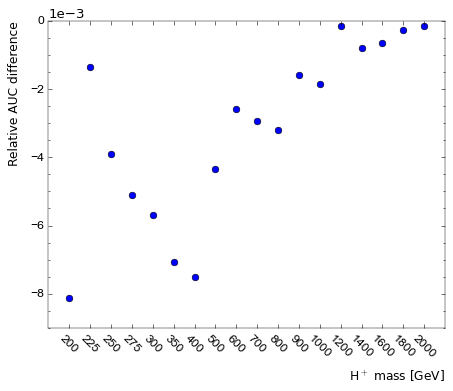

In [16]:
relativeAUC(np.array(auc_auc),'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_new_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','reframe_comparison')

## Adding 2 low level features

In [7]:
fpath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/arial.ttf")
fbipath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/ArialBoldItalic.ttf")
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.linewidth']= 0.85

feature_names = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_m1', 'jet_mv2c101', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_m2', 'jet_mv2c102', 'jet_pt3', 'jet_eta3', 'jet_phi3', 'jet_m3', 'jet_mv2c103', 'jet_pt4', 'jet_eta4', 'jet_phi4', 'jet_m4', 'jet_mv2c104', 'jet_pt5', 'jet_eta5', 'jet_phi5', 'jet_m5', 'jet_mv2c105', 'jet_pt6', 'jet_eta6', 'jet_phi6', 'jet_m6', 'jet_mv2c106','lepton_pt','lepton_phi','lepton_eta','met_met','met_phi','HT_jets','Mbb_MindR_70']
steps = ['msb','scl','rnd','fd','wss']
region = "INC_ge6jge4b"
exclude_columns = feature_names[:-2]
NNlayers = [64,64]
batchsize = 50
dropout = 0.1
epochs = 300
patience = 5

In [8]:
df_new = pd.read_feather('/nfs/pic.es/user/s/srodrigu/Jupyter/pandas_files/pandas_INC_ge6jgeq4b.feather')

In [9]:
data = PrepareMassParametrised(df_new, feature_names, steps_names=steps, exclude_columns=exclude_columns, onediscr=False)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit = data[2]

msb:
Background integral: 0.5000000000000001 
Signal integral: 0.5 

scl:
Background integral: 0.5000000000000001 
Signal integral: 0.5000000000000001 

-1 1942133    2.113674e-07
1636581    2.093343e-07
1839581    1.470414e-07
1602098    4.447223e-08
1591364    4.025891e-08
               ...     
773654     6.444582e-07
1650185    1.893742e-07
1401201    5.034874e-08
1591320    3.677423e-08
1014802    7.224909e-07
Name: weight, Length: 973134, dtype: float64 0.5000000000000001
200 1950775    0.000022
1949967    0.000028
1950451    0.000015
1952146    0.000027
1951592    0.000034
             ...   
1951660    0.000024
1951692    0.000021
1948311    0.000021
1950101    0.000023
1949062    0.000021
Name: weight, Length: 2100, dtype: float64 0.04405286343612335
225 1959401    0.000004
1953820    0.000004
1957932    0.000007
1952456    0.000006
1956420    0.000006
             ...   
1954155    0.000005
1956217    0.000004
1956965    0.000005
1958919    0.000006
1958085    0.000006
Name:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2624      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,849
Trainable params: 6,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
21740/21740 [==============================] - 120s 6ms/step - loss: 4.4068e-07 - binary_accuracy: 0.7095 - 

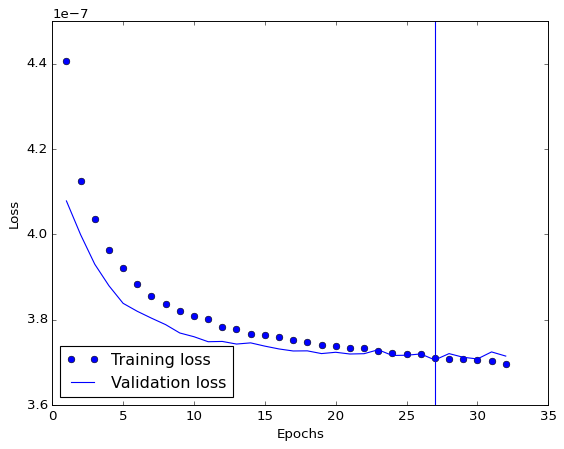

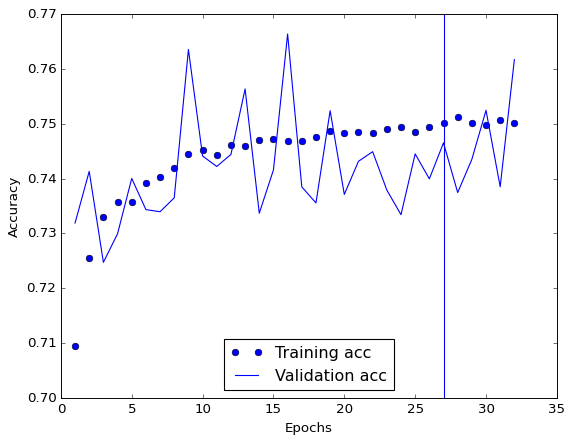

2021-04-21 16:35:00.517252: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-04-21 16:35:00.577862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:3e:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-04-21 16:35:00.580624: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-04-21 16:35:00.584895: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-21 16:35:00.588205: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-04-21 16:35:00.589262: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

In [10]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'HT_jets_and_Mbb_mindR',region)

0.8900099386676722

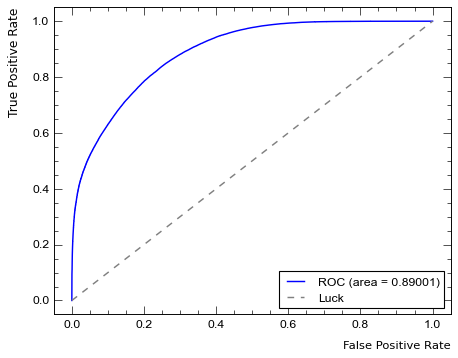

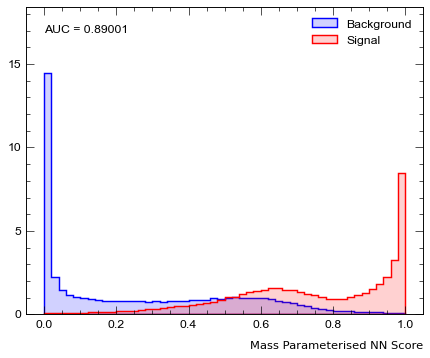

In [11]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'HT_jets_and_Mbb_mindR')

In [12]:
#Load the NN
json_file = open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_arch_'+ region +'_'+ 'HT_jets_and_Mbb_mindR' + '.h5')
loaded_model_json = json_file.read()
json_file.close()

modelNN = model_from_json(loaded_model_json)
modelNN.load_weights('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_weights_'+ region +'_'+ 'HT_jets_and_Mbb_mindR' + '.h5')

(977067, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(978810, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(980083, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(980617, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(981324, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(980383, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(980821, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(980204, 40) [ 0  1  2  3  4  5  6  7  8  9 10 1

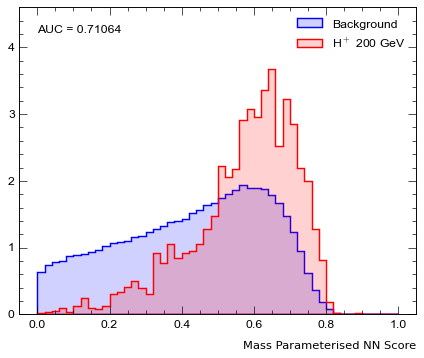

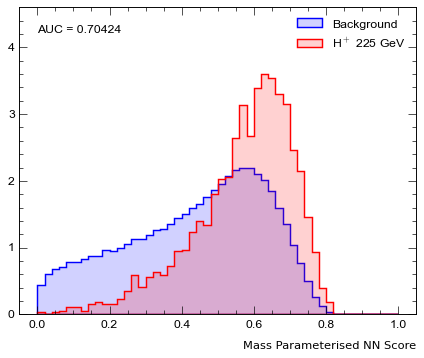

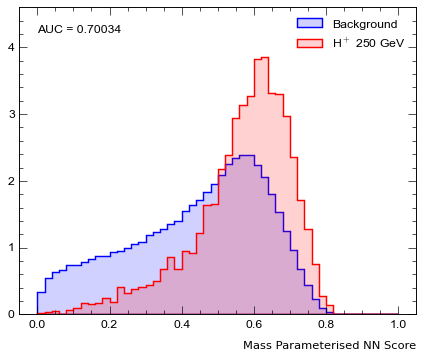

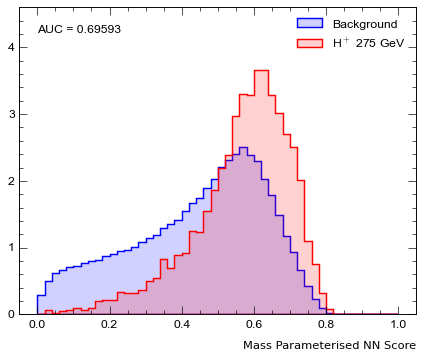

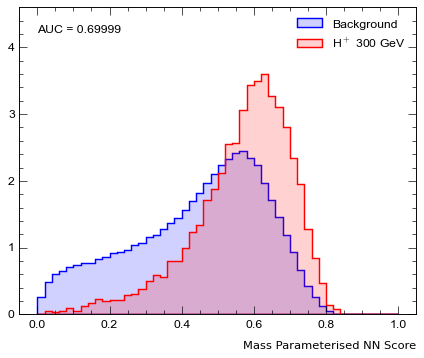

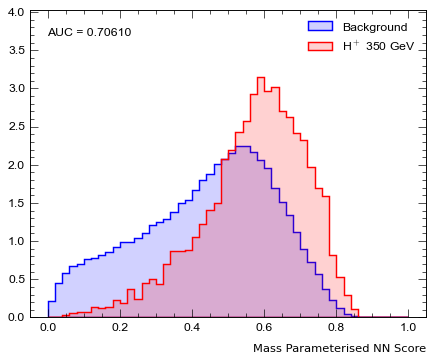

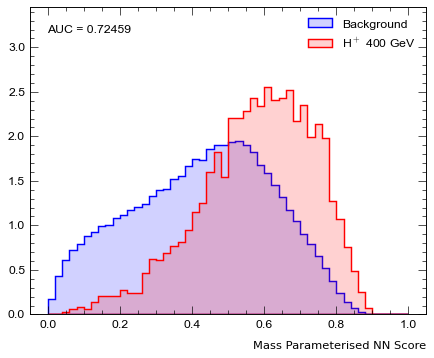

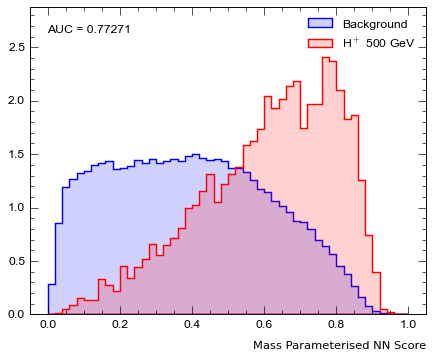

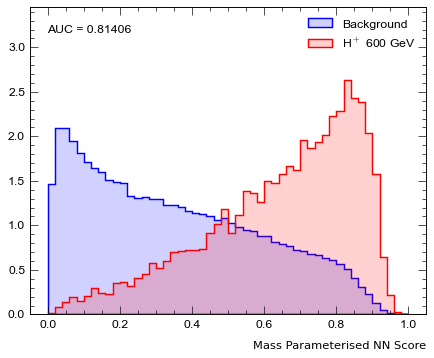

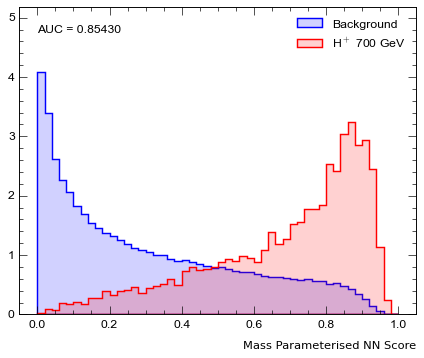

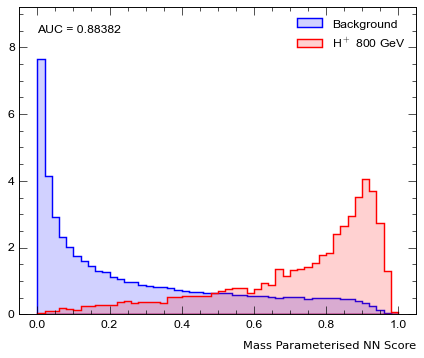

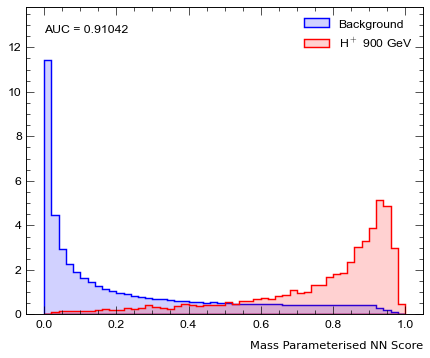

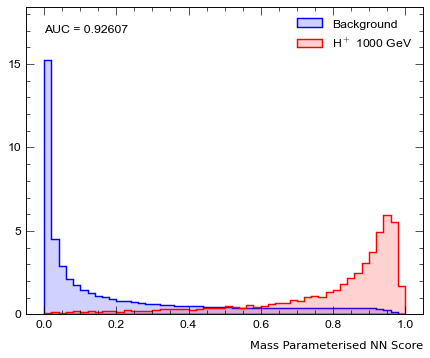

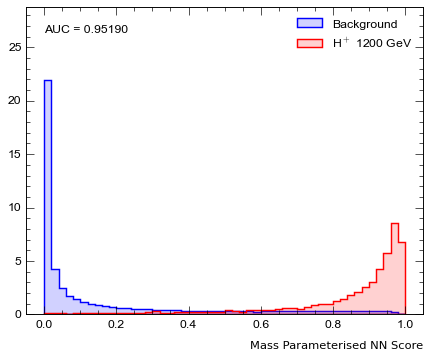

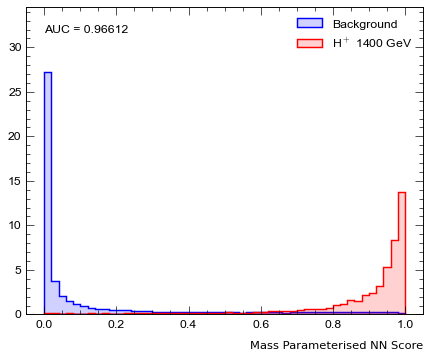

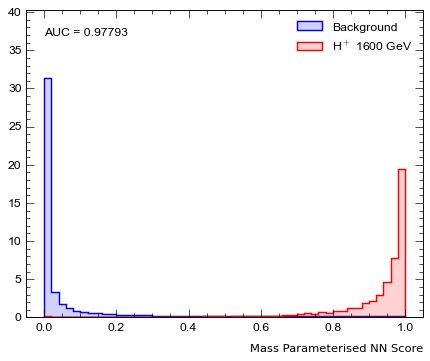

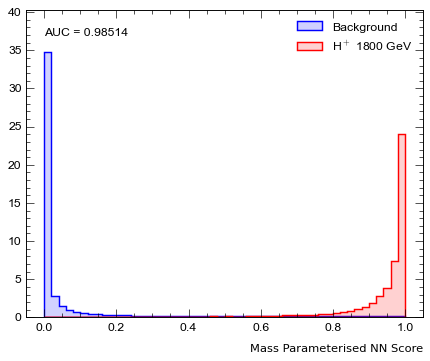

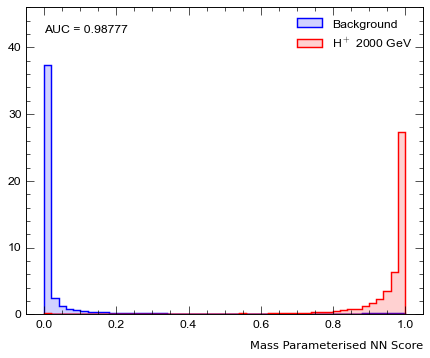

In [15]:
auc_everymass=[]

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
        fd = FeatureDivider("hpmass", excludecolumns=exclude_columns)
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass
        
        X_test, y_test, w_test = fd.transform(X_test,y_test, sample_weight=w_test)
        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'HT_jets_and_Mbb_mindR',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

auc_everymass = np.array(auc_everymass)
auc_mass = auc_everymass[:,0]
auc_auc = auc_everymass[:,1]

with open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_new_training_HT_jets_and_Mbb_mindR.json','w') as outputFile:
    json.dump({'Hp mass':list(auc_mass), 'AUC':list(auc_auc)}, outputFile, sort_keys=True)

(977067, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(978810, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(980083, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(980617, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(981324, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(980383, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(980821, 40) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(980204, 40) [ 0  1  2  3  4  5  6  7  8  9 10 1

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

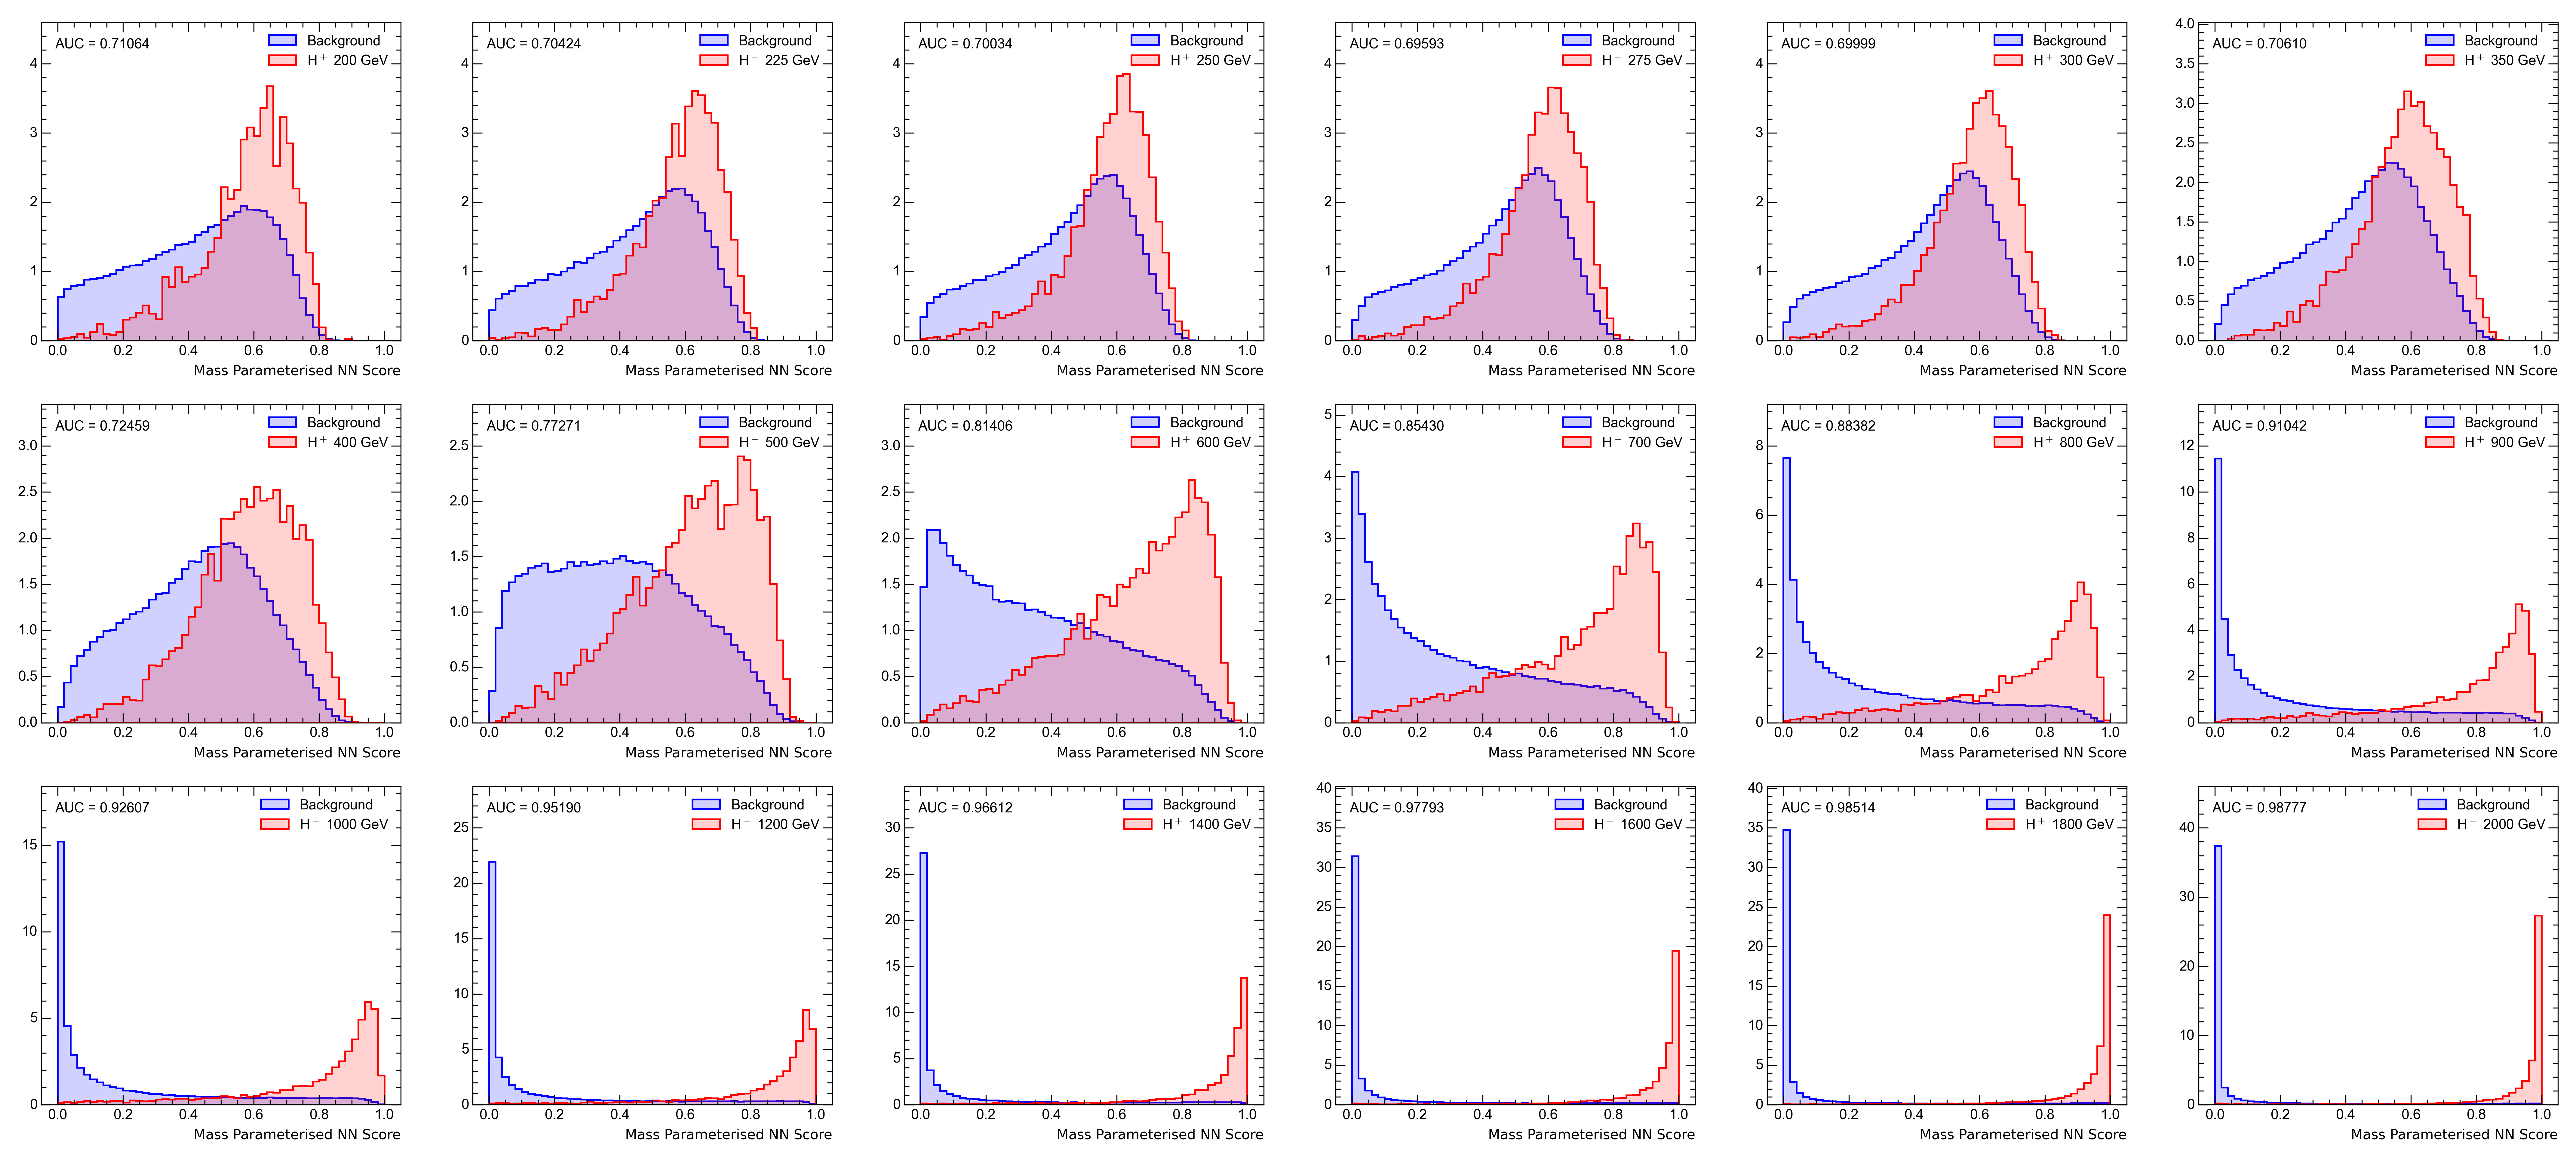

In [17]:
i=1
path = '/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training'
plt.rcParams["axes.linewidth"]= 0.4
plt.subplots_adjust(right=0.98,left=0.02,top=0.8, bottom=0.1, wspace=0, hspace=0.3)
plt.figure(figsize=(18,7.5),linewidth=0,dpi=600)

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:        
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
        fd = FeatureDivider("hpmass", excludecolumns=exclude_columns)
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = fd.transform(X_test,y_test, sample_weight=w_test)
        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        #Getting the data we want to plot
        y_pred = modelNN.predict(X_test.values).ravel()
        roc_auc = roc_auc_score(y_test,y_pred,sample_weight=w_test)
        false_pr, true_pr, thresholds = roc_curve(y_test, y_pred, sample_weight = w_test)
        
        #Plotting Score
        plt.subplot(3,6,i)

        plt.hist(y_pred[y_test<0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w_test[y_test<0.5], fc=(0.,0.,1.,0.18), ec="blue", linewidth=.7, density=True, label="Background")
        plt.hist(y_pred[y_test>0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w_test[y_test>0.5], fc=(1.,0.,0.,0.18), ec="red", linewidth=.7, density=True, label="H$^+$ {} GeV".format(mass))

        plt.xlabel("Mass Parameterised NN Score", ha="right",x=1, fontsize=5.5, labelpad=2.8)

        plt.minorticks_on()
        plt.tick_params(axis="both", which="major", width=.4, length=3.8, pad=1.5)
        plt.tick_params(axis="both", which="minor", width=.4, length=2, pad=1.5)

        plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=5.6))
        plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=5.6))

        plt.xlim(-.05,1.05)
        plt.ylim(0, plt.gca().get_ylim()[1]*1.15 )

        plt.legend(loc="best", frameon=False, prop=fm.FontProperties(fname=fpath,size=5.5))
        
        # Print AUC at the corner
        ax = plt.gca()
        plt.text(0.17,0.93,'AUC = {:.5f}'.format(roc_auc), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes,fontproperties=fm.FontProperties(fname=fpath,size=5.5))
        
        i+=1
        
plt.savefig(path + '/NN_Score_multiplot_' + region + '_' + 'HT_jets_and_Mbb_mindR' + '.png',dpi=600,bbox_inches='tight',orientation='landscape')
plt.show

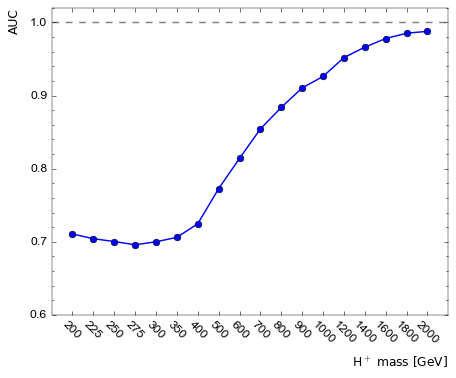

In [18]:
AUCvsHpmass(auc_auc,auc_mass,region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','HT_jets_and_Mbb_mindR')

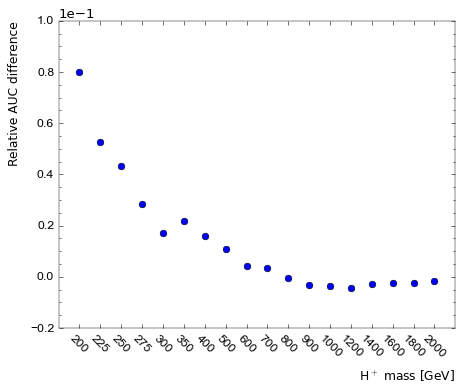

In [19]:
relativeAUC(auc_everymass[:,1],'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_actual_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','HT_jets_and_Mbb_mindR_relative')

## Adding 2 high level features + reframe + new hyperparameters

In [20]:
fpath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/arial.ttf")
fbipath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/ArialBoldItalic.ttf")
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.linewidth']= 0.85

feature_names = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_m1', 'jet_mv2c101', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_m2', 'jet_mv2c102', 'jet_pt3', 'jet_eta3', 'jet_phi3', 'jet_m3', 'jet_mv2c103', 'jet_pt4', 'jet_eta4', 'jet_phi4', 'jet_m4', 'jet_mv2c104', 'jet_pt5', 'jet_eta5', 'jet_phi5', 'jet_m5', 'jet_mv2c105', 'jet_pt6', 'jet_eta6', 'jet_phi6', 'jet_m6', 'jet_mv2c106','lepton_pt','lepton_phi','lepton_eta','met_met','met_phi','HT_jets','Mbb_MindR_70']
steps = ['msb','scl','rnd','fd','wss']
region = "INC_ge6jge4b"
exclude_columns = feature_names[:-2]
NNlayers = [128,128,128]
batchsize = 512
dropout = 0.1
epochs = 300
patience = 5

In [21]:
df_new = pd.read_feather('/nfs/pic.es/user/s/srodrigu/Jupyter/pandas_files/pandas_INC_ge6jgeq4b.feather')

In [22]:
data = PrepareMassParametrised(df_new, feature_names, steps_names=steps, reframelep_phi=True, reframelep_eta=True, exclude_columns=exclude_columns, onediscr=False)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit = data[2]

msb:
Background integral: 0.5000000000000001 
Signal integral: 0.5 

scl:
Background integral: 0.5000000000000001 
Signal integral: 0.5000000000000001 

-1 1942133    2.113674e-07
1636581    2.093343e-07
1839581    1.470414e-07
1602098    4.447223e-08
1591364    4.025891e-08
               ...     
773654     6.444582e-07
1650185    1.893742e-07
1401201    5.034874e-08
1591320    3.677423e-08
1014802    7.224909e-07
Name: weight, Length: 973134, dtype: float64 0.5000000000000001
200 1950775    0.000022
1949967    0.000028
1950451    0.000015
1952146    0.000027
1951592    0.000034
             ...   
1951660    0.000024
1951692    0.000021
1948311    0.000021
1950101    0.000023
1949062    0.000021
Name: weight, Length: 2100, dtype: float64 0.04405286343612335
225 1959401    0.000004
1953820    0.000004
1957932    0.000007
1952456    0.000006
1956420    0.000006
             ...   
1954155    0.000005
1956217    0.000004
1956965    0.000005
1958919    0.000006
1958085    0.000006
Name:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               5120      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

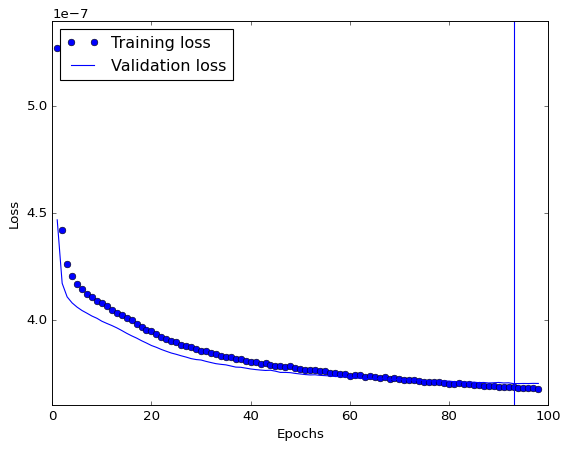

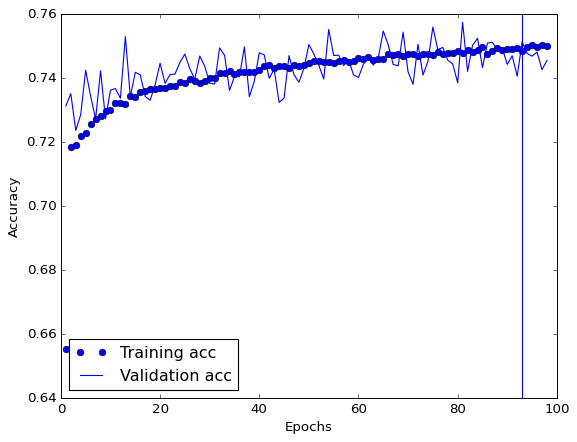

In [23]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'HT_jets_and_Mbb_mindR_reframe_newhyperpar',region)

0.8901198740183291

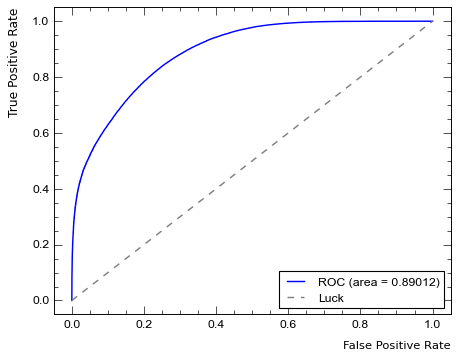

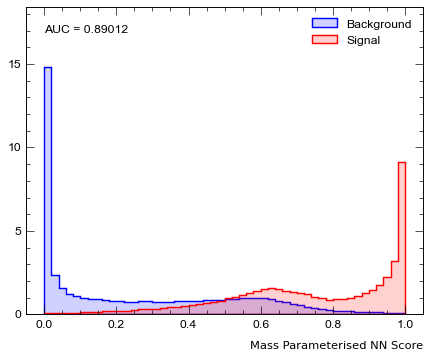

In [26]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'HT_jets_and_Mbb_mindR_reframe_newhyperpar')

In [27]:
#Load the NN
json_file = open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_arch_'+ region +'_'+ 'HT_jets_and_Mbb_mindR_reframe_newhyperpar' + '.h5')
loaded_model_json = json_file.read()
json_file.close()

modelNN = model_from_json(loaded_model_json)
modelNN.load_weights('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/Training_NN_models/NN_weights_'+ region +'_'+ 'HT_jets_and_Mbb_mindR_reframe_newhyperpar' + '.h5')

(977067, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(978810, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980083, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980617, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(981324, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980383, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980821, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980204, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 1

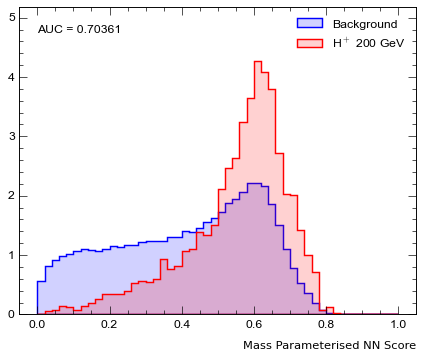

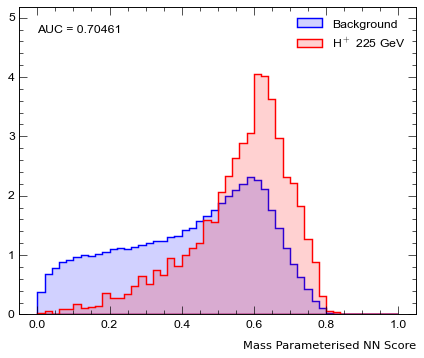

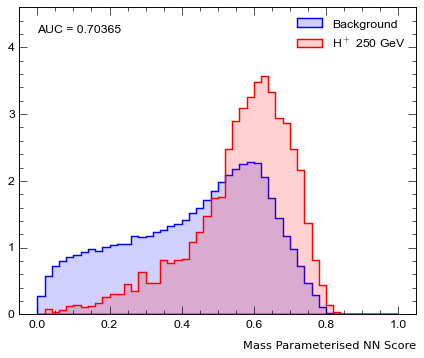

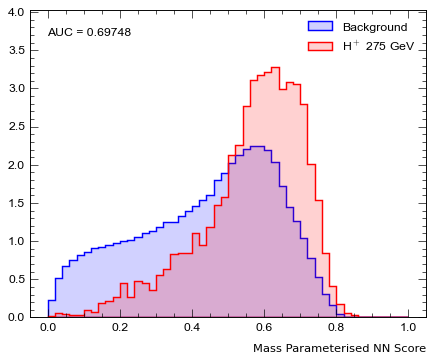

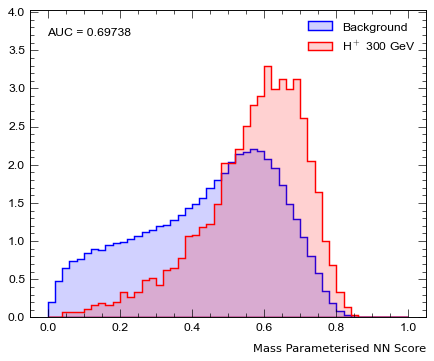

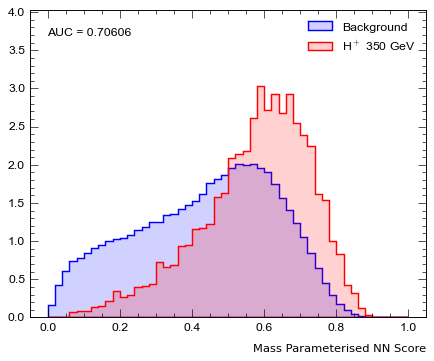

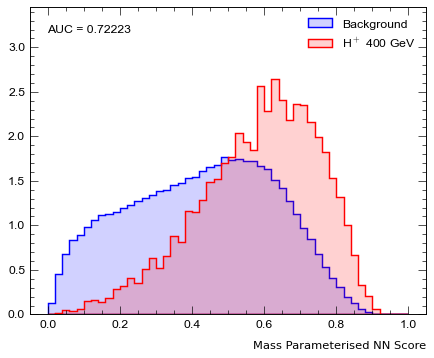

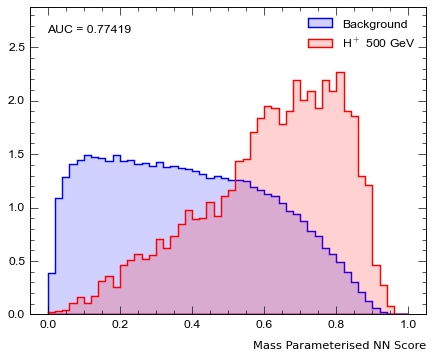

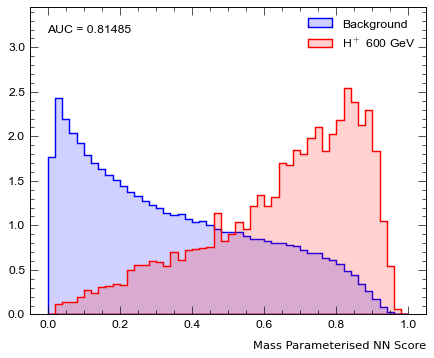

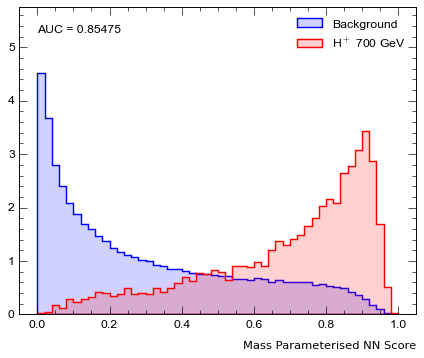

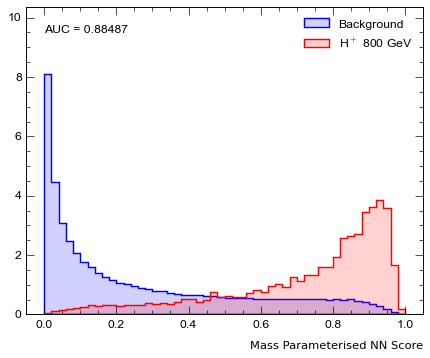

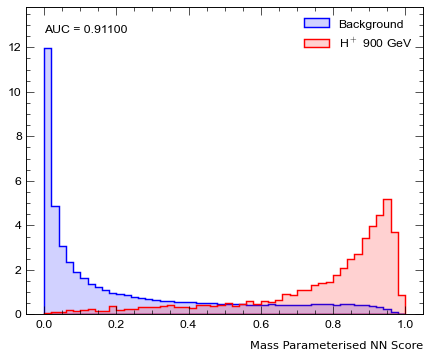

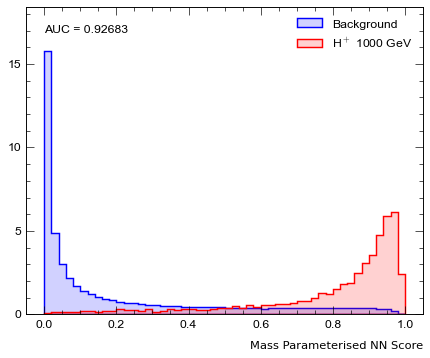

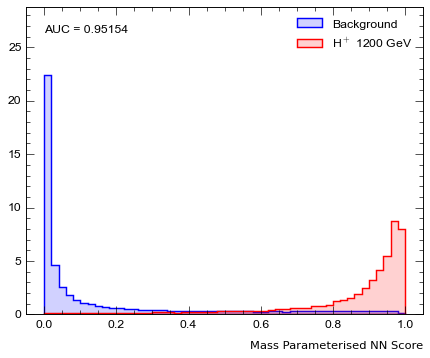

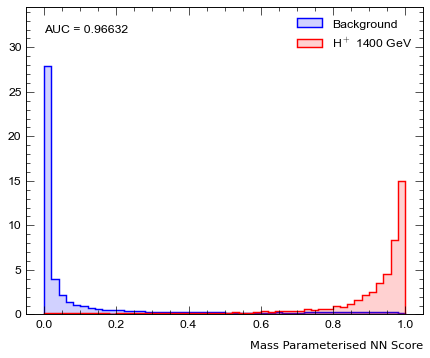

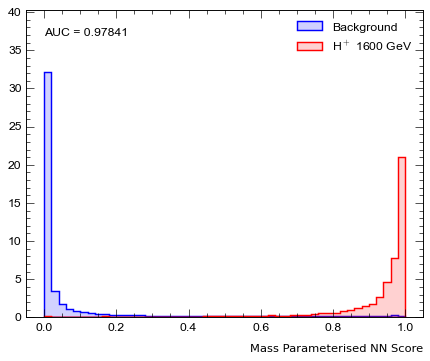

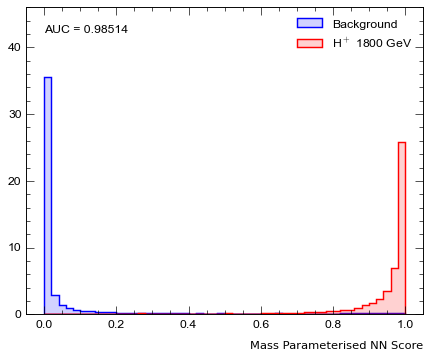

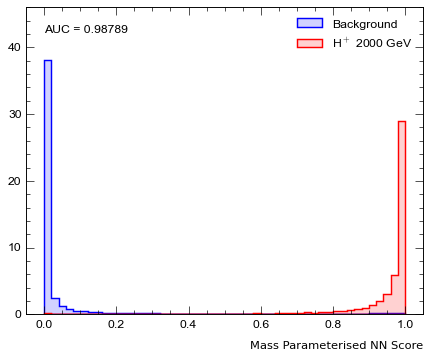

In [30]:
auc_everymass=[]

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
        fd = FeatureDivider("hpmass", excludecolumns=exclude_columns)
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass
        
        X_test, y_test, w_test = fd.transform(X_test,y_test, sample_weight=w_test)
        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'HT_jets_and_Mbb_mindR_reframe_newhyperpar',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

auc_everymass = np.array(auc_everymass)
auc_mass = auc_everymass[:,0]
auc_auc = auc_everymass[:,1]

with open('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_new_training_HT_jets_and_Mbb_mindR_reframe_newhyperpar.json','w') as outputFile:
    json.dump({'Hp mass':list(auc_mass), 'AUC':list(auc_auc)}, outputFile, sort_keys=True)

(977067, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(978810, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980083, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980617, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(981324, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980383, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980821, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980204, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 1

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

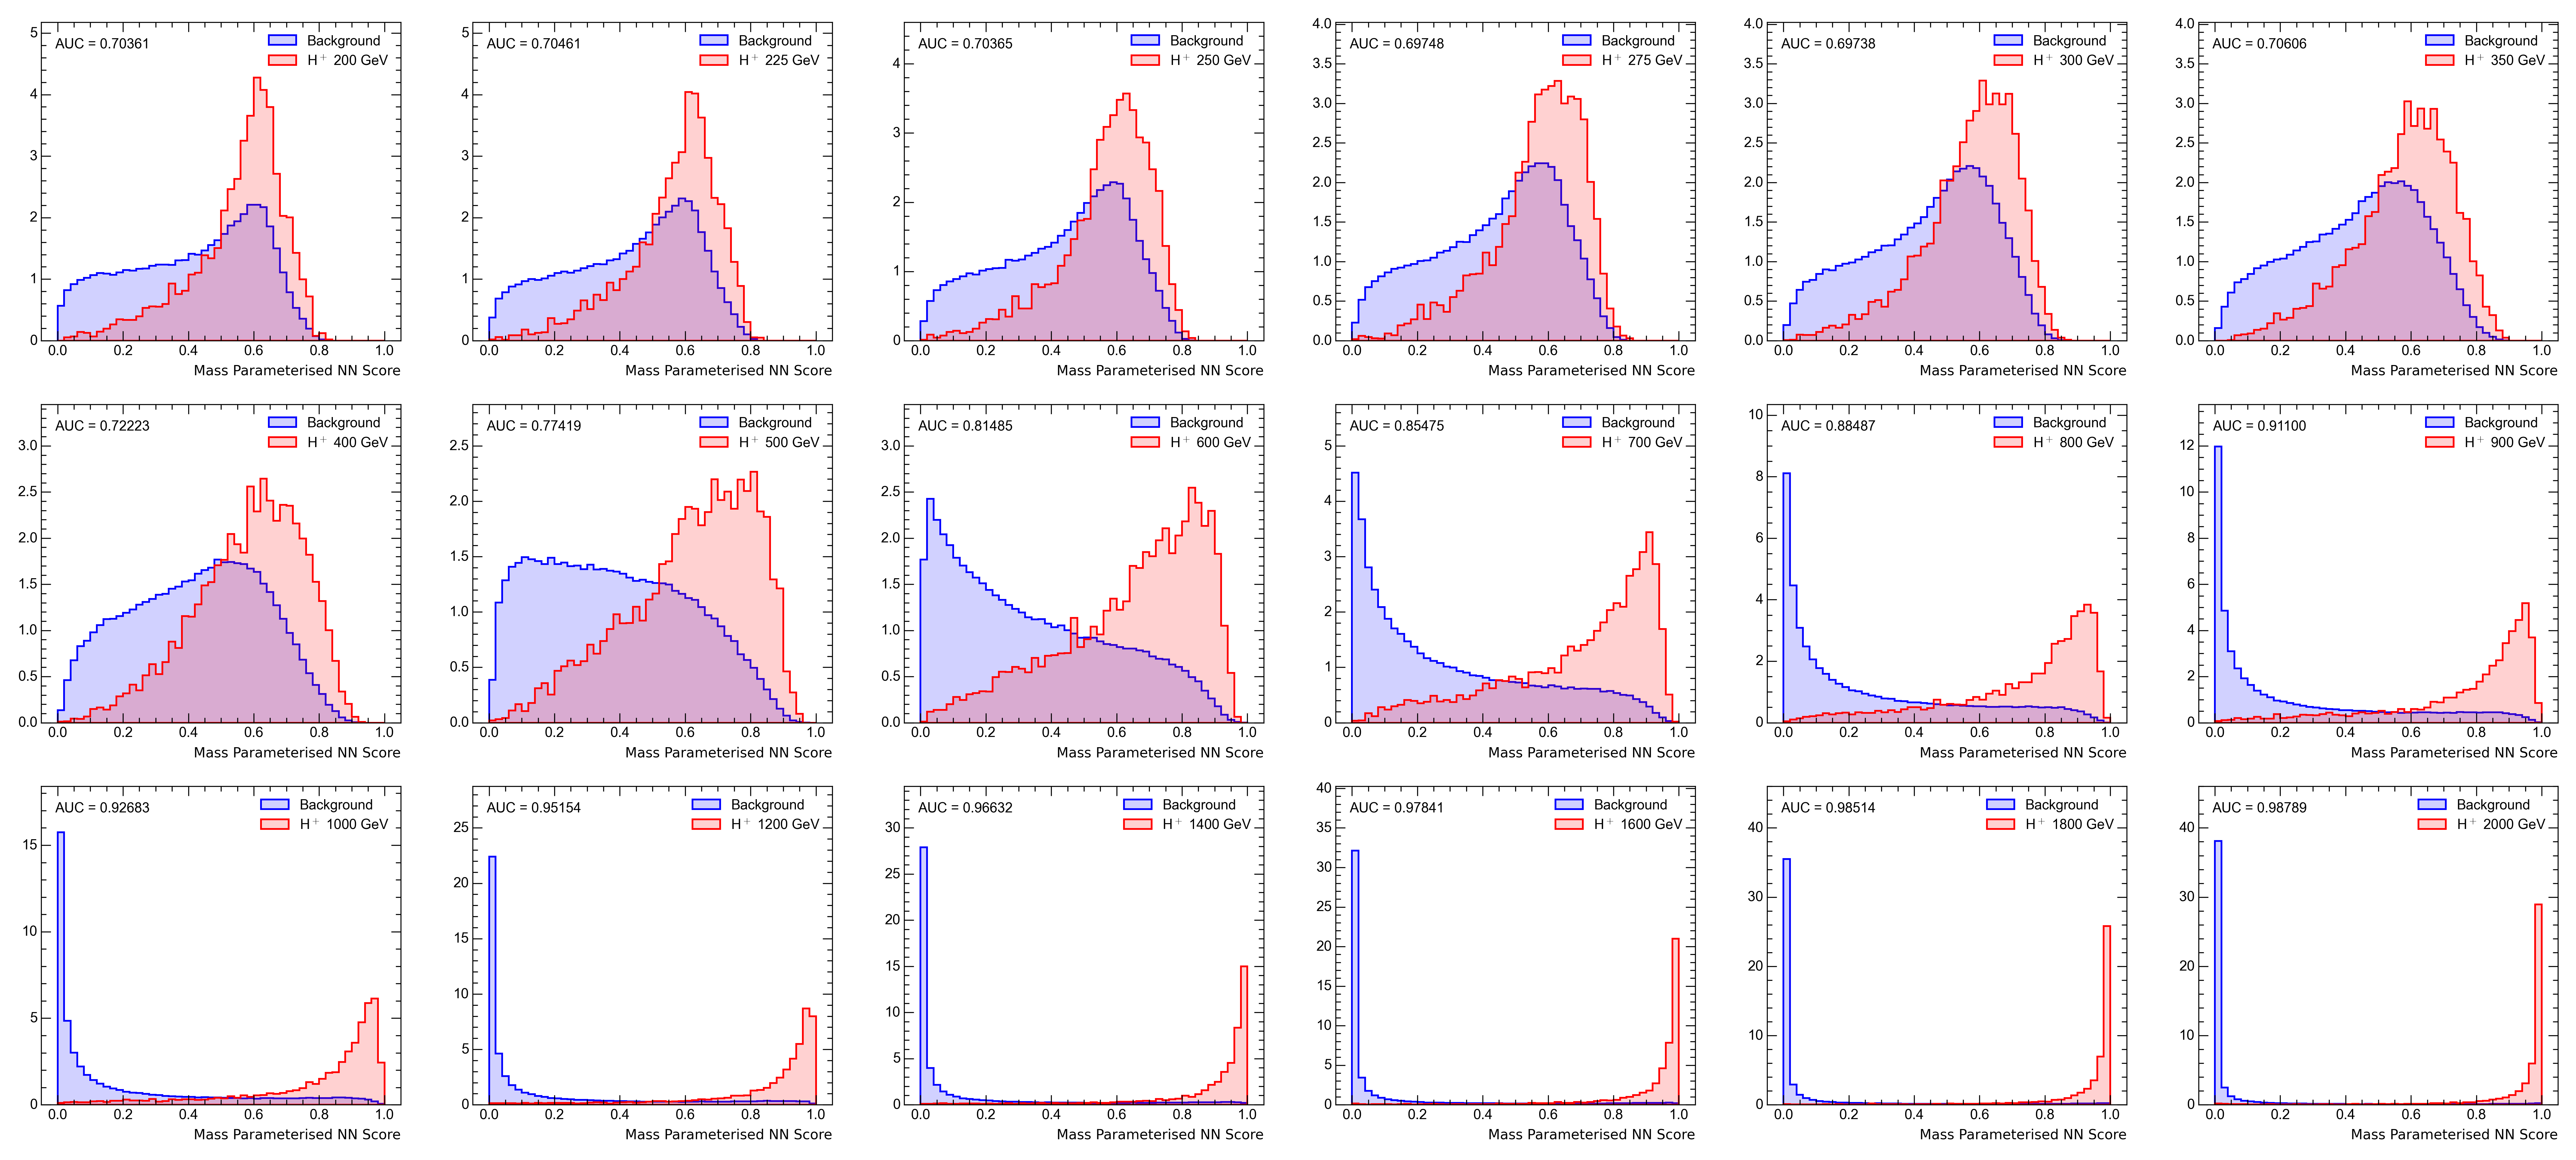

In [32]:
i=1
path = '/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training'
plt.rcParams["axes.linewidth"]= 0.4
plt.subplots_adjust(right=0.98,left=0.02,top=0.8, bottom=0.1, wspace=0, hspace=0.3)
plt.figure(figsize=(18,7.5),linewidth=0,dpi=600)

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:        
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
        fd = FeatureDivider("hpmass", excludecolumns=exclude_columns)
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = fd.transform(X_test,y_test, sample_weight=w_test)
        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        #Getting the data we want to plot
        y_pred = modelNN.predict(X_test.values).ravel()
        roc_auc = roc_auc_score(y_test,y_pred,sample_weight=w_test)
        false_pr, true_pr, thresholds = roc_curve(y_test, y_pred, sample_weight = w_test)
        
        #Plotting Score
        plt.subplot(3,6,i)

        plt.hist(y_pred[y_test<0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w_test[y_test<0.5], fc=(0.,0.,1.,0.18), ec="blue", linewidth=.7, density=True, label="Background")
        plt.hist(y_pred[y_test>0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w_test[y_test>0.5], fc=(1.,0.,0.,0.18), ec="red", linewidth=.7, density=True, label="H$^+$ {} GeV".format(mass))

        plt.xlabel("Mass Parameterised NN Score", ha="right",x=1, fontsize=5.5, labelpad=2.8)

        plt.minorticks_on()
        plt.tick_params(axis="both", which="major", width=.4, length=3.8, pad=1.5)
        plt.tick_params(axis="both", which="minor", width=.4, length=2, pad=1.5)

        plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=5.6))
        plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=5.6))

        plt.xlim(-.05,1.05)
        plt.ylim(0, plt.gca().get_ylim()[1]*1.15 )

        plt.legend(loc="best", frameon=False, prop=fm.FontProperties(fname=fpath,size=5.5))
        
        # Print AUC at the corner
        ax = plt.gca()
        plt.text(0.17,0.93,'AUC = {:.5f}'.format(roc_auc), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes,fontproperties=fm.FontProperties(fname=fpath,size=5.5))
        
        i+=1
        
plt.savefig(path + '/NN_Score_multiplot_' + region + '_' + 'HT_jets_and_Mbb_mindR_reframe_newhyperpar' + '.png',dpi=600,bbox_inches='tight',orientation='landscape')
plt.show

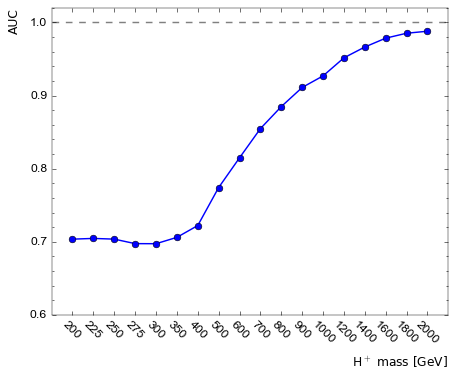

In [33]:
AUCvsHpmass(auc_auc,auc_mass,region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','HT_jets_and_Mbb_mindR_reframe_newhyperpar')

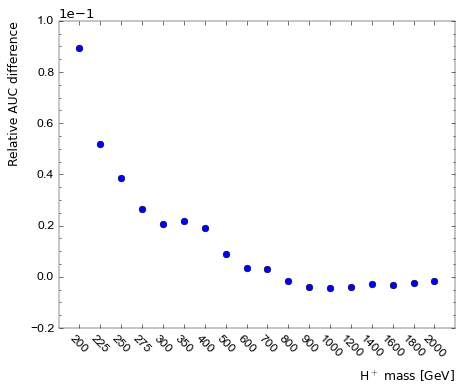

In [34]:
relativeAUC(auc_everymass[:,1],'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/auc_actual_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','HT_jets_and_Mbb_mindR_reframe_newhyperpar_relative')